In this notebook, the Exploratory Data analysis for M5 competition data is performed using R and sales for 28 days were forecasted using Xgboost, Catboost, Lightgbm, and Facebook prophet. The best model is chosen by comparing the SMAPE error rate and One standard error rule.

### Background of Competition:
The Makridakis Competitions (also known as the M Competitions) are series of open competitions organized by teams led by forecasting researcher Spyros Makridakis and intended to evaluate and compare the accuracy of different forecasting methods. he first competition named M-Competition was held way back in 1982 with only 1001 data points, the complexity of model and data scale increased with every successive iteration.



### Aim:
In March this year(2020), the fifth iteration named M5 competition was held. This m5 competition aims to forecast daily sales for the next 28 days i.e., till 22nd May 2016, and to make uncertainty estimates for these forecasts. In this blog, I am just going to do forecasting and uncertainty will be performed in my next blog with the best-chosen model.


### Dataset:
The dataset provided contains 42,840 hierarchical sales data from Walmart. The dataset covers stores in three US states (California, Texas, and Wisconsin) and includes item level, department, product categories, and store details for 5 years starting from 29th Jan 2011 to 24th April 2016. Also, it has explanatory variables such as price, snap events, day of the week, and special events and festivals.

The data comprises 3049 individual products from 3 categories and 7 departments, sold in 10 stores in 3 states. The hierarchical aggregation captures the combinations of these factors which makes it feasible to perform a bottom-up approach or top-down approach. For instance, we can create 1 time series for all sales or perform for each state separately and so on.



### Hypothesis
Based on the data given some of the factors that may affect sales are:
1. Day- Customers shopping time and spending mostly depends on the weekend. Many customers may like to shop only at weekends.
2. Special Events/Holidays: Depending on the events and holidays customers purchasing behavior may change. For holidays like Easter, food sales may go up and for sporting events like Superbowl finals Household item sales may go up.
3. Product Price: The sales are affected the most by the product price. Most customers will check the price tag before making the final purchase.
4. Product Category: The type of product greatly affects sales. For instance, products in the household like TV will have fewer sales when compared with sales of food products.
5. Location: The location also plays an important role in sales. In states like California, the customers might buy products they want irrespective of price, and customers in another region may be price sensitive

Before diving deep into data exploration, A quick overview of population & Median Income for each state:

### California
Population: 39.51 Million
Median Household Annual Income: $75,277

### Texas
Population: 29 Million
Median Household Annual Income: $59,570

### Wisconsin
Population 5.822 Million
Median Income: $60,733

### Loading required libraries and data

In [1]:
suppressMessages({
    library(data.table)
    library(RcppRoll)
    library(lightgbm)
    library(dplyr)
    library(lubridate)
    library(reshape2)
    library(Matrix)
    library(splitstackshape)
#   library(mltools)
#   library(caret)
    library(xgboost)
    library(catboost)
    library(tidyverse)
    library(ggplot2) 
    library(scales)
    library(plotly)
    library(skimr)
    library(tibble)
    library(tidyr) 
    library(stringr)  
    library(GGally)
    library(ggthemes)
    library(sqldf)
    library(ggpubr)
    library(timetk)
    
})

options(repr.plot.width = 14, repr.plot.height = 8)

Warning message:
“no DISPLAY variable so Tk is not available”


Reading data using fread

In [2]:
train <- fread("../input/m5-forecasting-accuracy/sales_train_evaluation.csv", na.strings=c("", "NULL"), header = TRUE, stringsAsFactors = TRUE)
calendar <- fread("../input/m5-forecasting-accuracy/calendar.csv", na.strings=c("", "NULL"), header = TRUE, stringsAsFactors = TRUE)
prices <- fread("../input/m5-forecasting-accuracy/sell_prices.csv", na.strings=c("", "NULL"), header = TRUE, stringsAsFactors = TRUE)
submission = fread('../input/m5-forecasting-accuracy/sample_submission.csv')

Function to optimize ram

In [3]:
freeram <- function(...) invisible(gc(...))

In [4]:
prices[, c('sell_price')] <- sapply(prices[, c('sell_price')], as.numeric)
calendar$date <- as.Date(calendar$date)
freeram()

Replacing all NA values in calendar with None 

In [5]:
calendar$date<-as.Date(calendar$date)
calendar$event_type_1<- as.character(calendar$event_type_1)
calendar$event_type_2<- as.character(calendar$event_type_2)
calendar$event_name_1<- as.character(calendar$event_name_1)
calendar$event_name_2<- as.character(calendar$event_name_2)

## Replacing null values of event_type_1 into "NONE"
calendar <- calendar %>%
            mutate(event_type_1 = replace(event_type_1, is.na(event_type_1), "None"))%>%
            mutate(event_type_2 = replace(event_type_2, is.na(event_type_2), "None"))%>%
            mutate(event_name_1 = replace(event_name_1, is.na(event_name_1), "None"))%>%
            mutate(event_name_2 = replace(event_name_2, is.na(event_name_2), "None"))

## Reverting class of the event_type_1 into factor
calendar$event_type_1 <- as.factor(calendar$event_type_1)
calendar$event_type_2 <- as.factor(calendar$event_type_2)
calendar$event_name_1 <- as.factor(calendar$event_name_1)
calendar$event_name_2 <- as.factor(calendar$event_name_2)
freeram()


In [6]:
head(calendar,10)

date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
<date>,<int>,<fct>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>
2011-01-29,11101,Saturday,1,1,2011,d_1,None,None,None,None,0,0,0
2011-01-30,11101,Sunday,2,1,2011,d_2,None,None,None,None,0,0,0
2011-01-31,11101,Monday,3,1,2011,d_3,None,None,None,None,0,0,0
2011-02-01,11101,Tuesday,4,2,2011,d_4,None,None,None,None,1,1,0
2011-02-02,11101,Wednesday,5,2,2011,d_5,None,None,None,None,1,0,1
2011-02-03,11101,Thursday,6,2,2011,d_6,None,None,None,None,1,1,1
2011-02-04,11101,Friday,7,2,2011,d_7,None,None,None,None,1,0,0
2011-02-05,11102,Saturday,1,2,2011,d_8,None,None,None,None,1,1,1
2011-02-06,11102,Sunday,2,2,2011,d_9,SuperBowl,Sporting,None,None,1,1,1


Checking all events in calendar

In [7]:

newdf <- sqldf("SELECT DISTINCT event_name_1,event_type_1,event_type_2,event_name_2 FROM calendar")
head(newdf,10)
freeram()
rm(newdf)

,event_name_1,event_type_1,event_type_2,event_name_2
,<fct>,<fct>,<fct>,<fct>
1,None,None,None,None
2,SuperBowl,Sporting,None,None
3,ValentinesDay,Cultural,None,None
4,PresidentsDay,National,None,None
5,LentStart,Religious,None,None
6,LentWeek2,Religious,None,None
7,StPatricksDay,Cultural,None,None
8,Purim End,Religious,None,None
9,OrthodoxEaster,Religious,Cultural,Easter


### Merging datasets

In [8]:
train <- reshape2::melt(train,id.vars = c("id", "item_id", "dept_id", "cat_id", "store_id", "state_id"),
                 variable.name = "day", 
                 value.name = "Unit_Sales") 
freeram()

In [9]:
data <- left_join(train, calendar,
                   by = c("day" = "d"))
rm(train)
rm(calendar)
freeram()

In [10]:
data <- stratified(data, c("item_id", "month"), .10)
freeram()

In [11]:
data <- data %>%
            left_join(prices, 
                      by = c("store_id" = "store_id",
                             "item_id" = "item_id",
                             "wm_yr_wk" = "wm_yr_wk"))

rm(prices)
freeram()

# Exploratory Data Analysis

### Exploring the location of stores
This section aims to answer:
1. Which state has the highest sales?
2. Which department has the highest sales?
3. The best performing store?

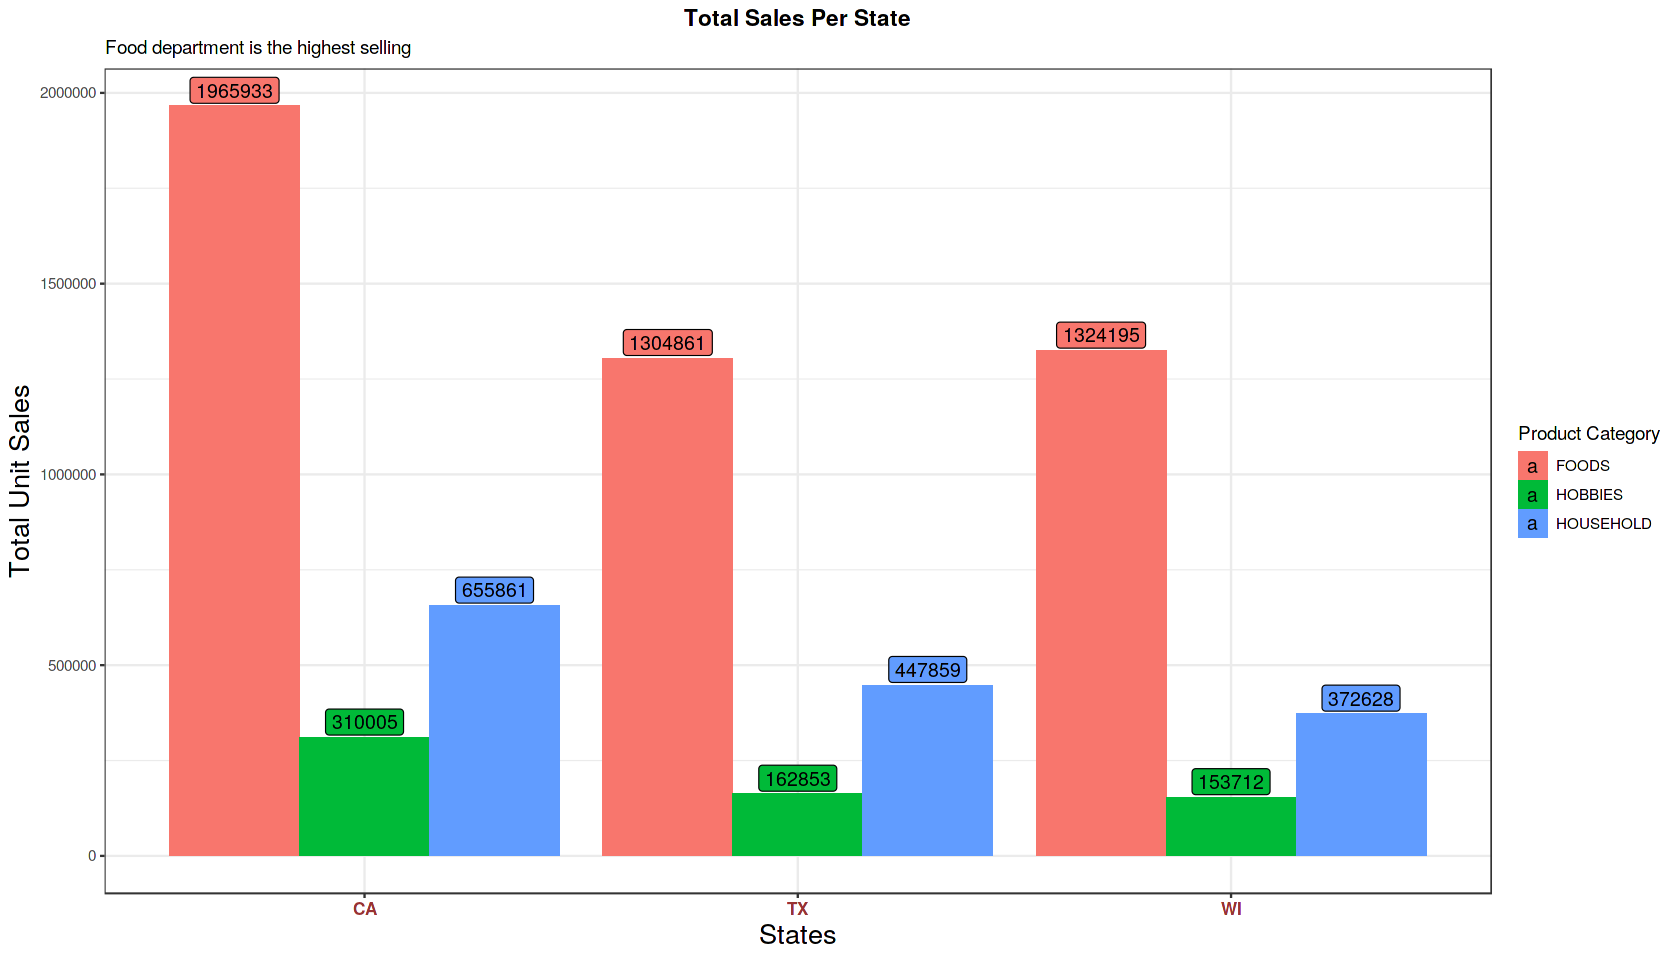

In [12]:
freeram()
suppressMessages({ 
g1<-data %>% select(state_id,cat_id,Unit_Sales)%>% 
  group_by(state_id,cat_id) %>% 
  summarise(sales = sum(Unit_Sales)) %>% ggplot(aes(x = state_id,y=sales, fill = cat_id))+
        geom_bar(stat='identity',position=position_dodge())  +
          geom_label(aes(label=sales), size=4,position=position_dodge(width=0.9),vjust=-0.1)+
        labs(x="States",y="Total Unit Sales",title="Total Sales Per State",
             subtitle='Food department is the highest selling',fill = "Product Category") +theme_bw() +
        theme(plot.title = element_text(hjust = 0.5, face = "bold"),axis.text.x=element_text(face="bold", color="#993333", size=10),
             axis.title.x = element_text(size = 16),
             axis.title.y = element_text(size = 16))})
g1
#ggsave("g1.png")

As expected, the Food department recorded the highest sales in all 3 states. Also, It can be seen from fig 2 that California had the highest sales overall. Having 4 stores and more population might be the reason. Surprisingly, Wisconsin even with low population density when compared to Texas recorded equal sales. To get better understanding sales for each store are plotted.

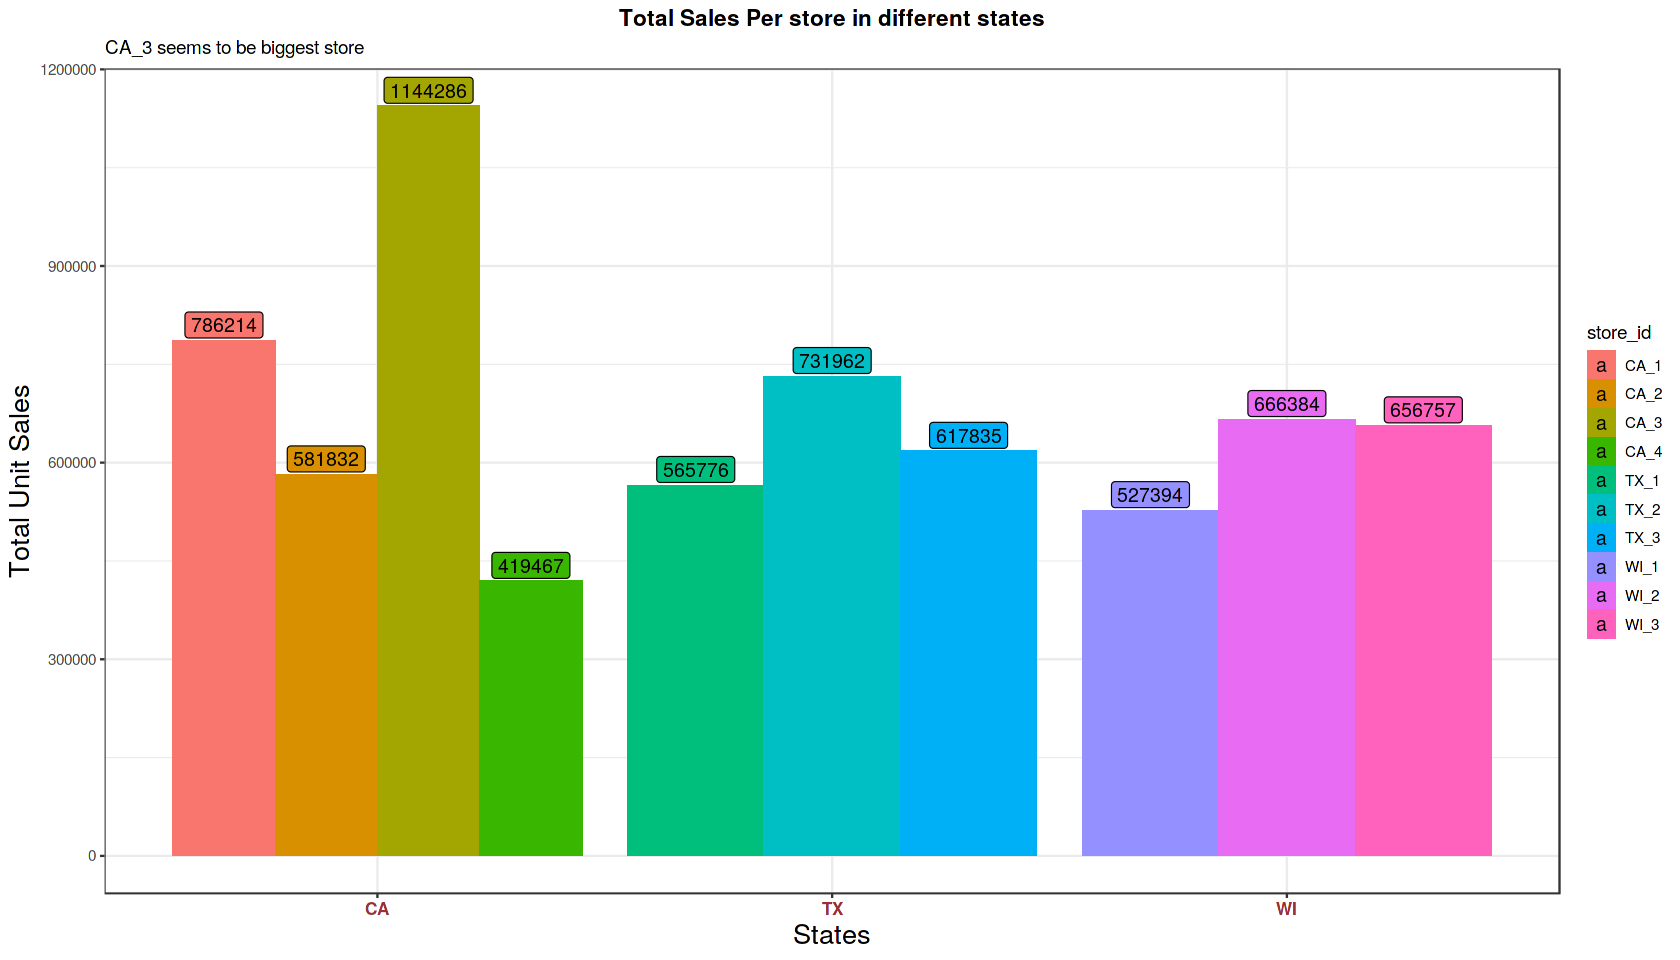

In [13]:
suppressMessages({ 
freeram()
options(repr.plot.width = 14, repr.plot.height = 8)
g2<-data %>% select(state_id,store_id,Unit_Sales)%>% 
  group_by(state_id,store_id) %>% 
  summarise(sales = sum(Unit_Sales)) %>% ggplot(aes(x = state_id,y=sales, fill = store_id))+
        geom_bar(stat='identity',position=position_dodge(width=0.9))  + 
        geom_label(aes(label=sales), size=4,position=position_dodge(width=0.9),vjust=-0.1)+
        labs(x="States",y="Total Unit Sales",title="Total Sales Per store in different states",
            subtitle='CA_3 seems to be biggest store') + theme_bw() +
        theme(plot.title = element_text(hjust = 0.5, face = "bold"),axis.text.x=element_text(face="bold", color="#993333", size=10),
             axis.title.x = element_text(size = 16),
             axis.title.y = element_text(size = 16)) })
g2
#ggsave("g2.png")


Since sales are almost double for CA_3 when compared with other stores. The CA_3 may be a bigger store. The population density and median income also affect these sales.
Now we have an idea about how sales are impacted by a different location, now let’s explore the individual department for insights

### Exploring price & product category
This section aims to answer:
1. How many different products are available in each department?
2. What is the mean price of all the available products across different states?
3. Which department has the highest and least sales?

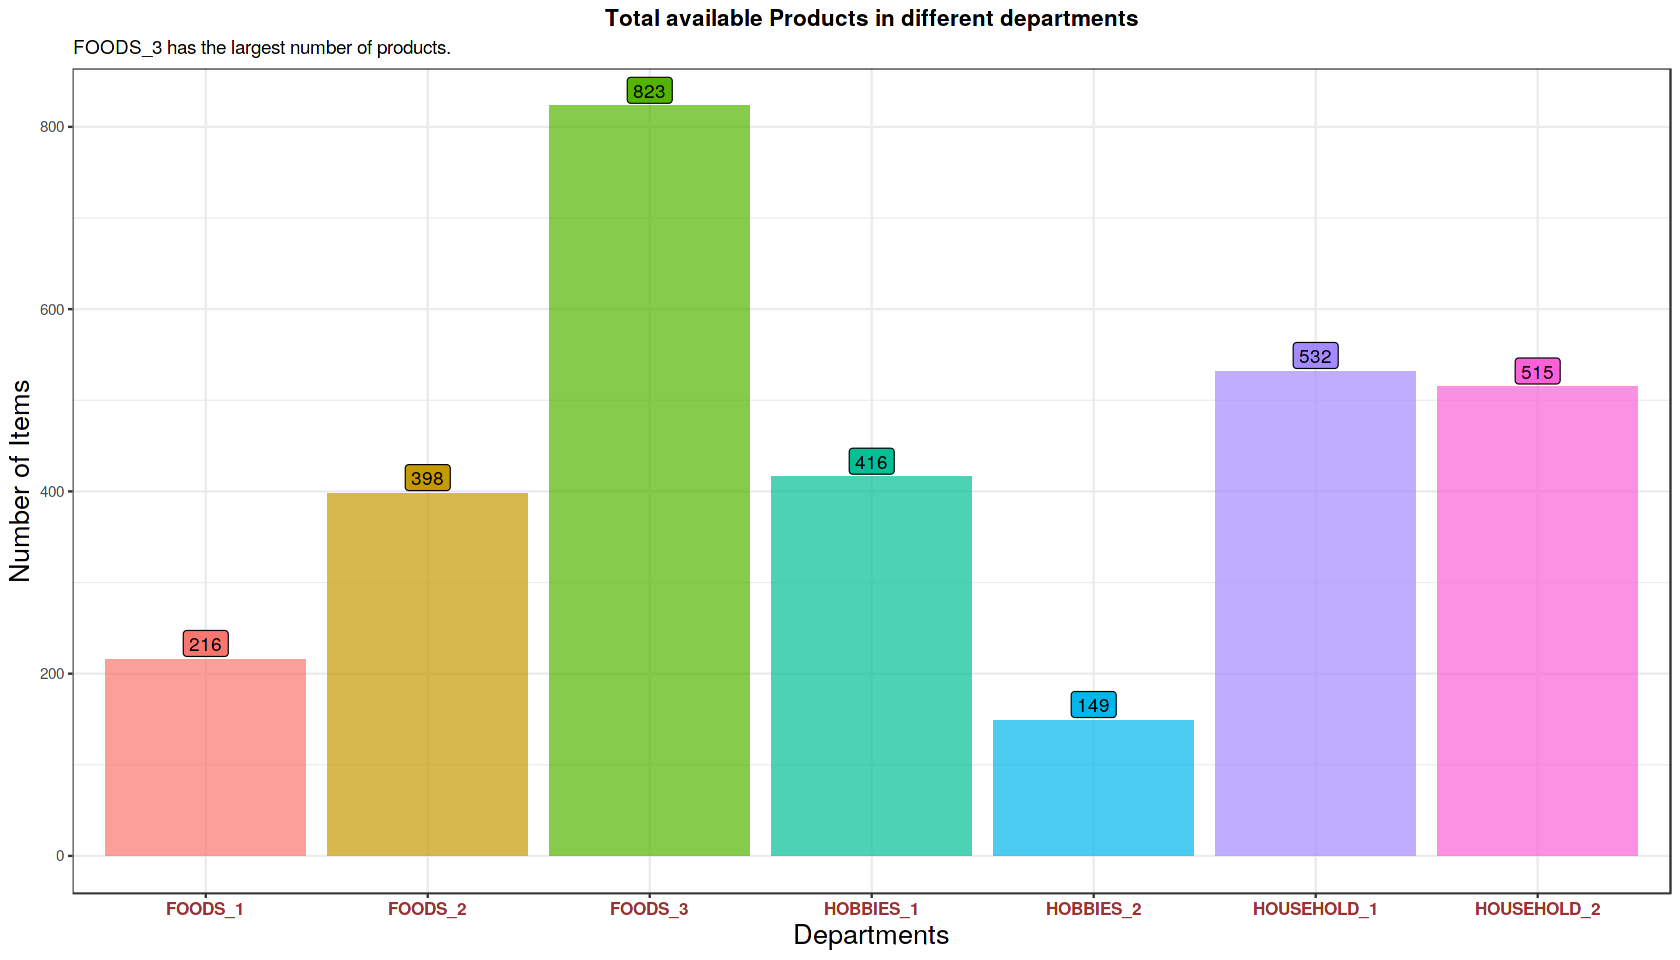

In [14]:
suppressMessages({ g3<-data %>% group_by(dept_id) %>% dplyr::count(item_id) %>% summarise(n_items = length(item_id))%>%
  ggplot(aes(x = dept_id, y = n_items, fill = dept_id))+
  geom_bar(stat = "identity", alpha = 0.7)+
  geom_label(aes(label = n_items), vjust = -0.1, show.legend = F)+theme_bw()+
  labs(x='Departments', y = "Number of Items", title = "Total available Products in different departments",
       subtitle = "FOODS_3 has the largest number of products.")+
        theme(plot.title = element_text(hjust = 0.5, face = "bold"),axis.text.x=element_text(face="bold", color="#993333", size=10),
             axis.title.x = element_text(size = 16),
             axis.title.y = element_text(size = 16),legend.position = "none")})
g3
#ggsave("g3.png")

The number of available products is more in the Food_3 department. So Food 3 department may consist of daily consumed food products like milk etc. Now, let's see whether the price is having any impact on sales or not

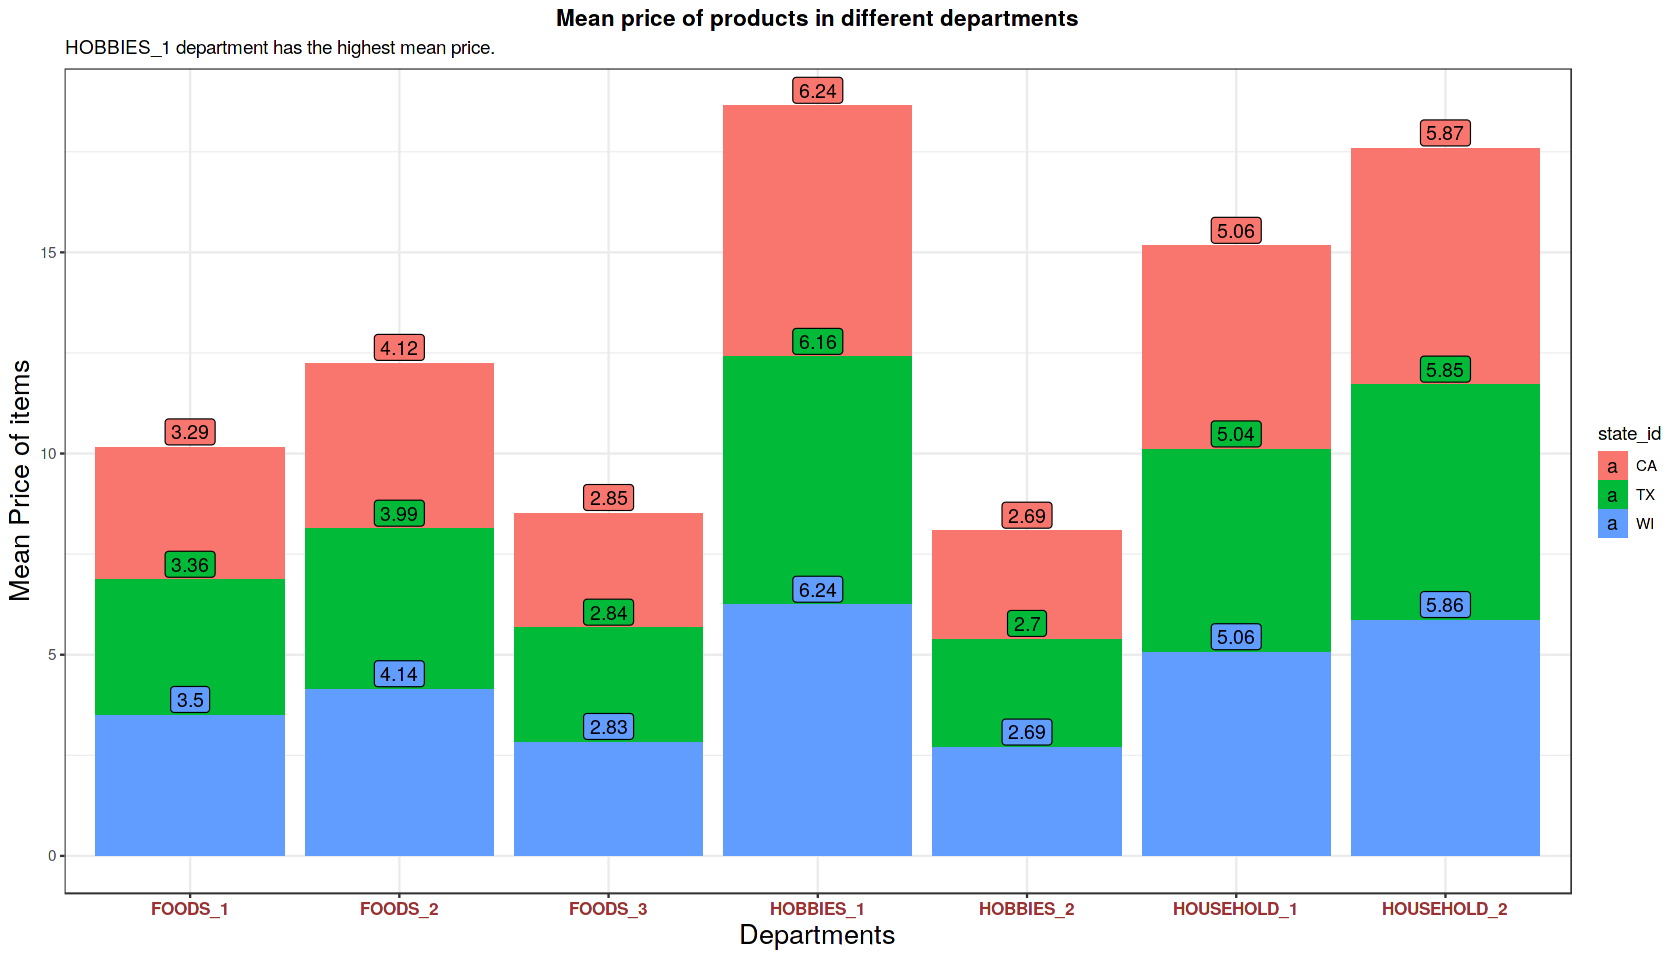

In [15]:
suppressMessages({g4<-data %>%select(dept_id,sell_price,state_id)%>%group_by(dept_id,state_id) %>% summarise(price_mean = mean(sell_price,na.rm=TRUE))%>%
  ggplot(aes(x = dept_id, y = round(price_mean,2), fill = state_id))+geom_bar(stat='identity',position='stack')+
geom_label(aes(label=round(price_mean,2)),position='stack',size=4,vjust=-0.1)+ theme_bw() +
  labs(x='Departments', y = "Mean Price of items", title = "Mean price of products in different departments",
       subtitle = "HOBBIES_1 department has the highest mean price.")+
        theme(plot.title = element_text(hjust = 0.5, face = "bold"),axis.text.x=element_text(face="bold", color="#993333", size=10),
             axis.title.x = element_text(size = 16),
             axis.title.y = element_text(size = 16))})
g4
#ggsave("g4.png")

It can be seen that the Hobbies_1 department has the highest mean price and Food 3 being the lowest. Despite, California state population having more mean annual household income when compared to texas and Wisconsin, the mean price is almost similar for 3 states which makes the products more affordable for the California state population. Now let's see state wise sales for each product.

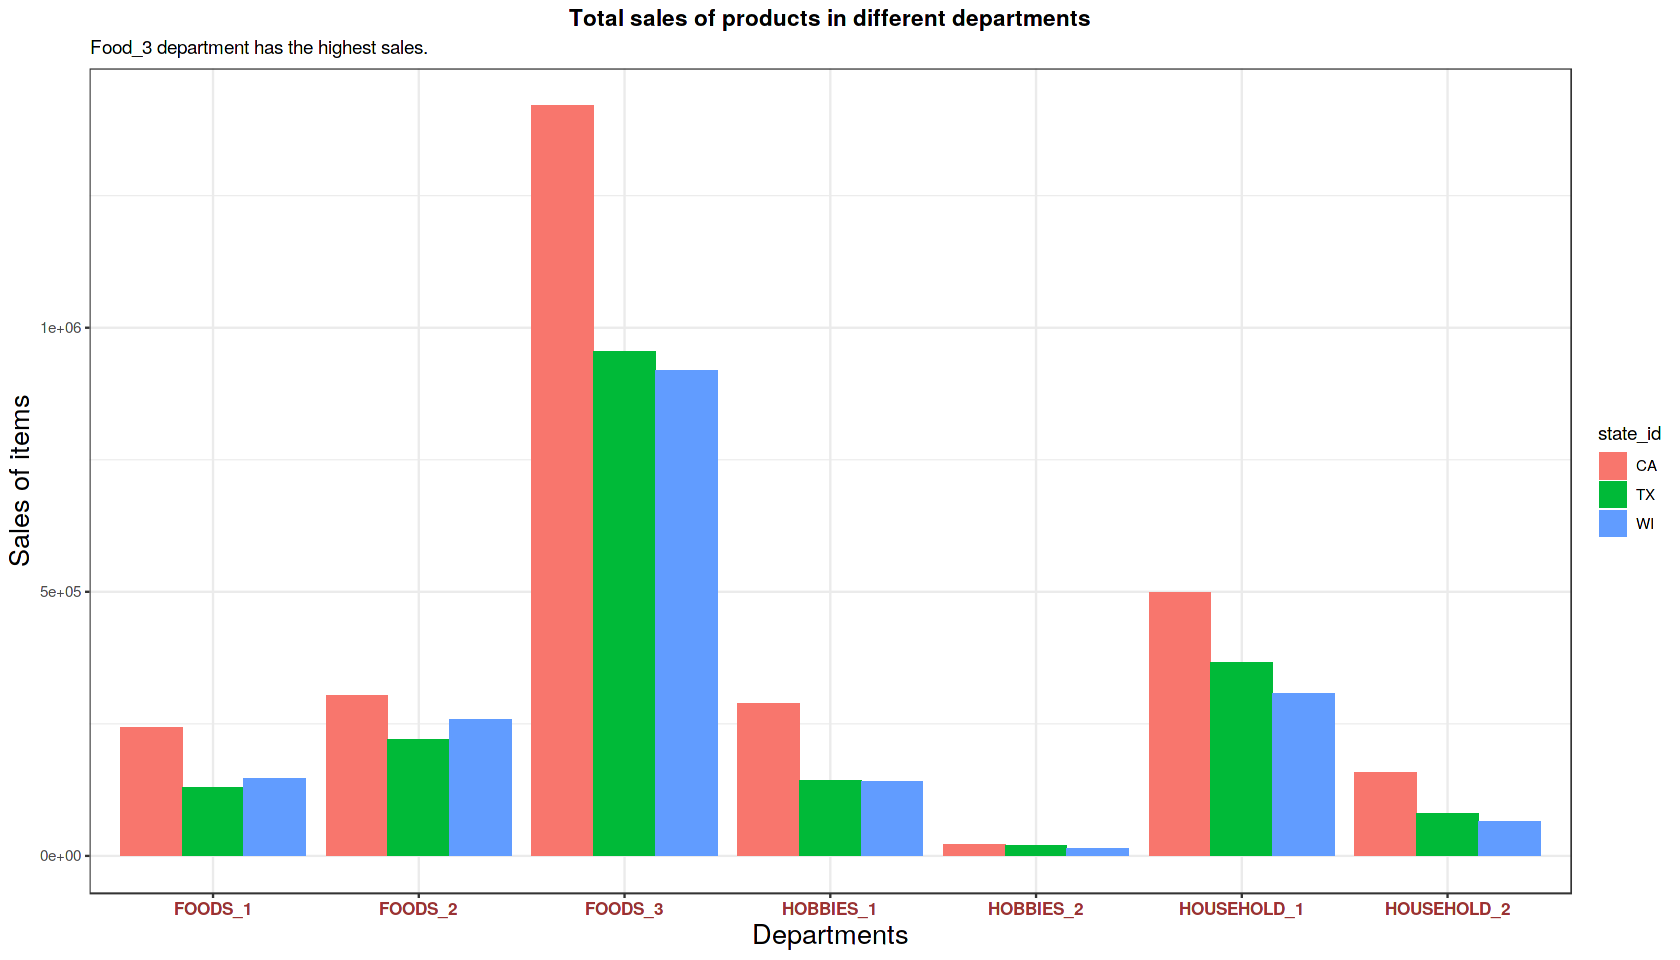

In [16]:
suppressMessages({g11<-data %>%select(dept_id,Unit_Sales,state_id)%>%group_by(dept_id,state_id) %>% summarise(price_mean = sum(Unit_Sales,na.rm=TRUE))%>%
  ggplot(aes(x = dept_id, y = round(price_mean,2), fill = state_id))+geom_bar(stat='identity',position=position_dodge(width=0.9))+ theme_bw() +
  labs(x='Departments', y = "Sales of items", title = "Total sales of products in different departments",
       subtitle = "Food_3 department has the highest sales.")+
        theme(plot.title = element_text(hjust = 0.5, face = "bold"),axis.text.x=element_text(face="bold", color="#993333", size=10),
             axis.title.x = element_text(size = 16),
             axis.title.y = element_text(size = 16))})
g11
#ggsave("g11.png")

Here, the Food 3 department with the lowest mean price had the highest sales. One more interesting thing to note here is despite, Hobbies 1 having the highest mean price and almost double when compared with Hobbies 2, the sales are high for Hobbies 1. HouseHold 1 sales are high. This may indicate that this product department holds the everyday essential items like soaps and detergents.
As observed earlier California state is having more sales followed by Texas and Wisconsin. The expectation being the Food 1and Food 2 categories where Wisconsin sales are higher when compared with texas. So, it can be assumed Wisconsin state population had a liking towards Food 1 and Food 2 departments.
We were able to prove a few thesis statements related to product price, location, and product category. Now, let's jump into Time series analysis to see how different weekdays, months, and events are affecting sales.

### Time series analysis
This section aims to answer:
1. The daily seasonality trend of total sales
2. Which month had the highest and lowest sales?
3. Which weekday do people prefer to grocery shopping in different states?

The time series for all years is plotted to observe the seasonality trend for all 3 states for different departments.

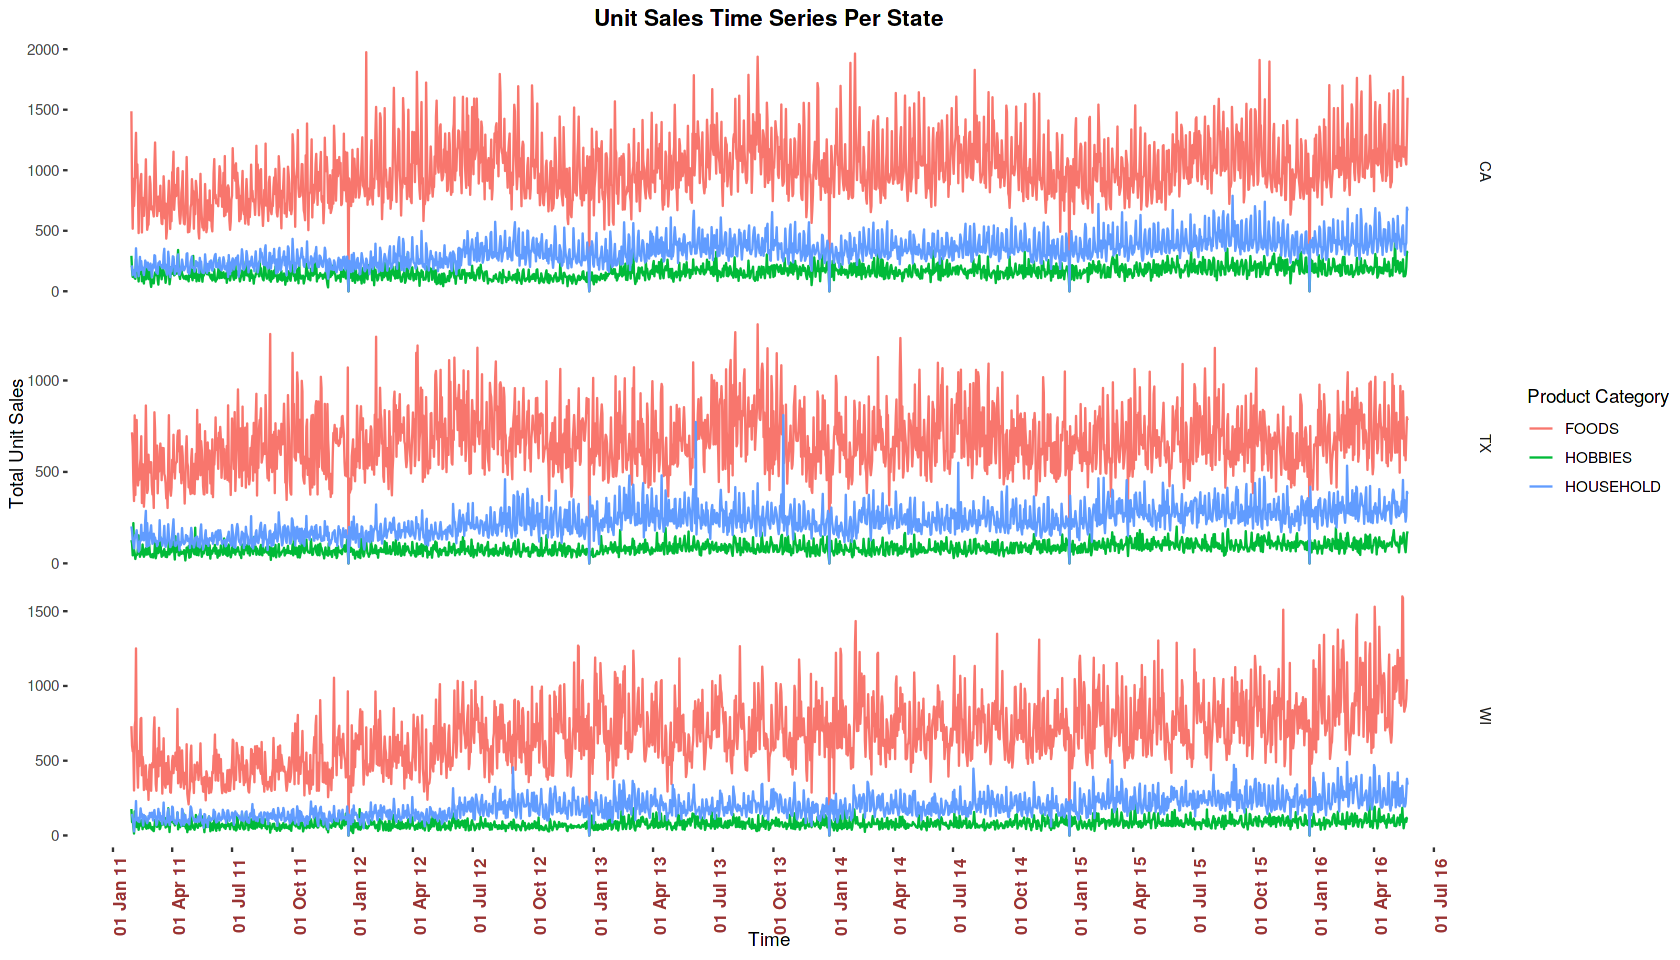

In [17]:
freeram()
## Time Series of Overall Unit Sales
suppressMessages({g5<-ggplot(data=data%>%select(state_id,cat_id,date,Unit_Sales,month,year) %>%
                    group_by(state_id, cat_id, date,month,year) %>% 
                    summarise(sales = sum(Unit_Sales)))+
        geom_line(aes(x = date, y = sales, color = cat_id))+
        scale_colour_discrete("Product Category") + facet_grid(state_id~.,scales="free")+
        labs(x="Time",y="Total Unit Sales",title="Unit Sales Time Series Per State") + theme_tufte() +
        theme(plot.title = element_text(hjust = 0.5, face = "bold"),axis.text.x=element_text(face="bold", color="#993333", 
                           size=10, angle=90))+scale_x_date(date_breaks = "3 month", date_labels = "%d %b %y") })

html1<-ggplotly(g5, dynamicTicks = TRUE)
#htmlwidgets::saveWidget(as_widget(html1),"g5.html")
#ggsave("g5.png")
                
#html1
g5

The seasonality trend follows the same pattern and is parallel for all 3 states. The highest Food being the department with the highest sales followed by Hobbies and Household. To better understand daily trends a heat map was plotted for the year 2015.

In [18]:
suppressMessages({heat<-data %>% select(date,Unit_Sales)%>% 
  tk_augment_timeseries_signature()
#heat$week[heat$month.lbl=="Dec" & heat$week ==1] = 53 

heat <- heat %>% 
filter(year==2015) %>% 
  group_by(month) 
#  mutate(monthweek = 1 + week - min(week))
                 })

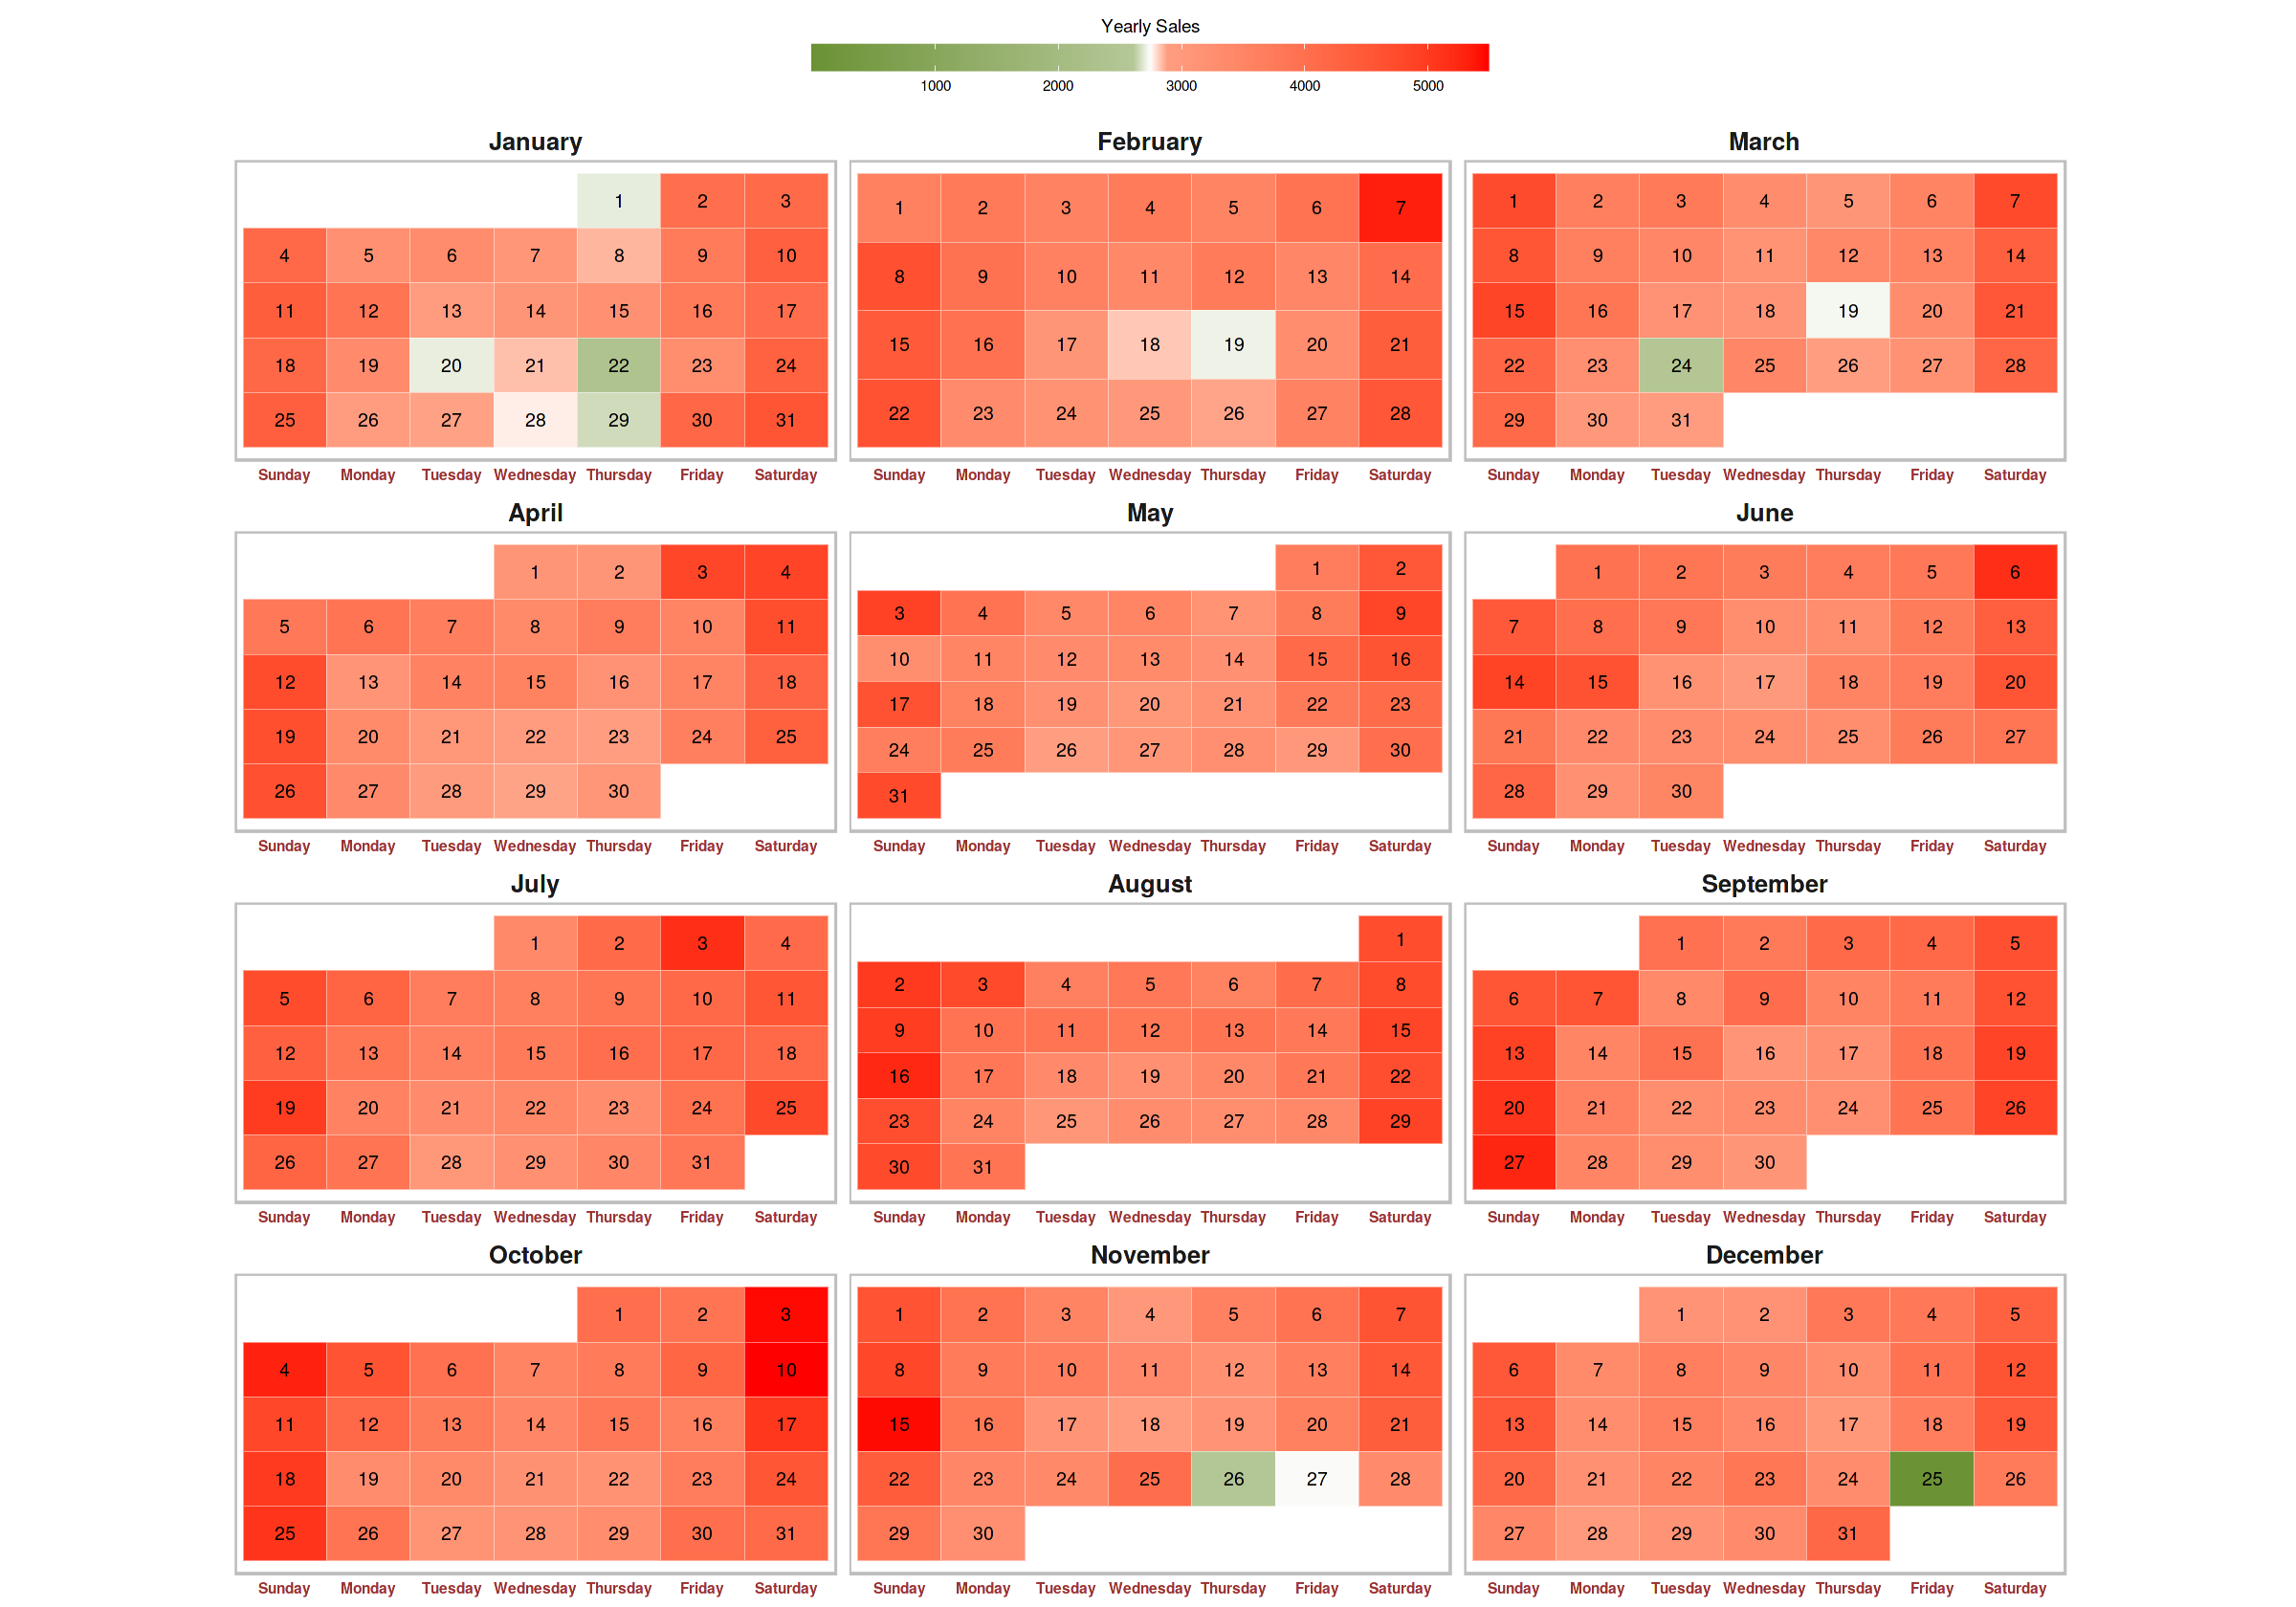

In [19]:
suppressMessages({options(repr.plot.width = 20, repr.plot.height = 14)
g16<-heat %>% group_by(mweek,wday.lbl,wday,month.lbl,day) %>% 
  summarise(sales = sum(Unit_Sales,na.rm=TRUE)) %>%  
  ggplot(aes(wday.lbl,mweek,fill = sales)) +scale_y_reverse()+
  geom_tile(colour='white')  + geom_text(aes(label=day),size=4)+
  theme(aspect.ratio = 1/2,
        legend.position = "top",
        legend.key.width = unit(3, "cm"),
        axis.title.x = element_blank(),
        axis.title.y = element_blank(),
        axis.text.y = element_blank(),
        panel.grid = element_blank(),
        axis.ticks = element_blank(),
        axis.text.x=element_text(face="bold", color="#993333", size=9),
        panel.background = element_blank(),
        legend.title.align = 0.5,
        strip.background = element_blank(),
        strip.text = element_text(face = "bold", size = 15),
        panel.border = element_rect(colour = "grey", fill=NA, size=1),
        plot.title = element_text(hjust = 0.5, size = 21, face = "bold",
                                  margin = margin(0,0,0.5,0, unit = "cm"))) +
          scale_fill_gradientn(colours = c("#6b9235", "white", "red"),
                       values = scales::rescale(c(-1, -0.05, 0, 0.05, 1)), 
                       name = "Yearly Sales",
                       guide = guide_colorbar(title.position = "top", 
                                              direction = "horizontal")) +
      facet_wrap(~month.lbl, nrow = 4, ncol = 3, scales = "free") })
g16
#ggsave('g16.png',width=15,height=25)

It appears that Walmart is closed on Christmas. It can be seen that sales are very less on some days like New year and Thanksgiving days. This may be due to reduced working hours on Festival days. Also, sales are relatively high on weekends in comparison to normal days.

### Monthly Sales Trend

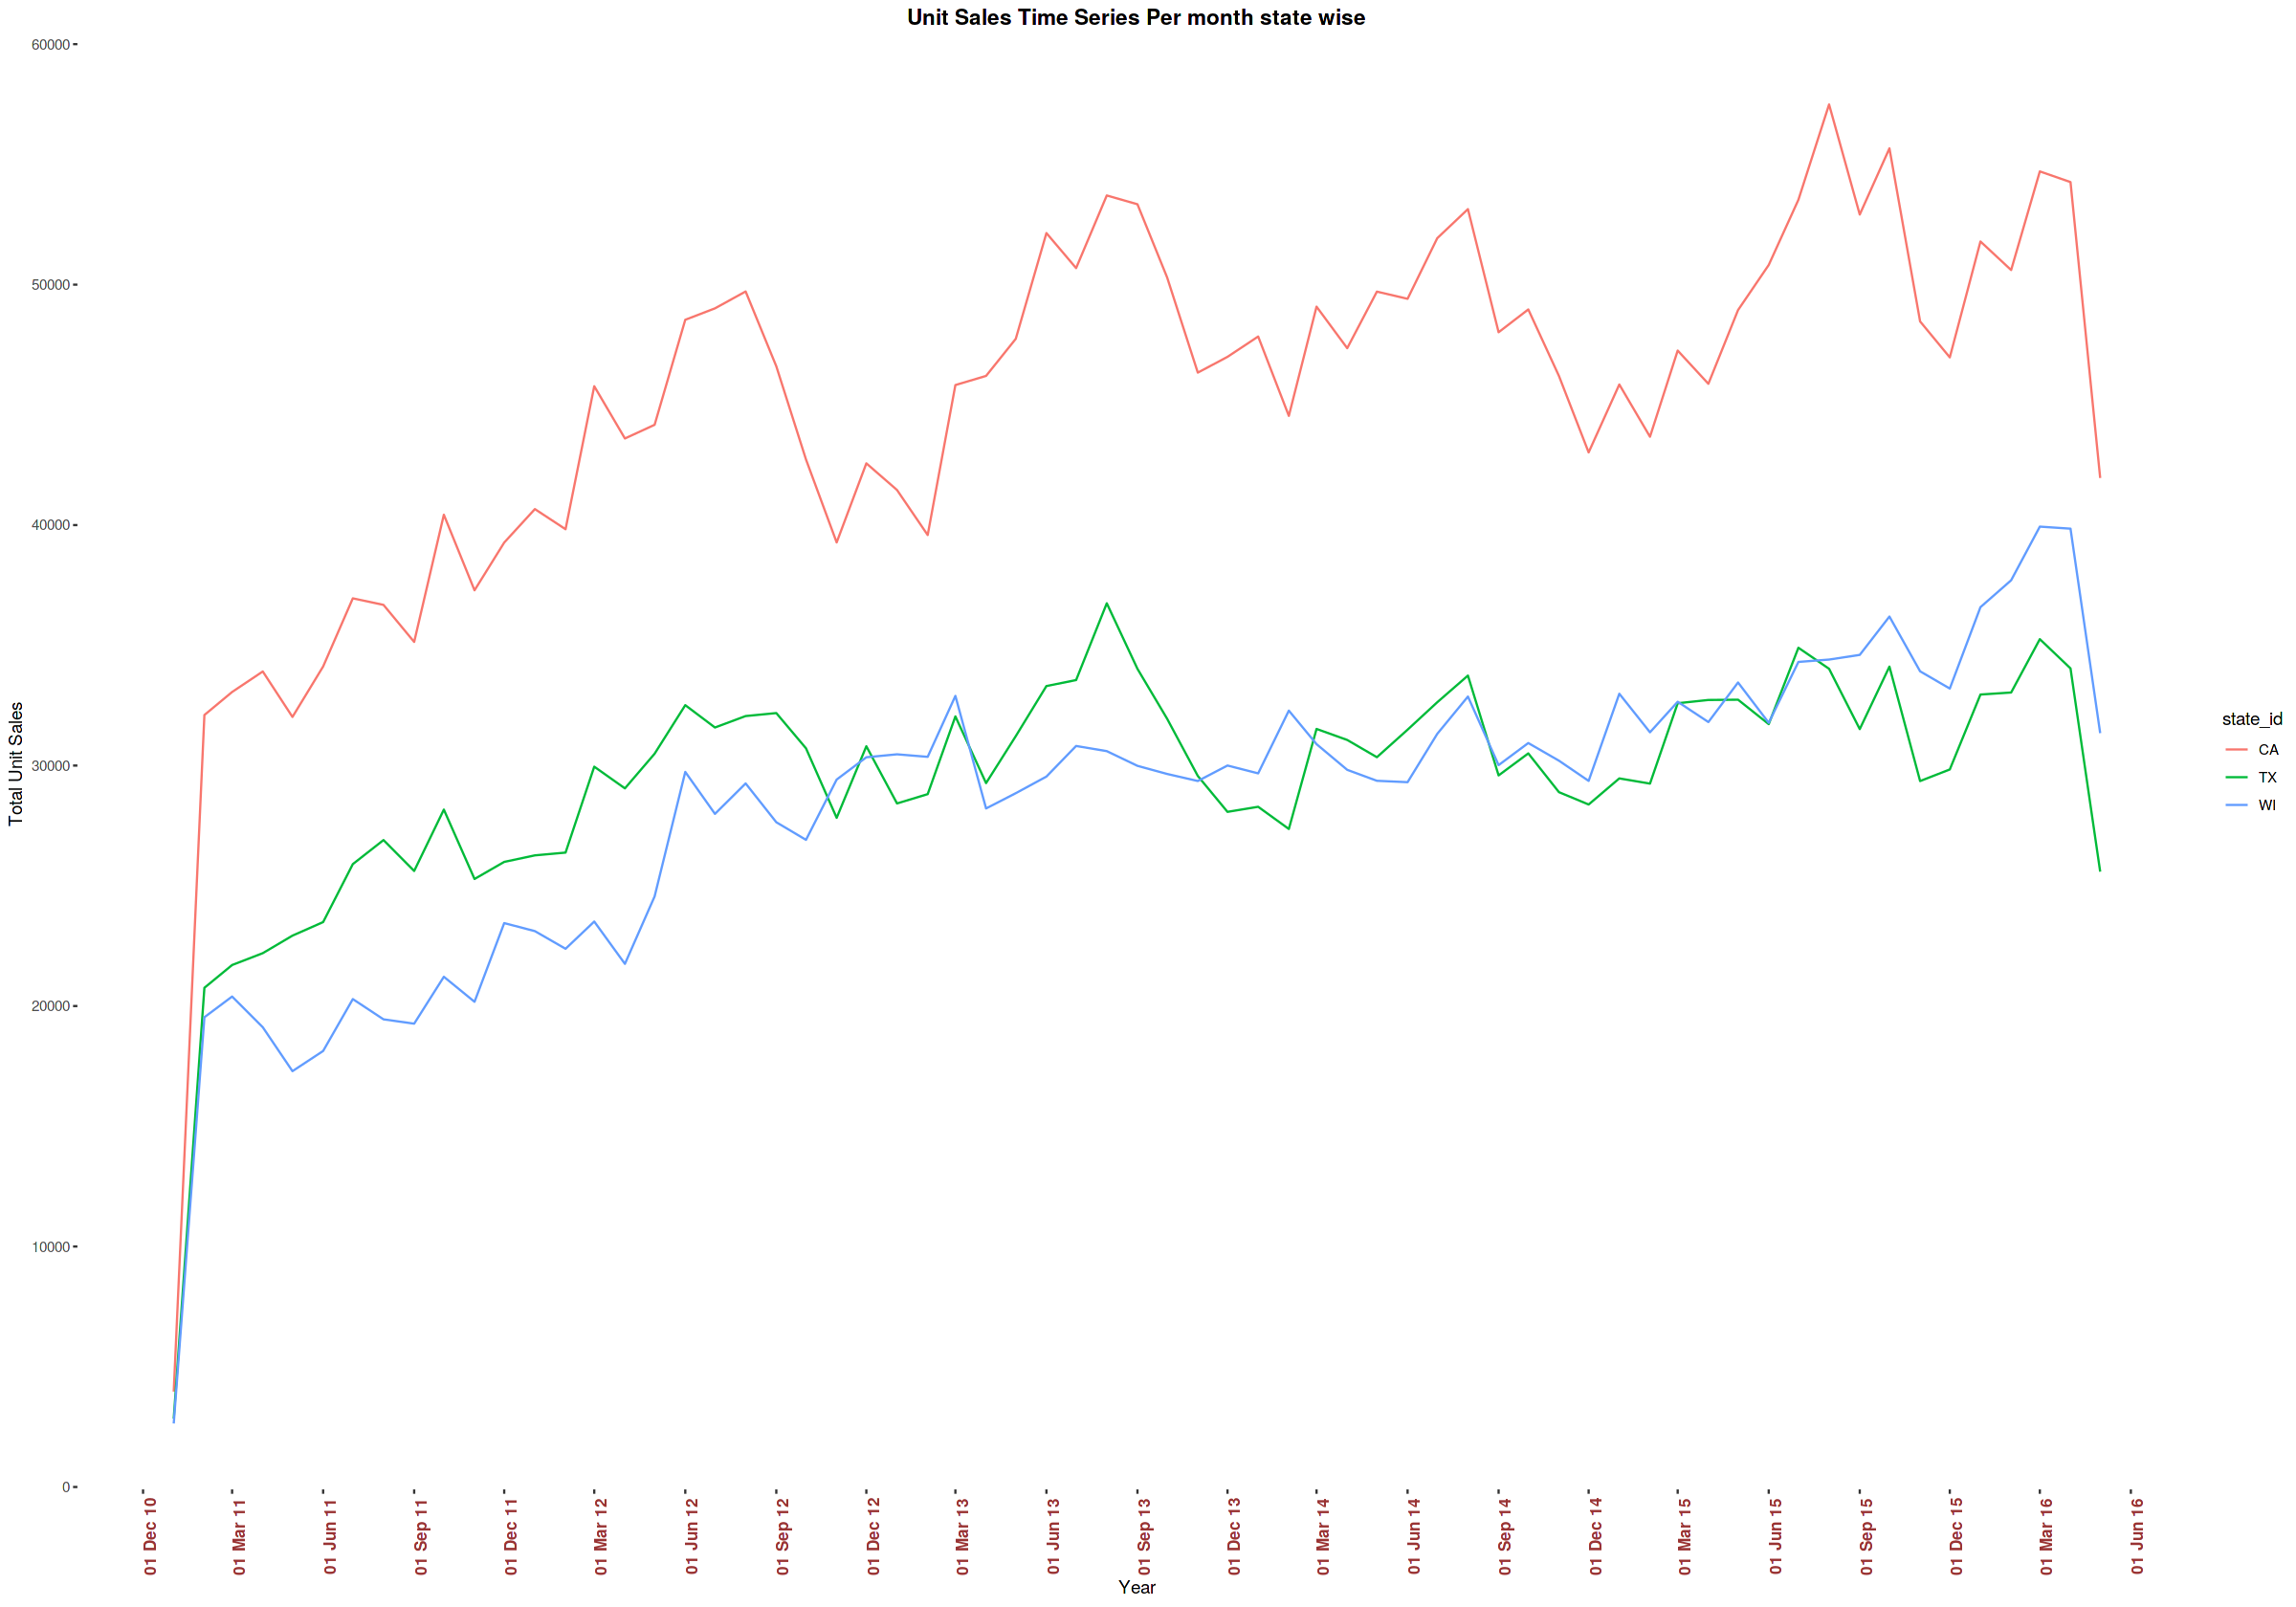

In [20]:
suppressMessages({
g6 <- data %>% select(state_id,date,Unit_Sales)%>% 
  group_by(month=floor_date(date, "month"),state_id) %>% 
  summarise(sales = sum(Unit_Sales))%>%dplyr::filter('sales' !=0 ) %>% 
  ggplot(aes(month, sales,col=state_id)) +
  geom_line() +
  theme_tufte() +
        labs(x="Year",y="Total Unit Sales",title="Unit Sales Time Series Per month state wise") + theme_tufte() +
        theme(plot.title = element_text(hjust = 0.5, face = "bold"),axis.text.x=element_text(face="bold", color="#993333", 
                           size=10, angle=90))+scale_x_date(date_breaks = "3 month", date_labels = "%d %b %y")
    })

html2<-ggplotly(g6, dynamicTicks = TRUE)
#htmlwidgets::saveWidget(as_widget(html1),"g6.html")
#ggsave("g6.png")
#html2
g6
freeram()

It is surprising to see the same trend across all 3 states for 5 years. It can be seen that total sales are increasing every year. This trend is due to the introduction of new products every year at Walmart. Also, the trend pattern for increase or decrease is almost similar for every year. To better understand the monthly trends all monthly sales are grouped for a year and the graph is plotted.

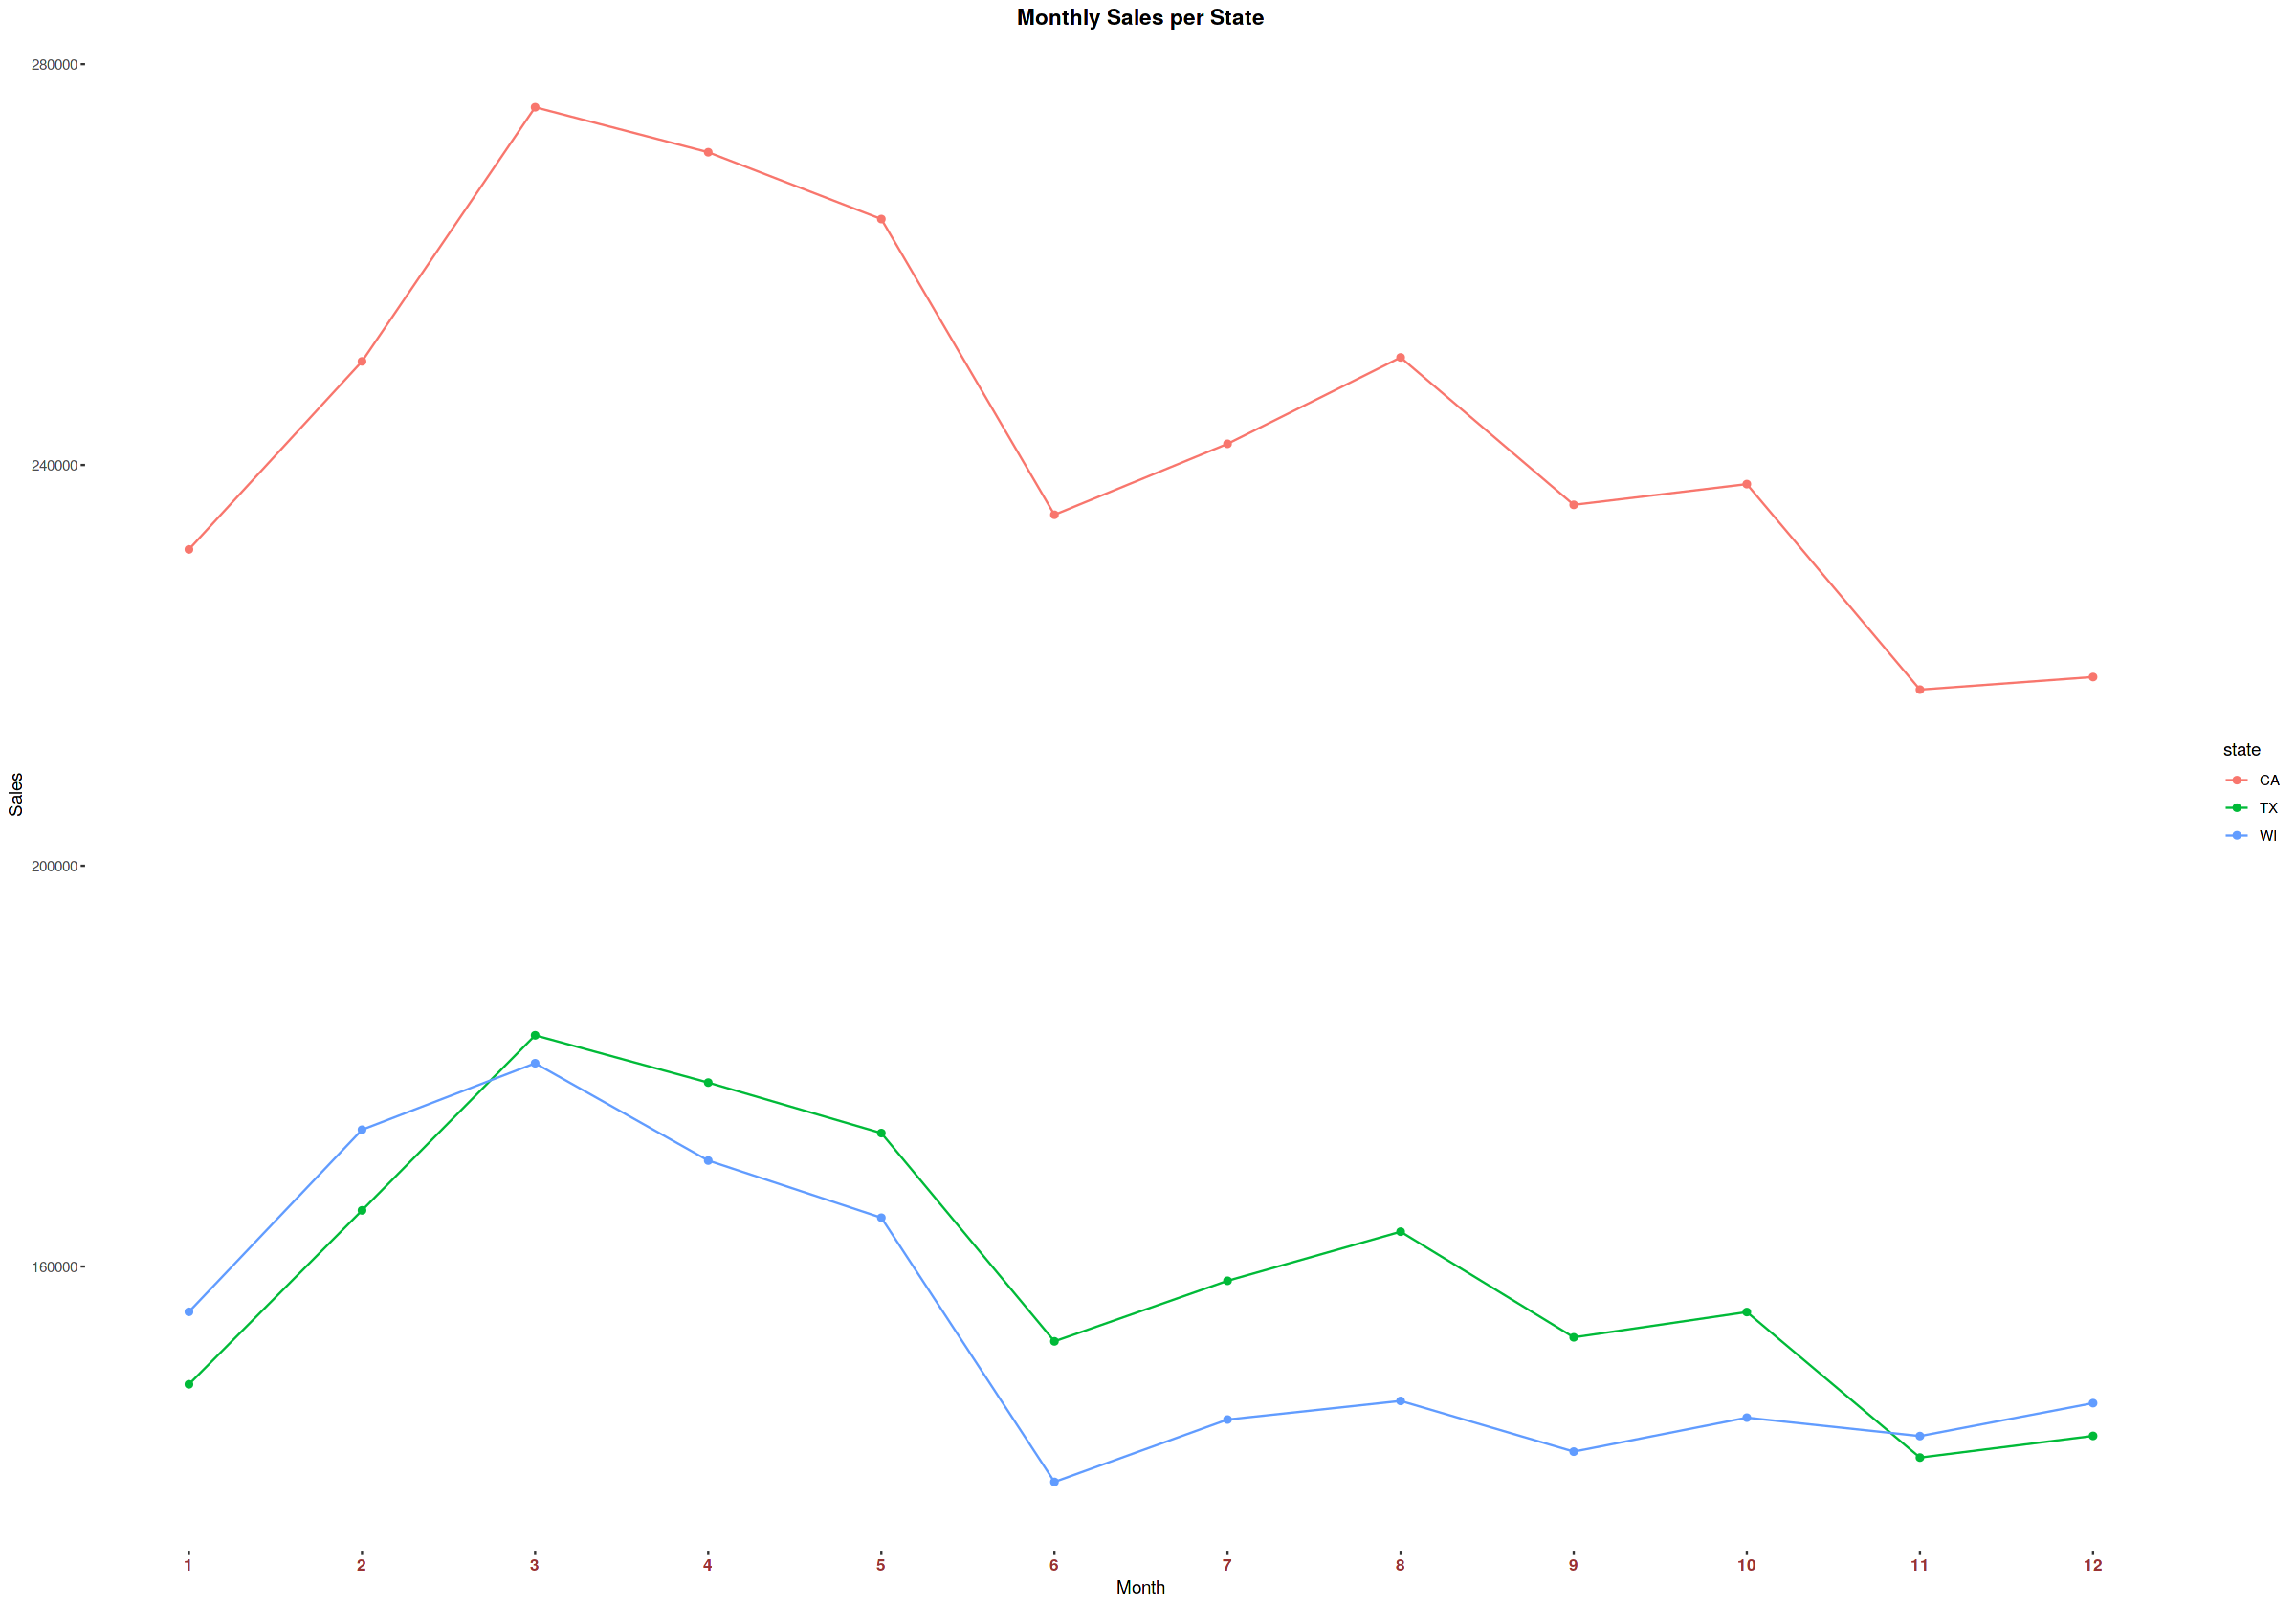

In [21]:

suppressMessages({
    
options( warn = -1 )
    
g10<-data %>% select(date,state_id,cat_id,Unit_Sales)%>% mutate(month = month(date))%>%
  group_by(month,state_id) %>% 
  summarise(sales = sum(Unit_Sales))%>% 
  ggplot(aes(factor(month,levels=1:12), sales,group=state_id,color=state_id)) +
  geom_line()+geom_point()+
  theme_tufte() +scale_colour_discrete("state")+
  labs(x = "Month", y = "Sales", title = "Monthly Sales per State")+
        theme(plot.title = element_text(hjust = 0.5, face = "bold"),axis.text.x=element_text(face="bold", color="#993333", size=10))
freeram()})
html6<-ggplotly(g10)
#htmlwidgets::saveWidget(as_widget(html5),"g10.html")
#ggsave("g10.png")
#html6
#ggplotly(g10)
g10
          

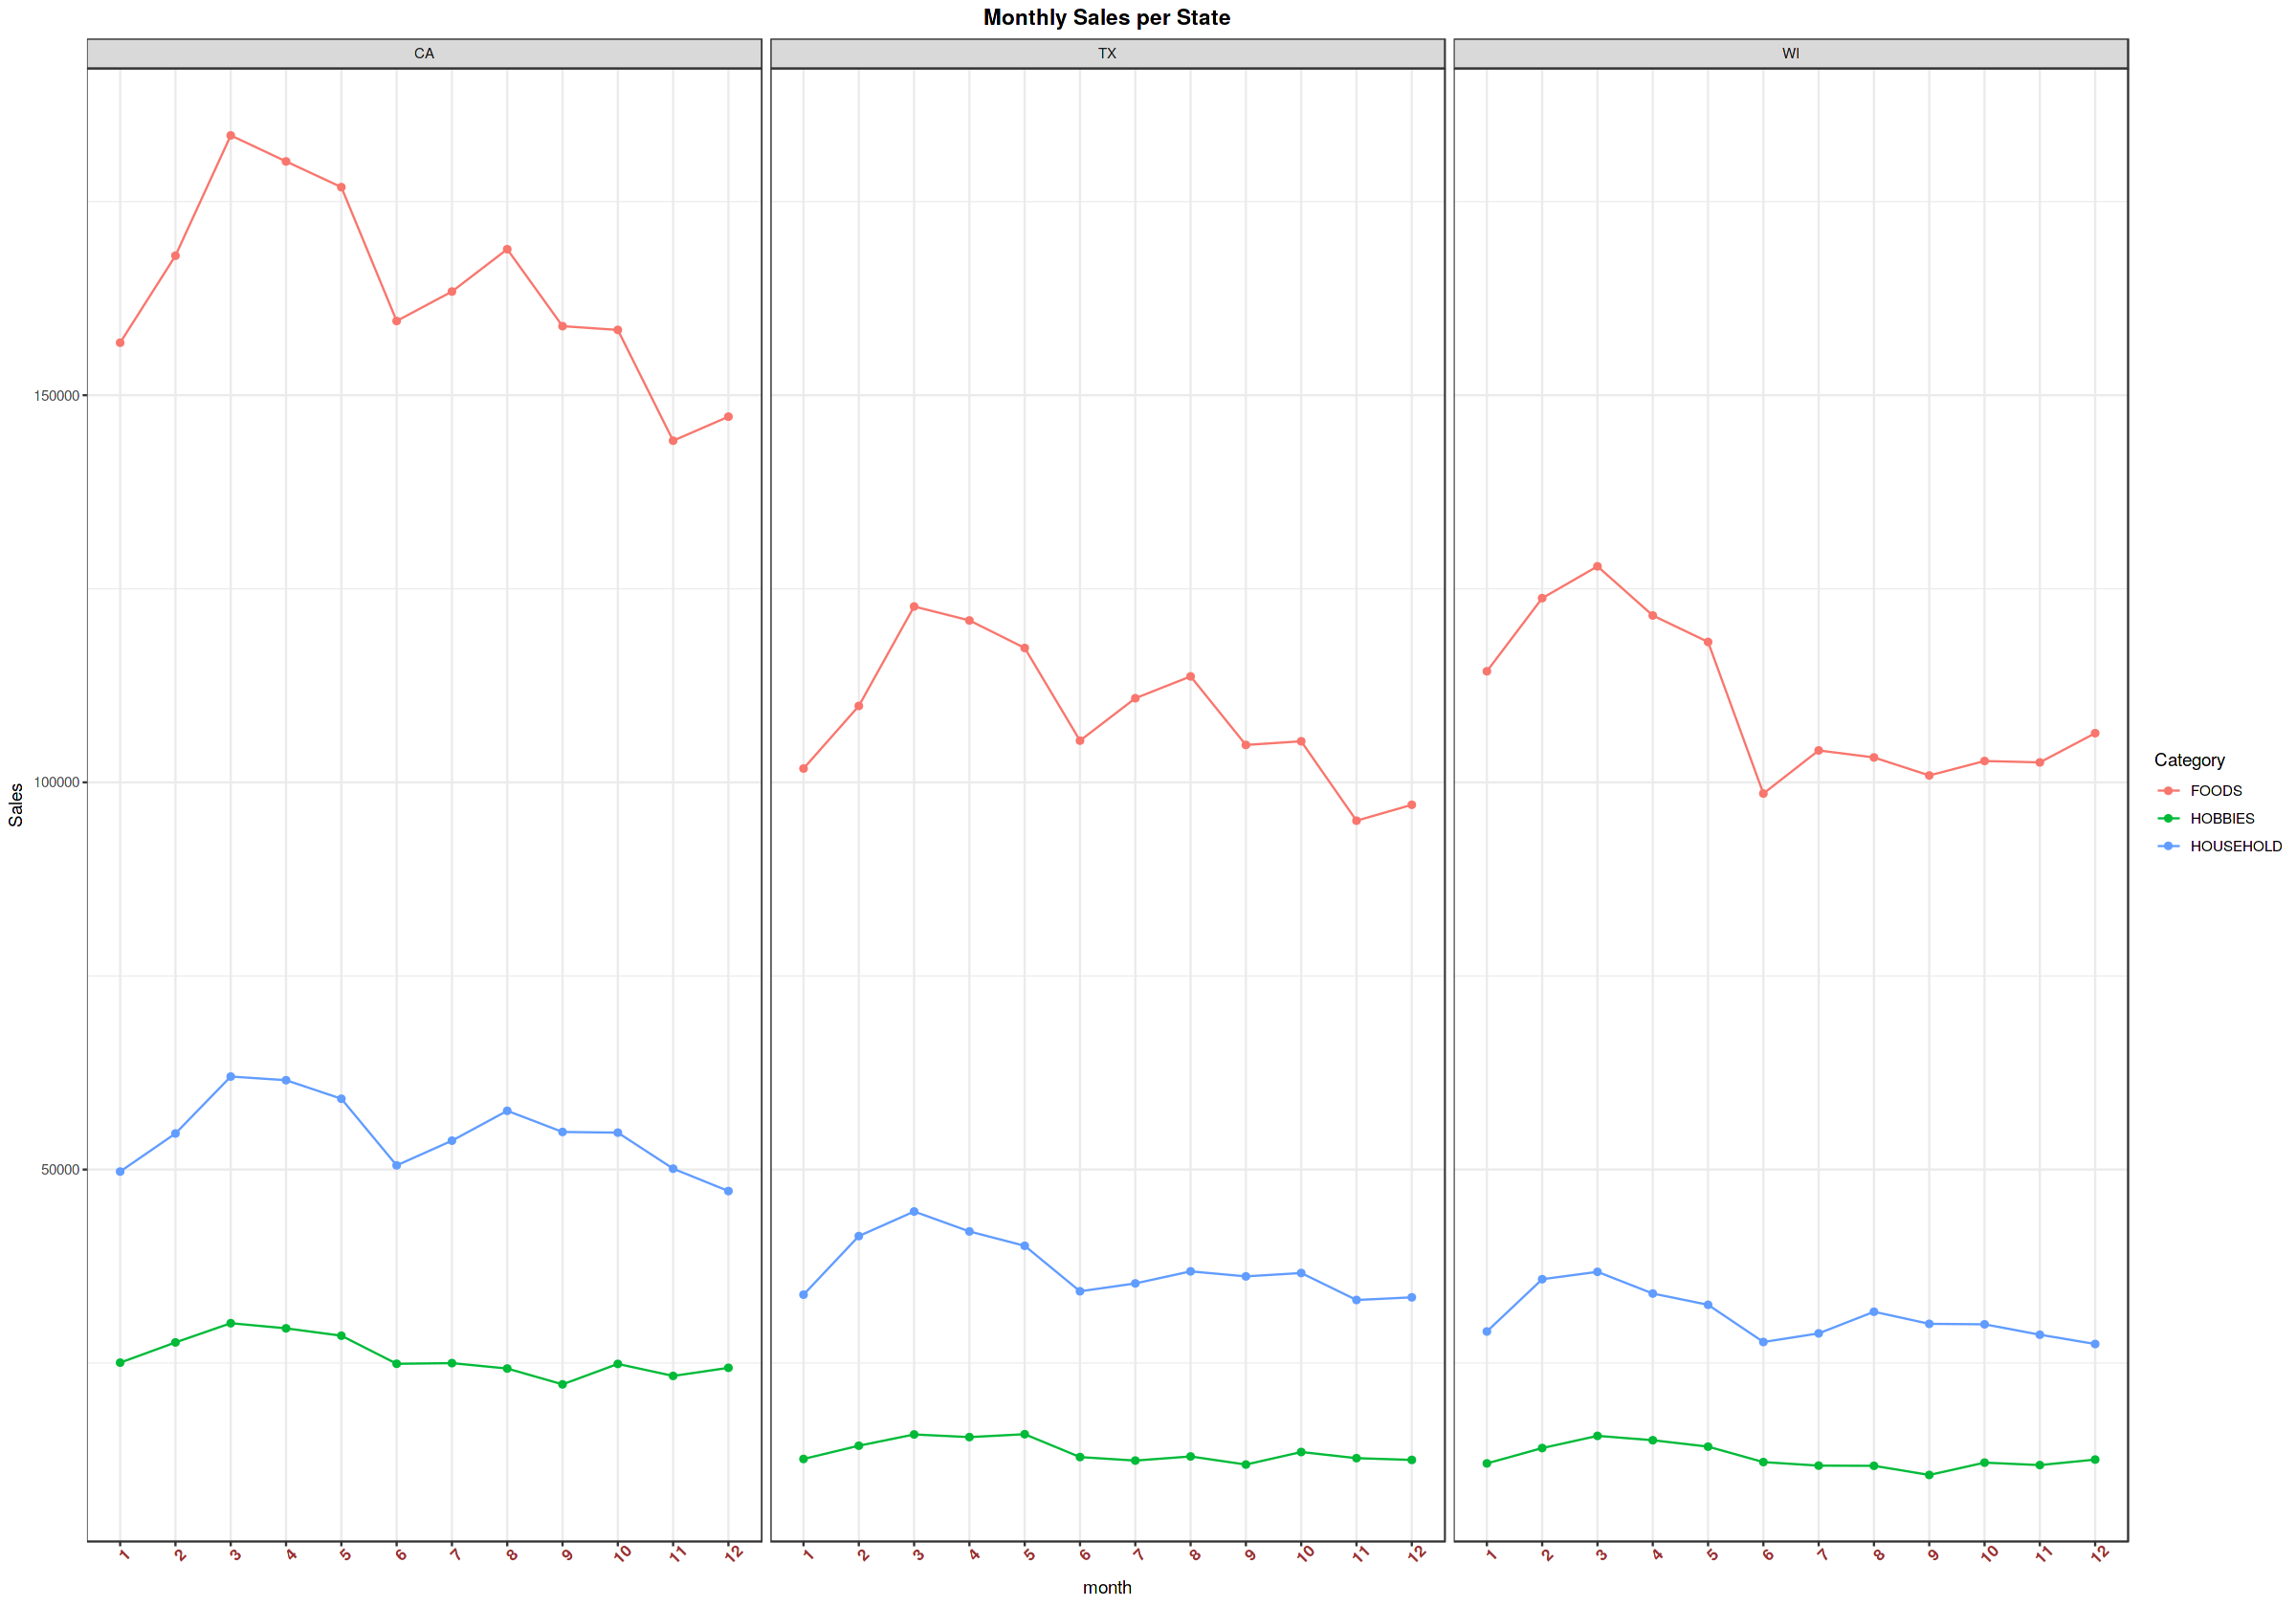

In [22]:
suppressMessages({g12<-data %>% select(date,state_id,cat_id,Unit_Sales)%>% mutate(month = month(date))%>%
  group_by(month,state_id,cat_id) %>% 
  summarise(sales = sum(Unit_Sales))%>% 
  ggplot(aes(factor(month,levels=1:12), sales,group=cat_id,color=cat_id)) +
  geom_line()+geom_point()+facet_grid(~state_id)+
  theme_bw() +scale_colour_discrete("Category")+
  labs(x = "month", y = "Sales", title = "Monthly Sales per State")+
        theme(plot.title = element_text(hjust = 0.5, face = "bold"),axis.text.x=element_text(face="bold", color="#993333", size=10, angle=45))
freeram()})
#ggplotly(g12)
html7<-ggplotly(g12)
#htmlwidgets::saveWidget(as_widget(html5),"g12.html")
#ggsave("g12.png")
#html7
freeram()
g12
         


It can be observed that the sales were increasing every year and are at a peak in March. After March, there is a decrease in sales till May and plummeted in June recording the lowest sales every year. After, June there is a gradual increase in sales for two months, before dropping further until November.

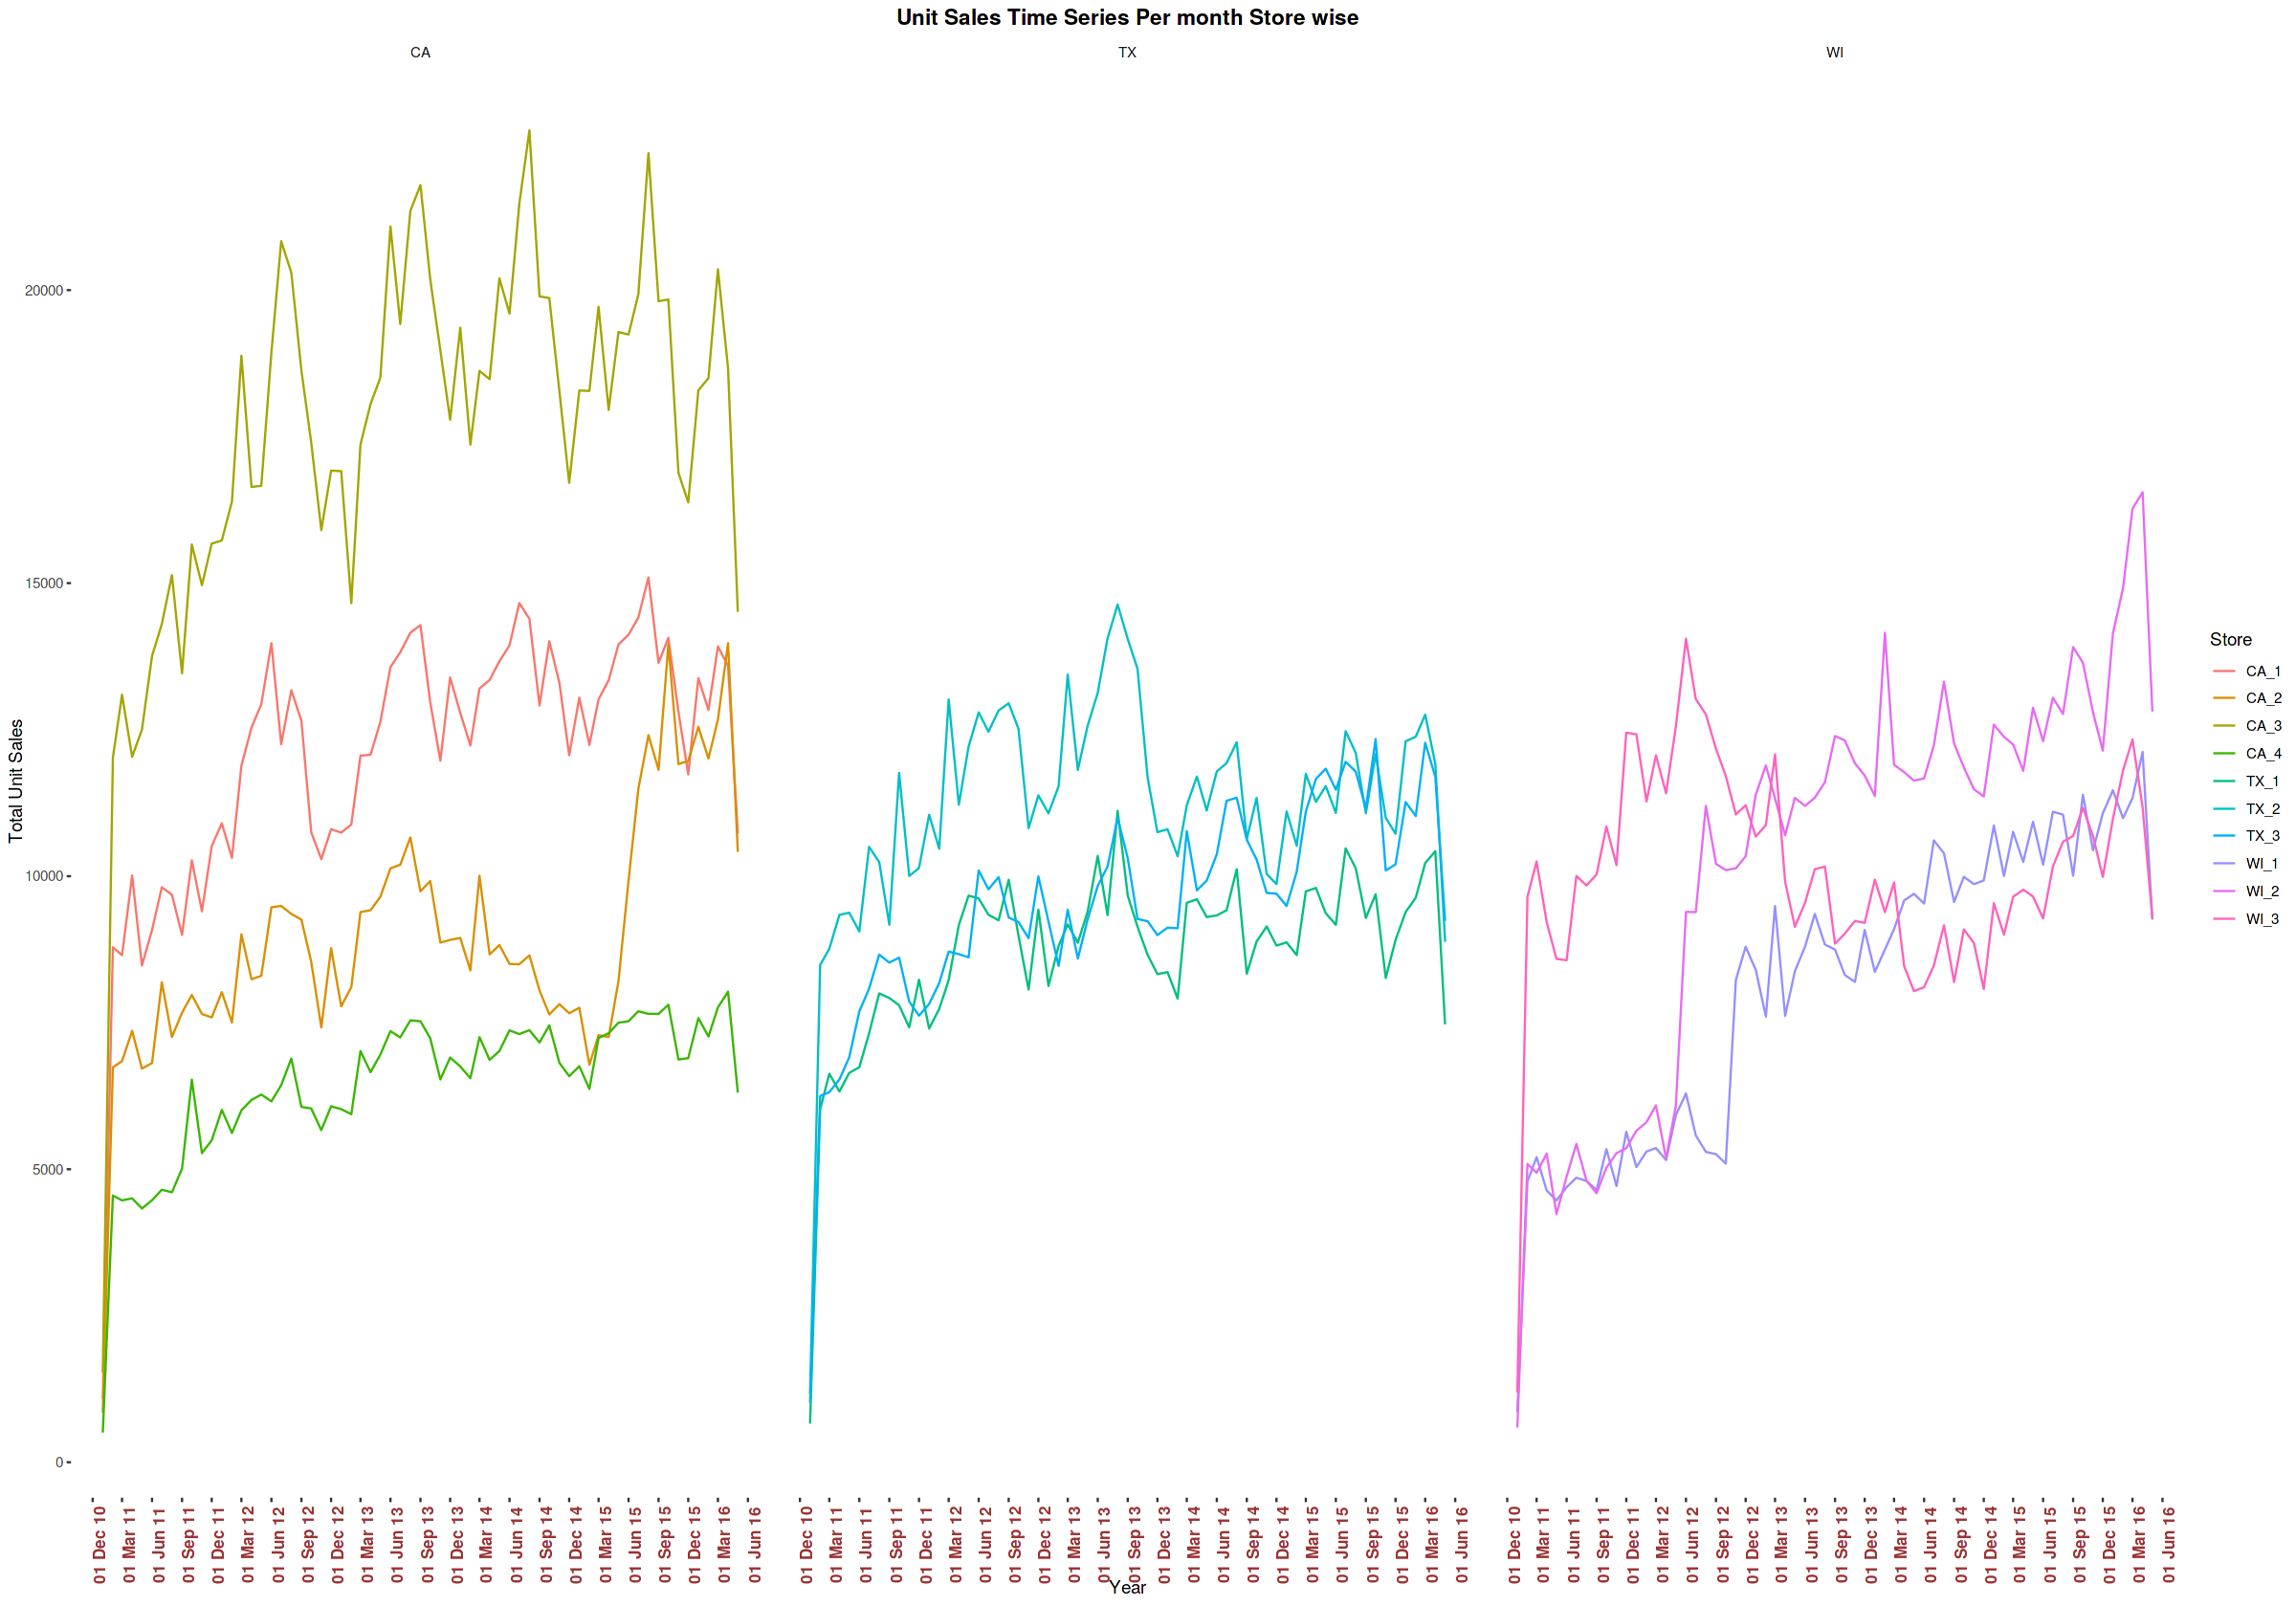

In [23]:
suppressMessages({
freeram()
g7<-data %>% select(date,state_id,store_id,Unit_Sales)%>% 
  group_by(month=floor_date(date, "month"),state_id,store_id) %>% 
  summarise(sales = sum(Unit_Sales))%>% 
        ggplot(aes(x = month, y = sales, color = store_id))+geom_line()+
        scale_colour_discrete("Store") + facet_grid(~state_id,scales="free")+
        labs(x="Year",y="Total Unit Sales",title="Unit Sales Time Series Per month Store wise") + theme_tufte() +
        theme(plot.title = element_text(hjust = 0.5, face = "bold"),axis.text.x=element_text(face="bold", color="#993333", 
                           size=10, angle=90))+scale_x_date(date_breaks = "3 month", date_labels = "%d %b %y")

html3<-ggplotly(g7, dynamicTicks = TRUE)
#htmlwidgets::saveWidget(as_widget(html3),"g7.html")
#ggsave("g7.png")
    })
#html3
#ggplotly(g7, dynamicTicks = TRUE)
freeram()
g7

### Weekly Trend

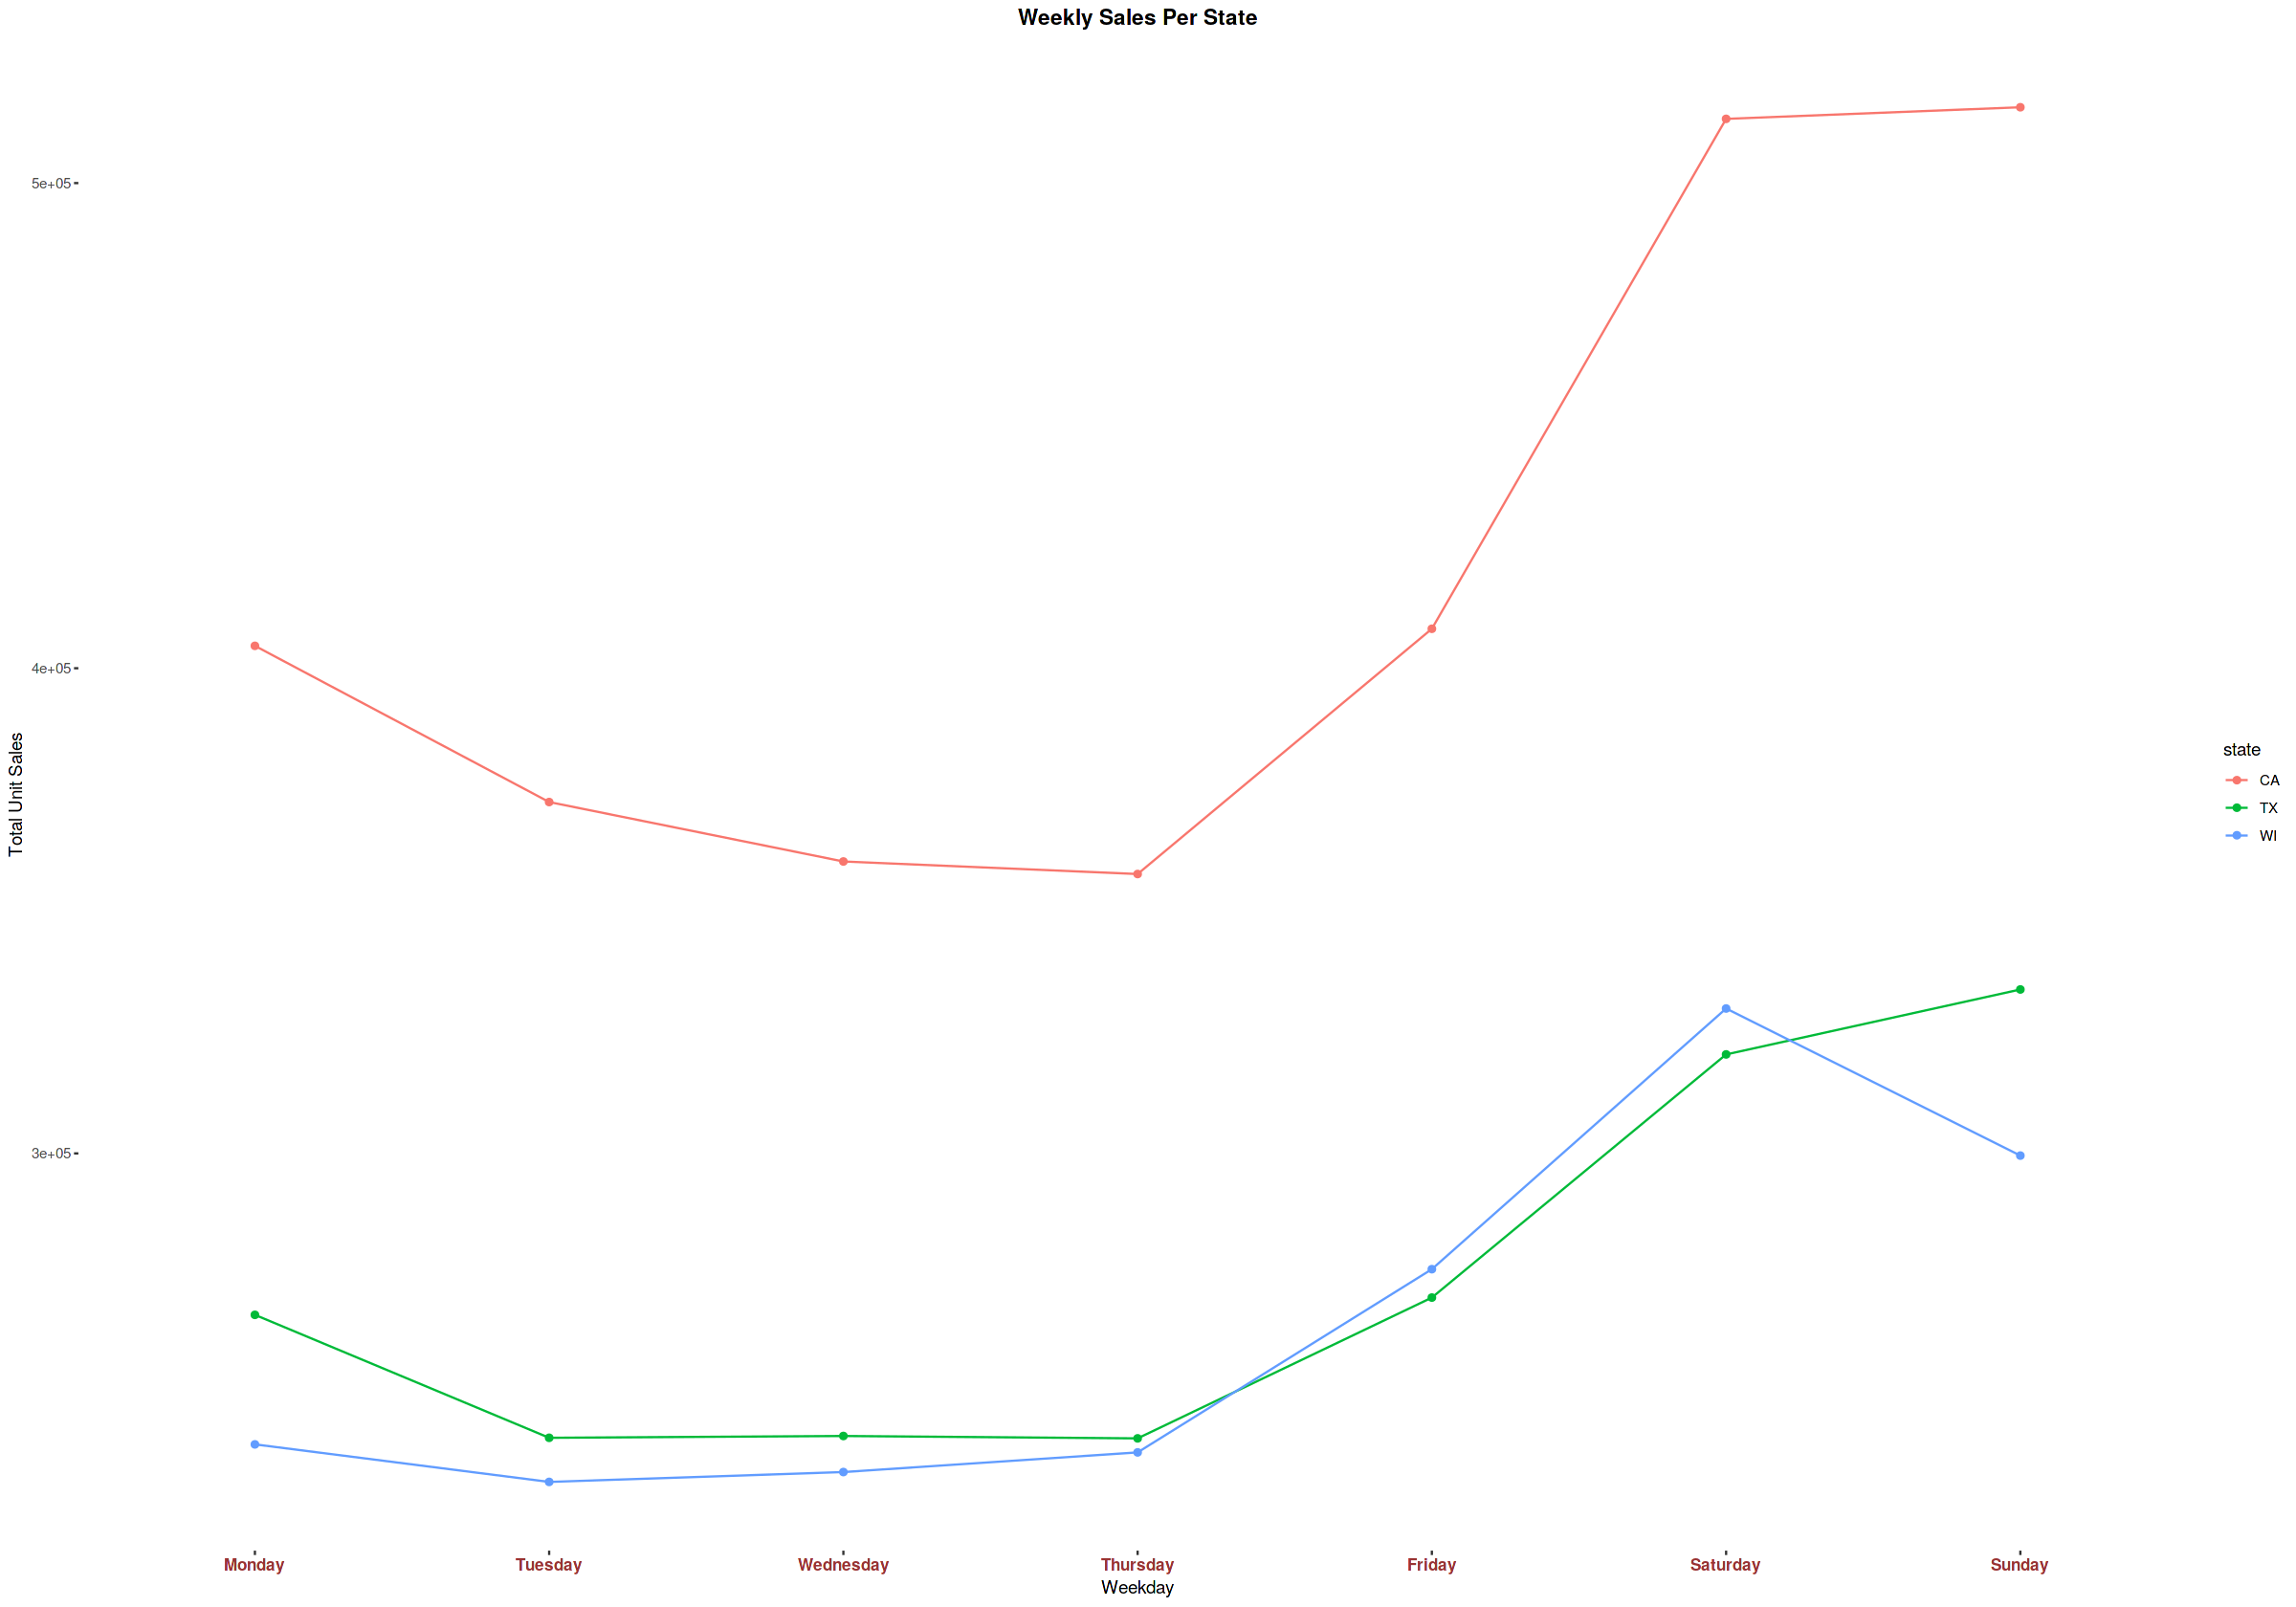

In [24]:
data$weekday <- ordered(data$weekday, levels=c("Monday", "Tuesday", "Wednesday", "Thursday", 
"Friday", "Saturday", "Sunday"))
suppressMessages({g8<-data %>% select(weekday,state_id,cat_id,Unit_Sales)%>% 
  group_by(weekday,state_id) %>% 
  summarise(sales = sum(Unit_Sales))%>% 
  ggplot(aes(weekday, sales,group=state_id,color=state_id)) +
  geom_line()+geom_point()+
  theme_tufte() +scale_colour_discrete("state")+
        labs(x="Weekday",y="Total Unit Sales",title="Weekly Sales Per State") + theme_tufte() +
        theme(plot.title = element_text(hjust = 0.5, face = "bold"),axis.text.x=element_text(face="bold", color="#993333", 
                           size=10)) })

#html4<-ggplotly(g8, dynamicTicks = TRUE)
#htmlwidgets::saveWidget(as_widget(html4),"g8.html")
#ggsave("g8.png")
#ggplotly(g8, dynamicTicks = TRUE)
freeram()
g8
              

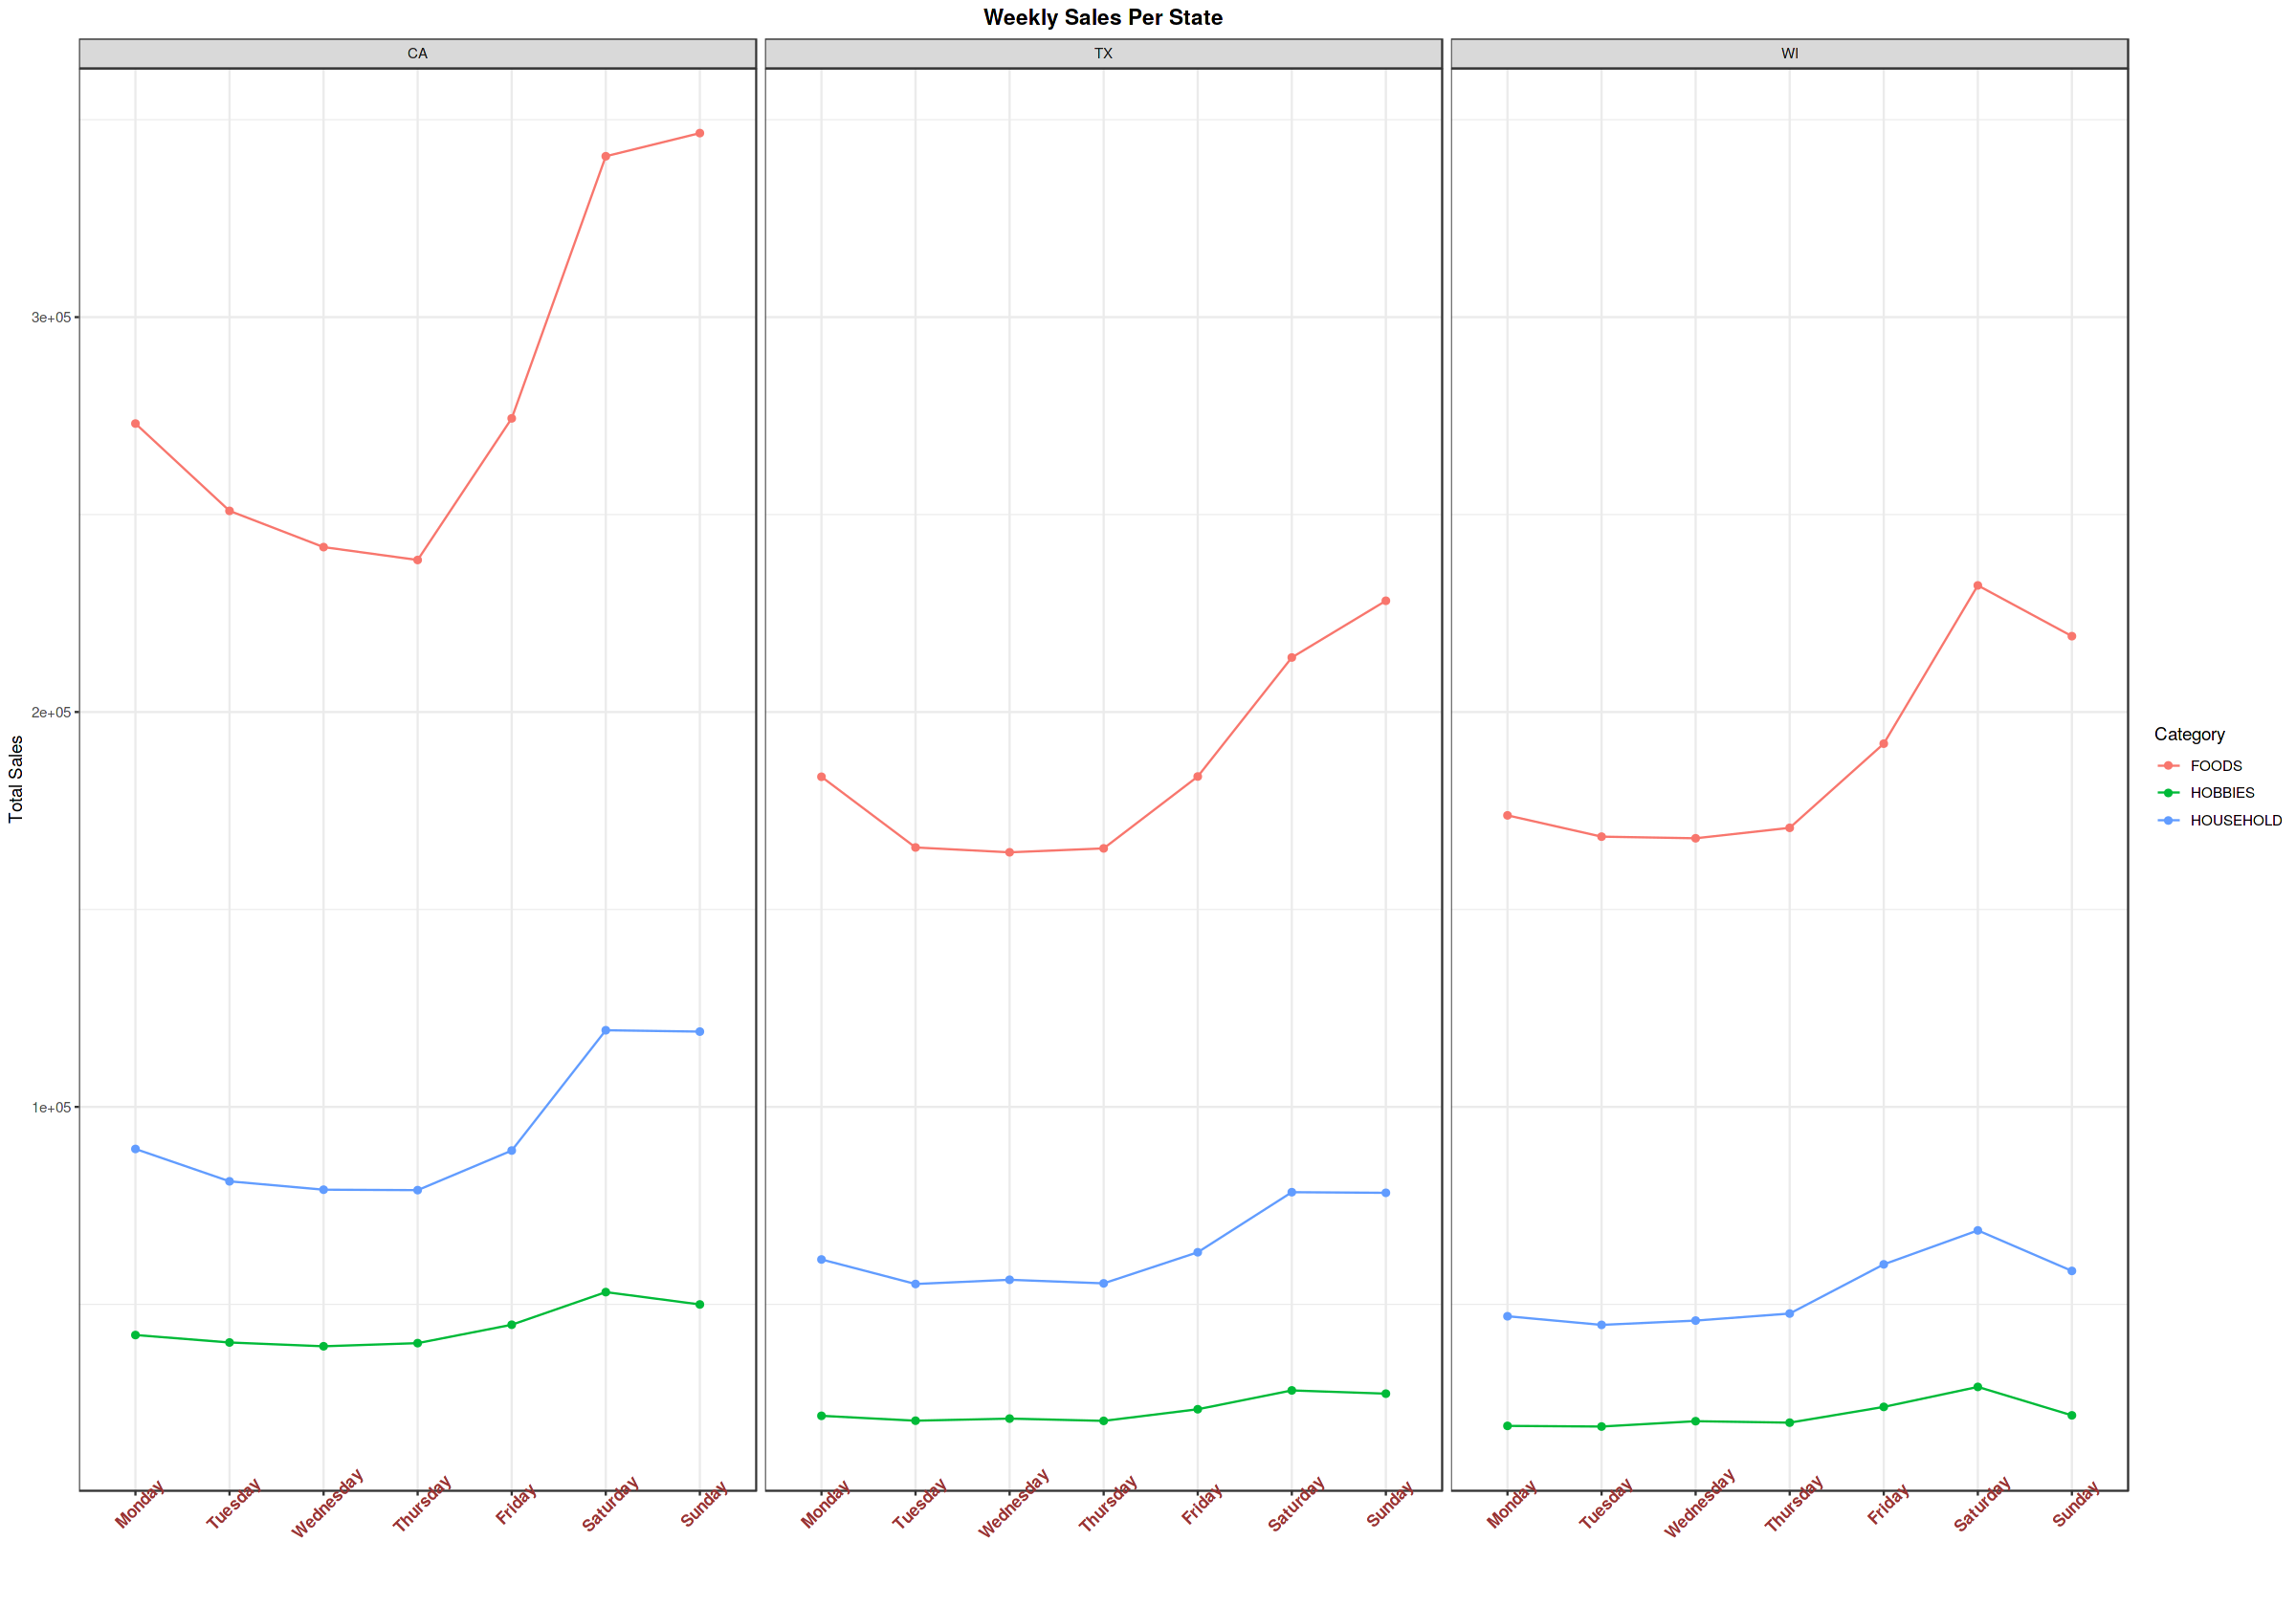

In [25]:
suppressMessages({
g9<-data %>% select(weekday,state_id,cat_id,Unit_Sales)%>% 
  group_by(weekday,state_id,cat_id) %>% 
  summarise(sales = sum(Unit_Sales))%>% 
  ggplot(aes(weekday, sales,group=cat_id,color=cat_id)) +
  geom_line()+geom_point()+facet_grid(~state_id)+
  theme_tufte() +scale_colour_discrete("Category")+
        labs(x="",y="Total Sales",title="Weekly Sales Per State") + theme_bw() +
        theme(plot.title = element_text(hjust = 0.5, face = "bold"),axis.text.x=element_text(face="bold", color="#993333", 
                           size=10,angle=45))

#html5<-ggplotly(g9)
#htmlwidgets::saveWidget(as_widget(html5),"g9.html")
#ggsave("g9.png")
})
#html5
g9
#ggplotly(g9)
freeram()
              

As expected the total sales are more during Saturday and Sunday when compared to normal weekdays. Even here, the Wisconsin state is an exception where peak sales at observed on Saturday, whereas it is Sunday for Calfornia and Texas state. So, maybe the Wisconsin state population prefers to do grocery shopping on Saturday.
To better observe trends for weekdays and month a heat map with total states for weekday vs month is plotted.

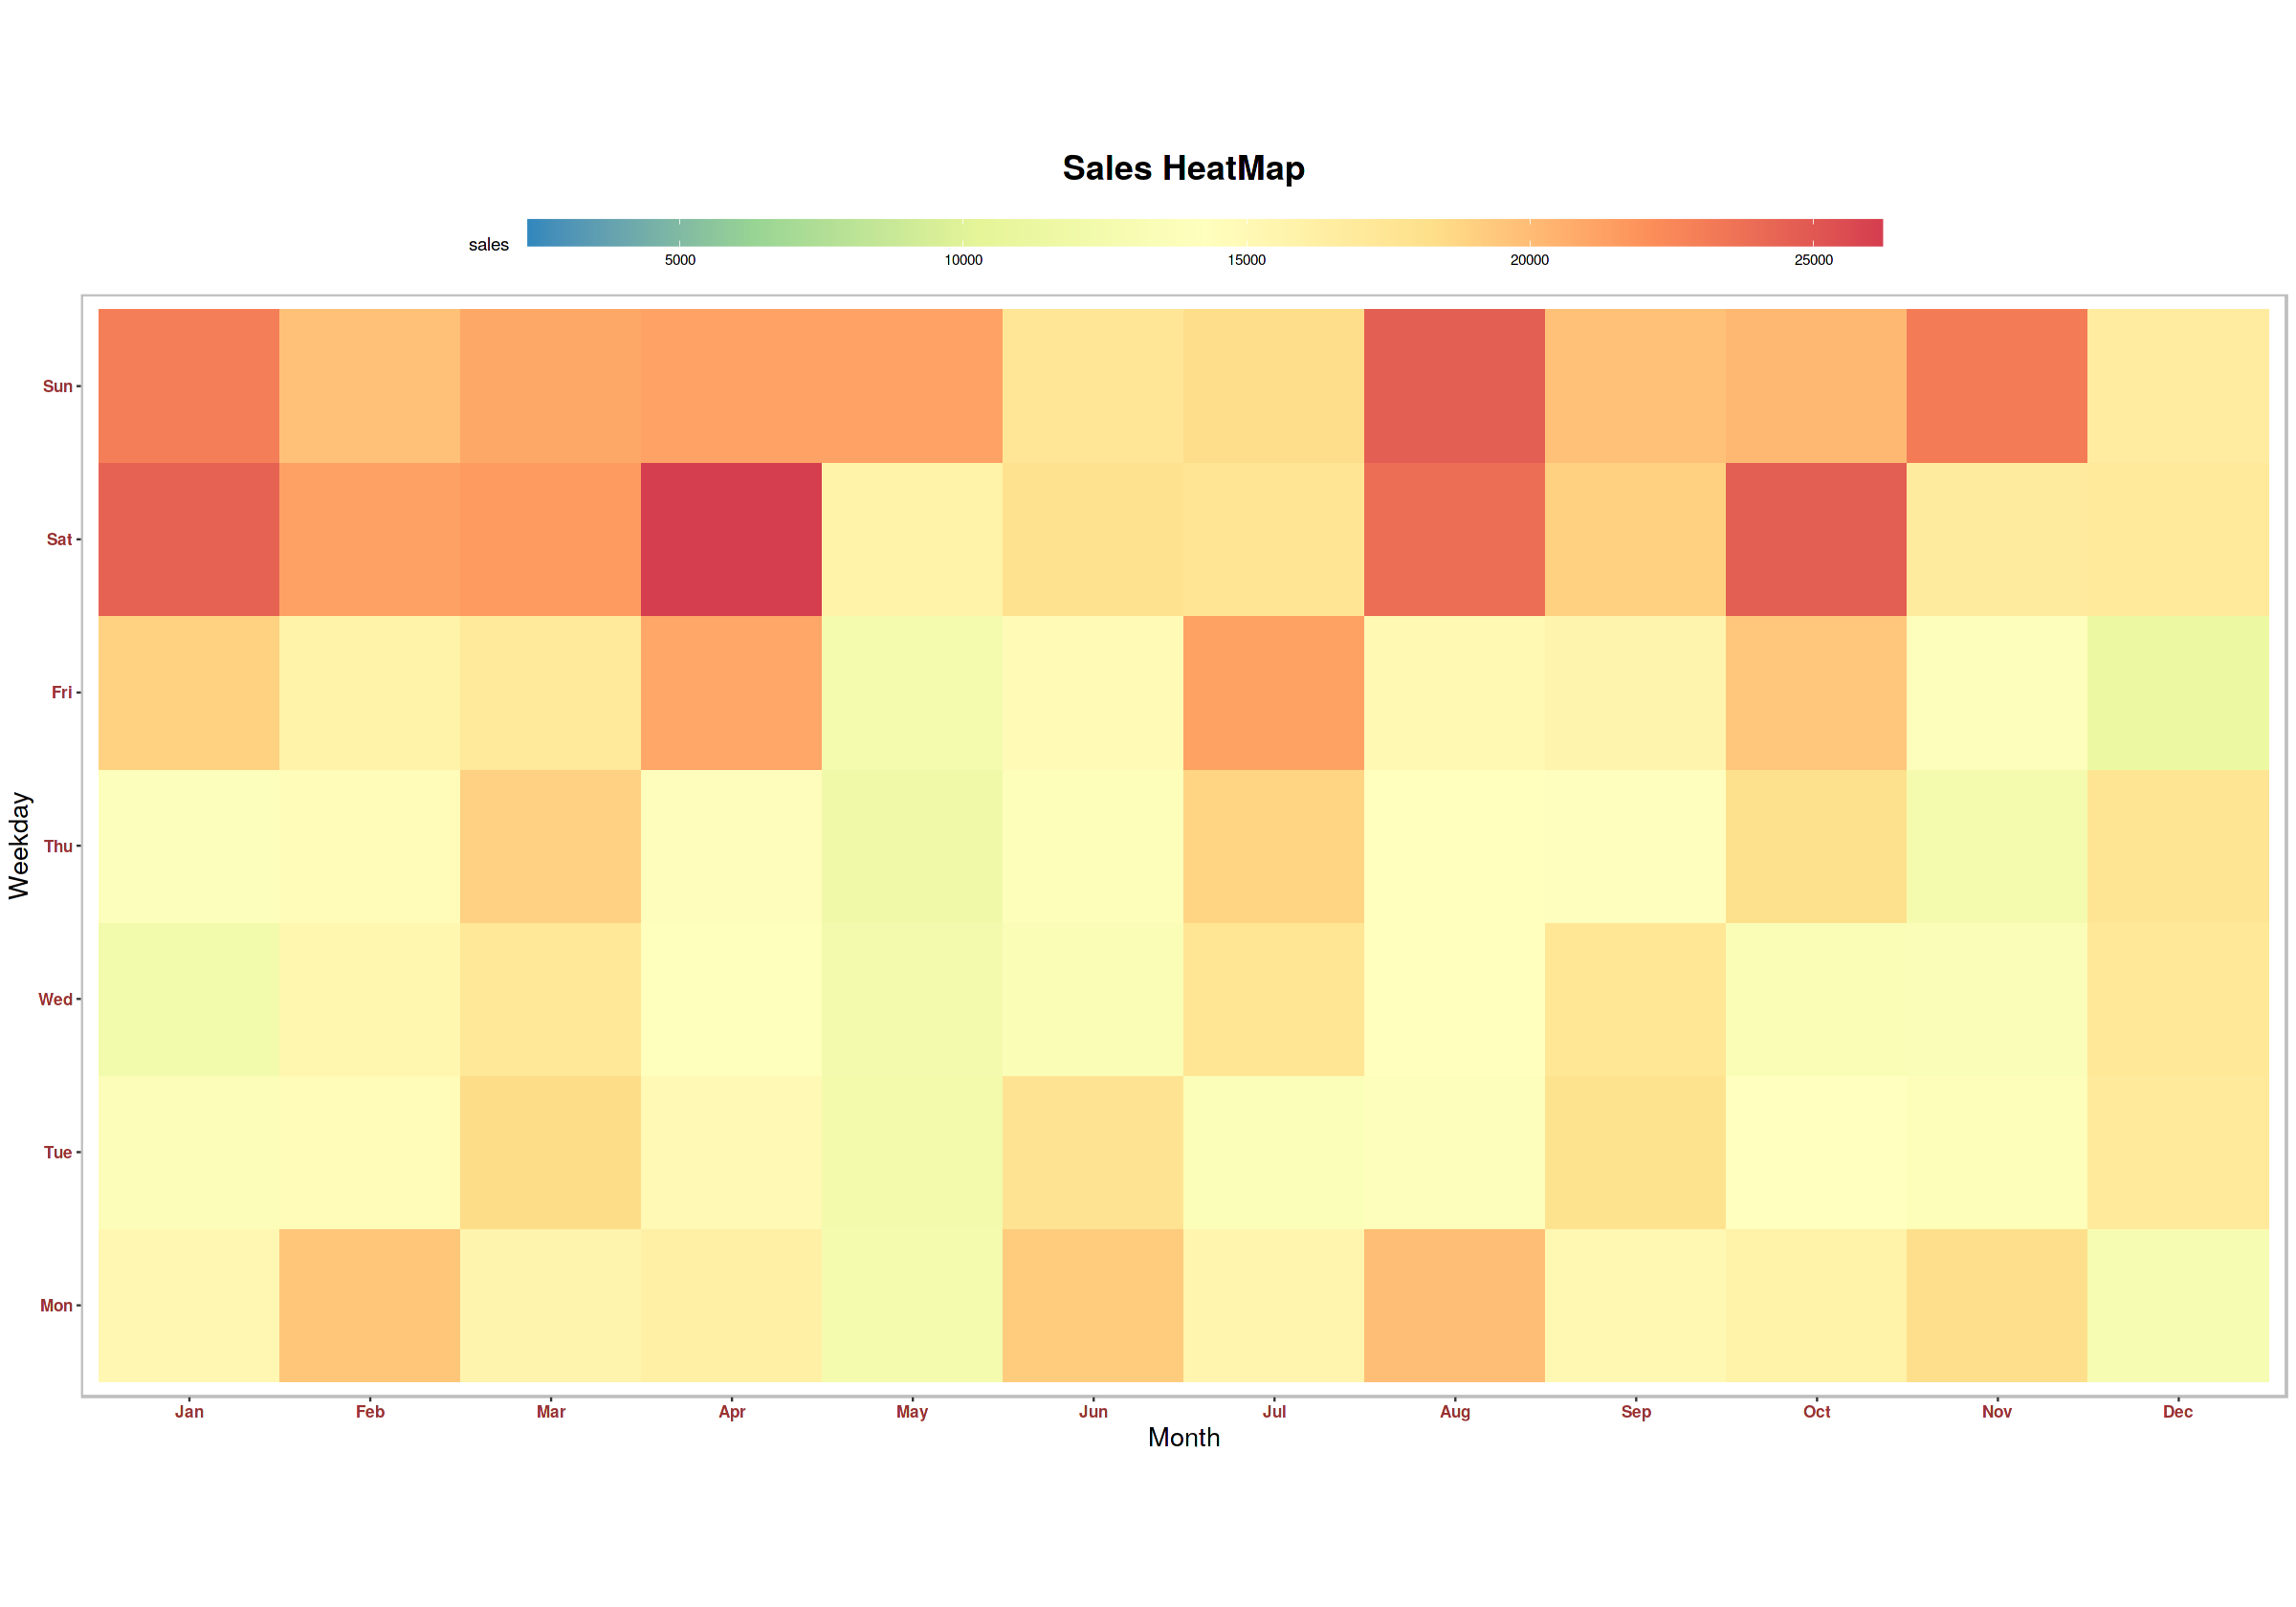

In [26]:
suppressMessages({
g13<-data %>% 
  mutate(wday = wday(date, label = TRUE, week_start = 1),
         month = month(date, label = TRUE),
         year = year(date)) %>% 
  group_by(wday, month, year) %>% 
  summarise(sales = sum(Unit_Sales))%>%
  ggplot(aes(month, wday, fill = sales)) +
  geom_tile()+scale_fill_distiller(palette='Spectral')+theme_tufte()+
    theme(legend.position = "top",aspect.ratio = 1/2,
        legend.key.width = unit(6, "cm"),legend.title.align = 2.5,
     axis.text.x=element_text(face="bold", color="#993333", 
                           size=10),axis.text.y=element_text(face="bold", color="#993333", 
                           size=10),panel.border = element_rect(colour = "grey", fill=NA, size=1),
      plot.title = element_text(hjust = 0.5, size = 21, face = "bold",
                                  margin = margin(0,0,0.5,0, unit = "cm")),
             axis.title.x = element_text(size = 16), axis.title.y = element_text(size = 16))+
    labs(x='Month',y='Weekday',title='Sales HeatMap')
    })
g13
#ggsave('g13.png')

### Sales trend on Holiday and Special Events:
This section aims to answer:
1. How festival events and holidays are affecting sales trend?
2. Which holiday recorded the highest sales?

In [27]:
events_name1<-dplyr::filter(data,(event_name_1!='None'))
events_type1<-dplyr::filter(data,(event_type_1!='None'))

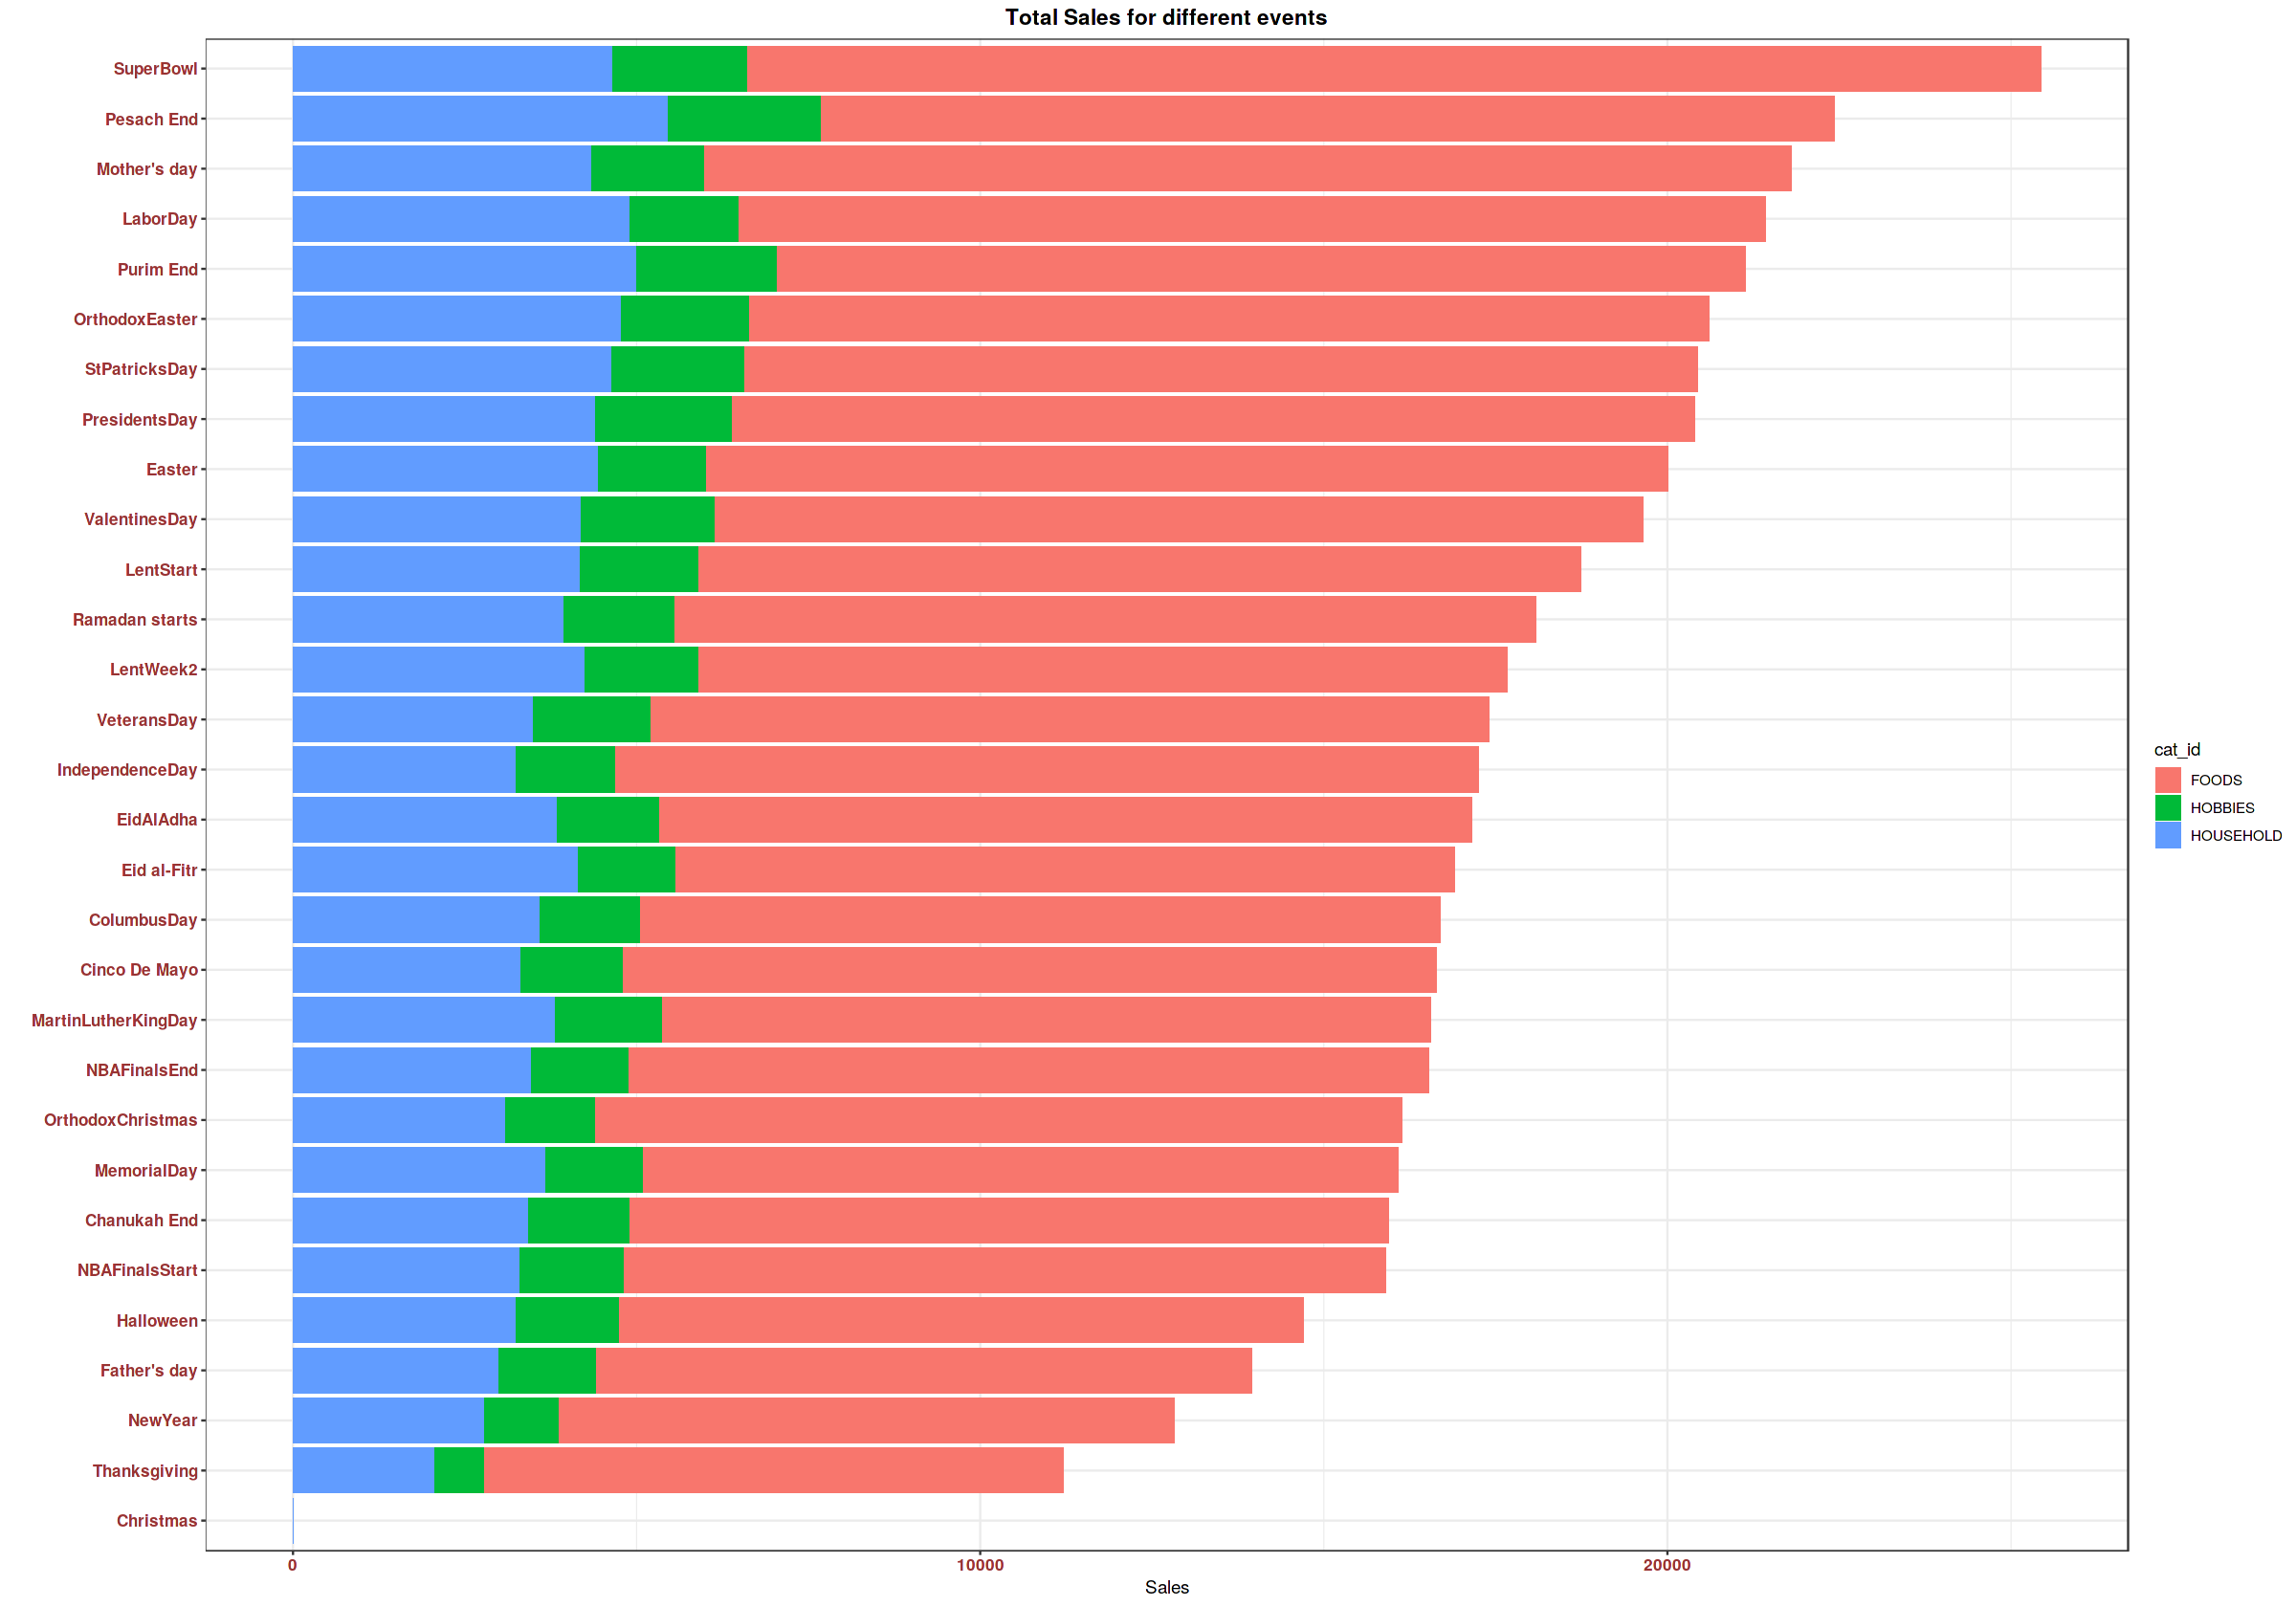

In [28]:
suppressMessages({g14<-events_name1%>%select(event_name_1, Unit_Sales,cat_id,state_id)%>%
                    group_by(event_name_1,cat_id,state_id)%>%
                    summarise(mean_event_sales = sum(Unit_Sales))%>%ggplot()+
                geom_bar(aes(x=reorder(event_name_1,mean_event_sales),y=mean_event_sales,fill=cat_id),stat='identity',position='stack')+
                coord_flip()+theme_bw()+
              labs(x = "", y = "Sales", title = "Total Sales for different events")+
        theme(plot.title = element_text(hjust = 0.5, face = "bold"),axis.text.y=element_text(face="bold", color="#993333", size=10),
             axis.text.x=element_text(face="bold", color="#993333", size=10))
freeram()
})
g14
#ggsave('g14.png')

The sales were highest on SuperBowl sporting events. On the day of National holidays, sales were low. And sales were consistent on the day of the religious festivals. To observe the sales trend, the seasonality trend was plotted for the year 2015.

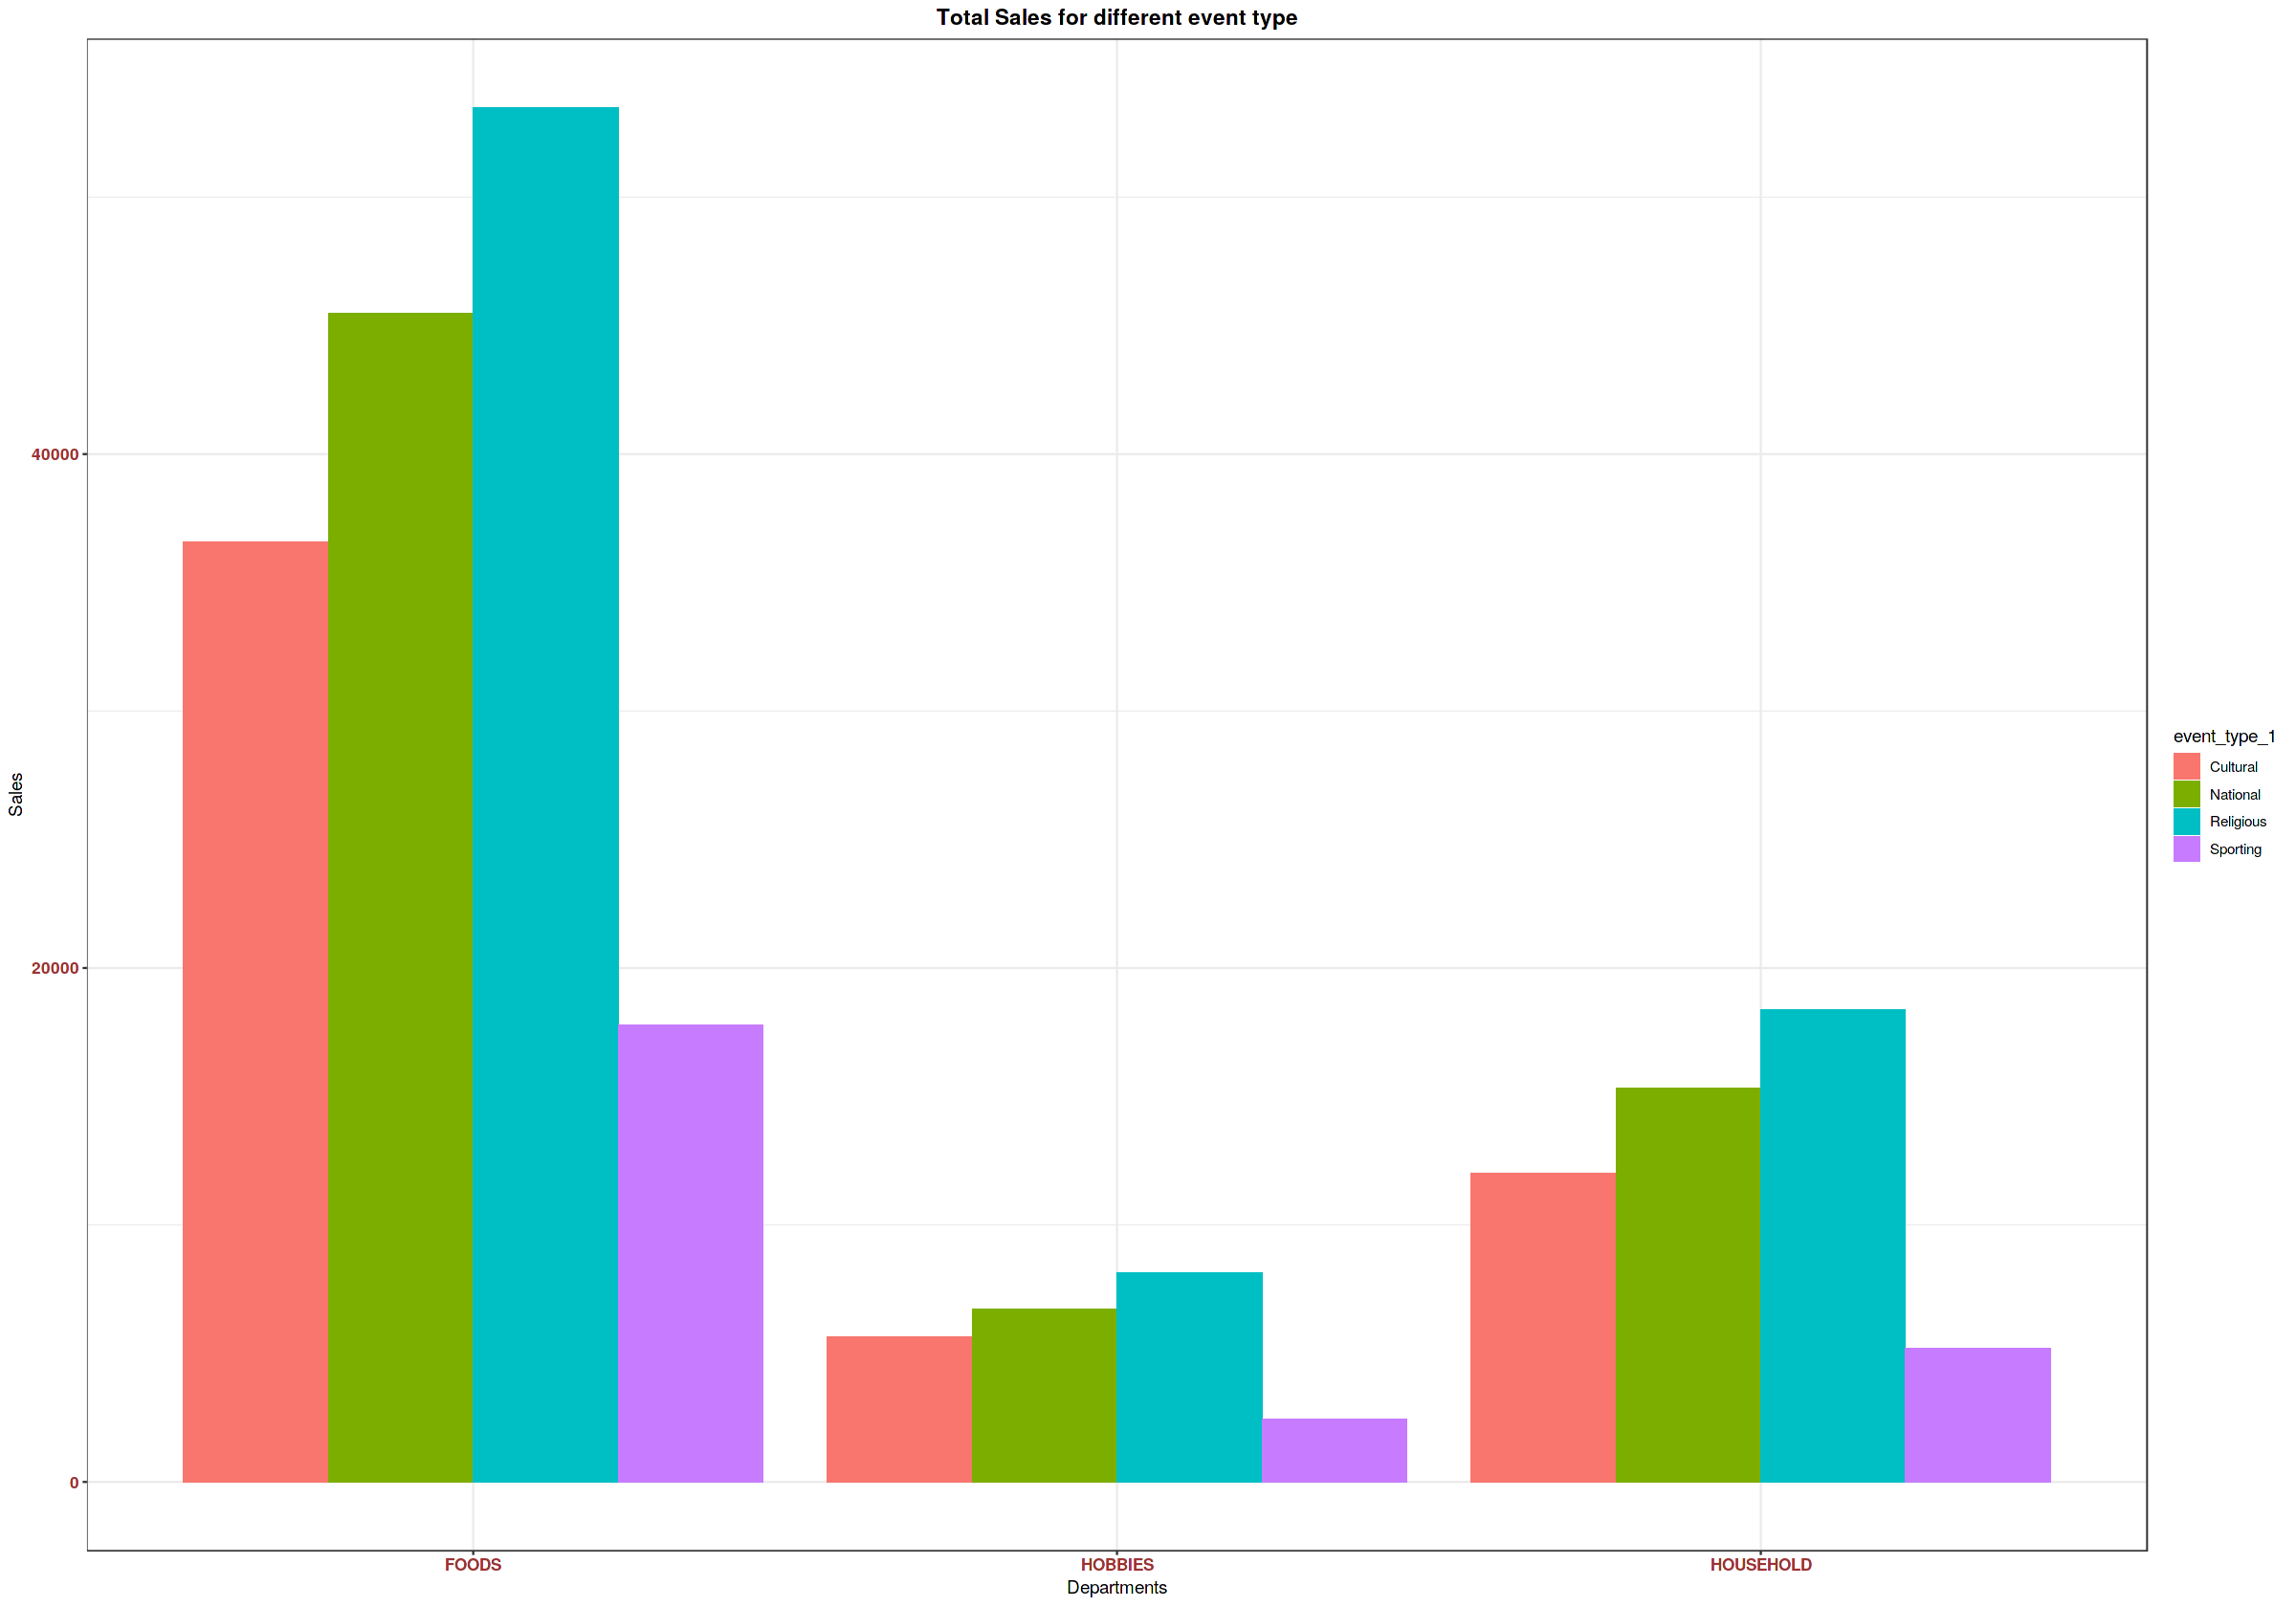

In [29]:
suppressMessages({g15<-events_type1%>%select(event_type_1, Unit_Sales,cat_id,state_id)%>%
                    group_by(event_type_1,cat_id,state_id)%>%
                    summarise(mean_type_sales = sum(Unit_Sales))%>%ggplot()+
                geom_bar(aes(x=cat_id,y=mean_type_sales,fill=event_type_1),stat='identity',
                         position=position_dodge(width=0.9))+scale_colour_discrete("Even Type")+
              labs(x = "Departments", y = "Sales", title = 'Total Sales for different event type')+theme_bw()+
        theme(plot.title = element_text(hjust = 0.5, face = "bold"),axis.text.y=element_text(face="bold", color="#993333", size=10),
             axis.text.x=element_text(face="bold", color="#993333", size=10))
freeram()})
g15
#ggsave('g15.png')

In [30]:
suppressMessages({event_holiday <- data %>%
                    select(year, month, date, event_name_1, event_name_2, Unit_Sales) %>%
                    mutate(day = day(date)) %>%
                    group_by(year, month, day, date, event_name_1, event_name_2) %>%
                    summarise(Total_Sales = sum(Unit_Sales))
                  })

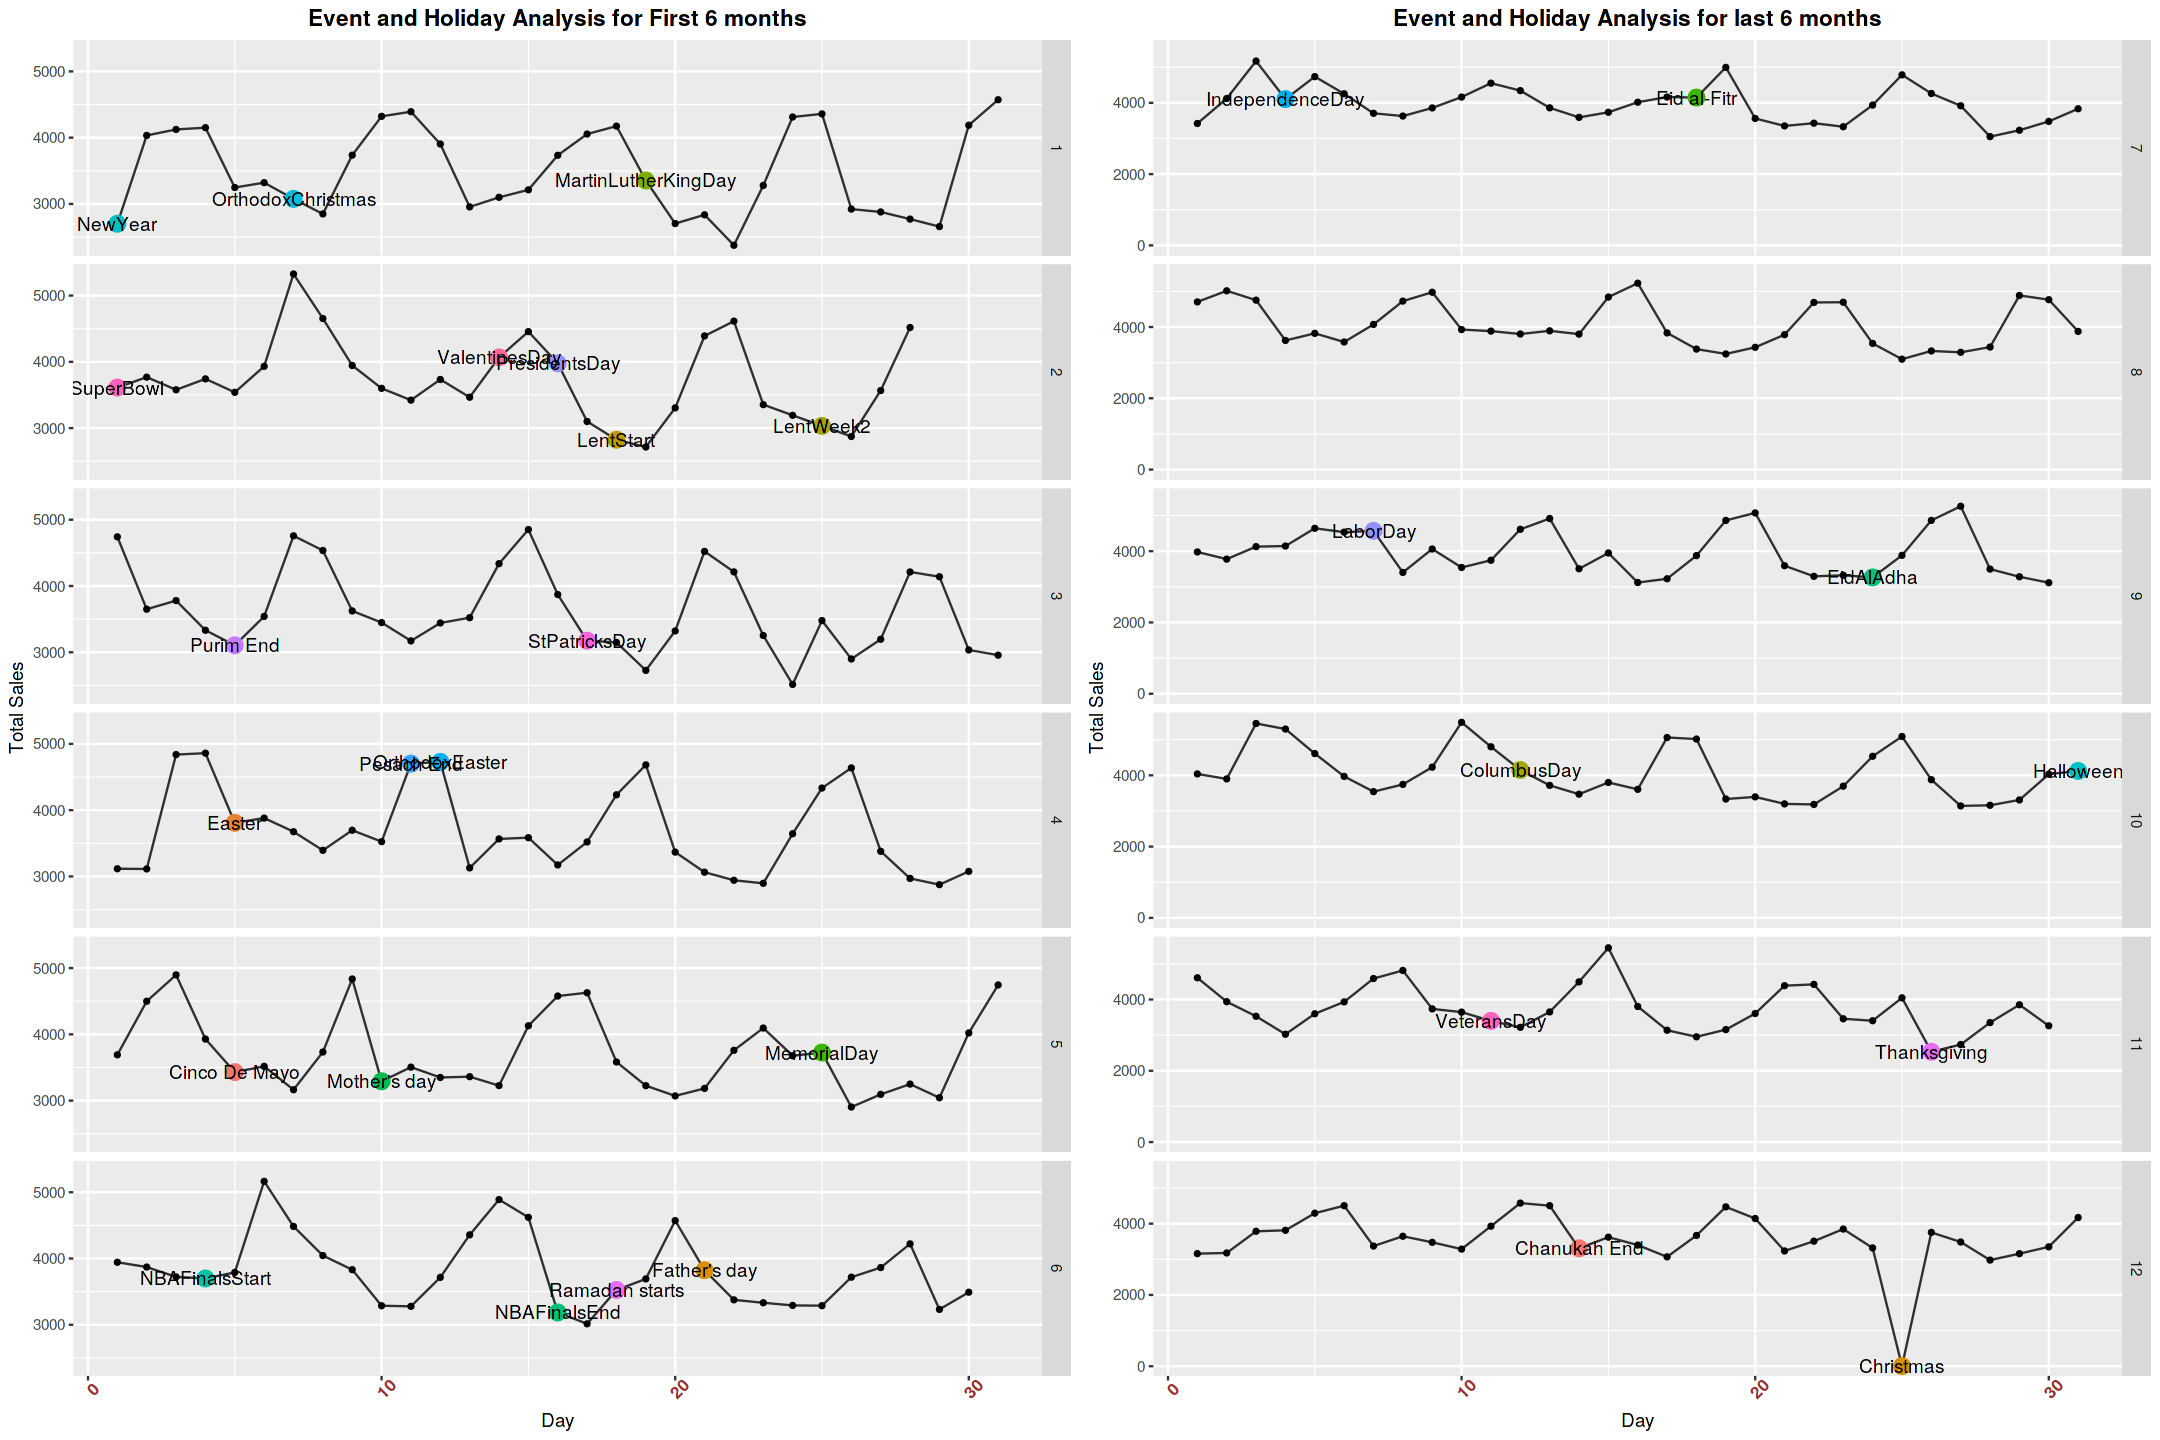

In [31]:
suppressMessages({
options(repr.plot.width = 18, repr.plot.height = 12)
jan<-dplyr::filter(event_holiday,(year==2015)& (month<=6))
event_jan<-dplyr::filter(event_holiday,event_name_1!="None"& (year==2015)& (month<=6))
g17<-ggplot(data=jan)+geom_line(aes(x=day,y=Total_Sales),alpha = 0.8)+geom_point(aes(x = day, y = Total_Sales), size = 1)+
                facet_grid(month~.)+geom_point(data = event_jan,aes(x = day, y = Total_Sales, col = event_name_1), size = 4)+
geom_text(data = event_jan,aes(x = day, y = Total_Sales, label = event_name_1))+xlab("Day") + ylab("Total Sales") +
                ggtitle("Event and Holiday Analysis for First 6 months") + 
                theme(plot.title = element_text(hjust = 0.5, face = "bold"),
                      axis.text.x=element_text(face="bold", color="#993333", size=10, angle=45),legend.position = "none")
#g17
#ggsave("g17.png")
options(repr.plot.width = 18, repr.plot.height = 12)
jan<-dplyr::filter(event_holiday,(year==2015)& (month>6))
event_jan<-dplyr::filter(event_holiday,event_name_1!="None"& (year==2015)& (month>6))
g18<-ggplot(data=jan)+geom_line(aes(x=day,y=Total_Sales),alpha = 0.8)+geom_point(aes(x = day, y = Total_Sales), size = 1)+
                facet_grid(month~.)+geom_point(data = event_jan,aes(x = day, y = Total_Sales, col = event_name_1), size = 4)+
geom_text(data = event_jan,aes(x = day, y = Total_Sales, label = event_name_1))+xlab("Day") + ylab("Total Sales") +
                ggtitle("Event and Holiday Analysis for last 6 months") + 
                theme(plot.title = element_text(hjust = 0.5, face = "bold"),
                      axis.text.x=element_text(face="bold", color="#993333", size=10, angle=45),legend.position = "none")
#g18
#ggsave("g18.png",width=15,height=25)
g19<-ggarrange(g17,g18)
#ggsave('g19.png')
    })
g19

### Observations:
1. On Festival like New year and Easter, the sales were low maybe because of reduced hours.
2. The sales are 0 for Christmas maybe because Walmart is closed.
3. The Sporting events like NBA Final shows an interesting insight, the sales were high the day before the event, and sales dropped on event days.
4. The sales are dropped on special days like father day, mother's day.
5. National holidays and Religious holidays also tend to have a similar effect like sporting events.

# Modelling

### Steps Involved:
* Introducing Lag and roll mean
* Train/Test Split
* Numerical encoding
* Converting the data into the required format(data.matrix, LGB.Dataset, Cat.loadpool)
* Parameter selection
* Model Training/Cross-Validation
* Prediction
* SMAPE Error for Comparison of Models

### Introducing Lag and roll mean
Because of the lack of computation power, 10% of the data is selected using stratified sampling. Stratified random sampling accurately reflects the population being studied because it is stratifying the entire population before applying random sampling methods. In short, it ensures each subgroup within the population receives proper representation within the sample.
Since the machine learning model, we are using is time-series having lag days and roll mean helps to improve the model so new lag variables are introduced for time-varifying effect variables 1 week,2 weeks,1 month, 2 months respectively. With better computation power 1 year also lag can be introduced since yearly sales patterns are similar. The rolling mean and rolling standard deviation were introduced for 1 week and 1-month lag variables.
For people who don't know about lag, A lag is a fixed amount of passing time; One set of observations in a time series is plotted (lagged) against a second, later set of data. The kth lag is the period that happened "k" time points before time

In [32]:
data <- data %>%
            group_by(id) %>%
            mutate(one_week = dplyr::lag(Unit_Sales, k = 7),
                   two_week = dplyr::lag(Unit_Sales, k = 14),
                   one_month = dplyr::lag(Unit_Sales, k = 28),
                   two_month = dplyr::lag(Unit_Sales, k = 60),
                   week_roll_mean=roll_meanr(one_week,7),
                   month_roll_mean=roll_meanr(one_month,28),
                   week_roll_sd=roll_sdr(one_week,7),
                   month_roll_sd=roll_sdr(one_month,28))%>%
 ungroup()
freeram()

### Train/Test Split
Since we need to forecast for 28 days, with 5 years of data. All the data with dates less than or equal to March 27th,2016 is considered as training data. And the 28 days data with dates greater than March 27th,2016, and less than April 24th, 2018 is taken as test data. The last 28 days are kept for validation.

In [33]:
## Dividing the number of dataset into training and test sets 
#data$date<-as.Date(data$date)
        train_data <- data %>%
                            filter(date <= as.Date('2016-03-27')) %>%
                            select(-Unit_Sales)

        train_labels <- data %>%
                            filter(date <= as.Date('2016-03-27')) %>%
                            select(Unit_Sales)

        test_data <- data %>%
                            filter(date > as.Date('2016-03-27') &
                                   (date <= as.Date('2016-04-24'))) %>%
                            select(-Unit_Sales)
        
        test_labels <- data %>%
                            filter((date > as.Date('2016-03-27')) &
                                   (date <= as.Date('2016-04-24'))) %>%
                            select(Unit_Sales)
        validation =  data%>% filter(date > as.Date('2016-04-24'))

In [34]:
category<-c('id','item_id','dept_id','cat_id','store_id','state_id',
            'day','weekday')

In [35]:
rm(data)
freeram()

As many machine learning models can't read character type data, all the columns should be converted into the numeric format. I used a simple command in R

In [36]:
train_data[,category]<-train_data[,category]%>%mutate_if(is.factor,as.integer)%>%
mutate_if(is.integer,as.factor)
test_data[,category]<-test_data[,category]%>%mutate_if(is.factor,as.integer)%>%
mutate_if(is.integer,as.factor)

In [37]:
#train_data<-train_data%>% 
#  mutate_if(is.factor, as.integer)%>% 
#  mutate_if(is.double, as.integer)
#test_data<-test_data%>% 
#  mutate_if(is.factor, as.integer)%>% 
# mutate_if(is.double, as.integer)

In [38]:
head(train_data)

id,item_id,dept_id,cat_id,store_id,state_id,day,date,wm_yr_wk,weekday,⋯,snap_WI,sell_price,one_week,two_week,one_month,two_month,week_roll_mean,month_roll_mean,week_roll_sd,month_roll_sd
<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<date>,<int>,<fct>,⋯,<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
14372,1438,4,2,2,1,1434,2015-01-01,11448,4,⋯,0,8.26,NA,NA,NA,NA,NA,NA,NA,NA
14375,1438,4,2,5,2,1799,2016-01-01,11548,5,⋯,0,8.26,NA,NA,NA,NA,NA,NA,NA,NA
14380,1438,4,2,10,3,362,2012-01-25,11152,3,⋯,0,NA,NA,NA,NA,NA,NA,NA,NA,NA
14379,1438,4,2,9,3,1805,2016-01-07,11549,4,⋯,0,8.38,NA,NA,NA,NA,NA,NA,NA,NA
14376,1438,4,2,6,2,1809,2016-01-11,11550,1,⋯,1,8.26,NA,NA,NA,NA,NA,NA,NA,NA
14374,1438,4,2,4,1,1800,2016-01-02,11549,6,⋯,1,8.26,NA,NA,NA,NA,NA,NA,NA,NA


In [39]:
train_data = as.data.frame(train_data)
train_labels=as.vector(train_labels)
test_data = as.data.frame(test_data)
test_labels=as.vector(test_labels)
validation = as.data.frame(validation)

freeram()

In [40]:
features = c(
    "item_id",
    "dept_id",
    "cat_id",
    "store_id",
    "state_id",
    "day",
    "weekday",
    "month",
    "year",
    "event_name_1",
    "event_type_1",
    "event_name_2",
    "event_type_2",
    "snap_CA",
    "snap_TX",
    "snap_WI",
    "sell_price",
    "one_week", # demand features.
    "two_week",
    "one_month",
    "two_month",
    "week_roll_mean",
    "month_roll_mean",
    "week_roll_sd",
    "month_roll_sd")


In [41]:
dim(as.matrix(train_data[,features]))
dim(train_labels)

[1] 5746799      25

[1] 5746799       1

### SMAPE error

In [42]:
smape_cal <- function(outsample, forecasts){
  outsample <- as.numeric(outsample)
  forecasts<-as.numeric(forecasts)
  smape <- (abs(outsample-forecasts))/((abs(outsample)+abs(forecasts))/2)
  return(smape)
}

# Xgbboost

In [43]:
train_set_xgb = xgb.DMatrix(data = data.matrix(train_data[,features]), label = data.matrix(train_labels))
test_set_xgb = xgb.DMatrix(data = data.matrix(test_data[,features]), label = data.matrix(test_labels))


In [44]:
params <- list(booster = "gbtree",
#               tree_method='gpu_hist', gpu_id=0,task_type = "GPU",
                objective = "reg:tweedie"
               , eta=0.4, gamma=0)

In [45]:
freeram()

In [46]:
xgb_cv <- xgb.cv(data = train_set_xgb
                  , param = params,
                  , maximize = FALSE, evaluation = "rmse", nrounds = 1500
                  , nthreads = 10, nfold = 3, early_stopping_round = 20)

#Number of rounds
num_iterations = xgb_cv$best_iteration



[1]	train-tweedie-nloglik@1.5:3.928179+0.001285	test-tweedie-nloglik@1.5:3.927514+0.003325 
Multiple eval metrics are present. Will use test_tweedie_nloglik@1.5 for early stopping.
Will train until test_tweedie_nloglik@1.5 hasn't improved in 20 rounds.

[2]	train-tweedie-nloglik@1.5:3.549977+0.001646	test-tweedie-nloglik@1.5:3.539672+0.002403 
[3]	train-tweedie-nloglik@1.5:3.339769+0.000782	test-tweedie-nloglik@1.5:3.336219+0.002210 
[4]	train-tweedie-nloglik@1.5:3.226503+0.000711	test-tweedie-nloglik@1.5:3.230499+0.001578 
[5]	train-tweedie-nloglik@1.5:3.183074+0.000651	test-tweedie-nloglik@1.5:3.179175+0.001591 
[6]	train-tweedie-nloglik@1.5:3.153034+0.000810	test-tweedie-nloglik@1.5:3.145523+0.001159 
[7]	train-tweedie-nloglik@1.5:3.124976+0.000991	test-tweedie-nloglik@1.5:3.130263+0.001568 
[8]	train-tweedie-nloglik@1.5:3.108684+0.001083	test-tweedie-nloglik@1.5:3.114121+0.000825 
[9]	train-tweedie-nloglik@1.5:3.104247+0.001158	test-tweedie-nloglik@1.5:3.108697+0.000913 
[10]	train

In [47]:
model_xgb <- xgb.train(data = train_set_xgb,
                              , param = params
                               , maximize = FALSE, evaluation = 'rmse', nrounds = num_iterations)

In [48]:
freeram()

Feature,Gain,Cover,Frequency,Importance
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
week_roll_mean,4.925057e-01,0.070664324,0.050037473,4.925057e-01
sell_price,3.275203e-01,0.207045245,0.194771415,3.275203e-01
month_roll_mean,9.261060e-02,0.112427176,0.085306176,9.261060e-02
month_roll_sd,1.655664e-02,0.091407865,0.069258916,1.655664e-02
day,1.202056e-02,0.095402046,0.144689856,1.202056e-02
week_roll_sd,1.088633e-02,0.051287825,0.046863290,1.088633e-02
item_id,1.056586e-02,0.150733743,0.161486576,1.056586e-02
dept_id,9.777082e-03,0.029344877,0.020279504,9.777082e-03
one_week,7.109282e-03,0.043586329,0.030463343,7.109282e-03


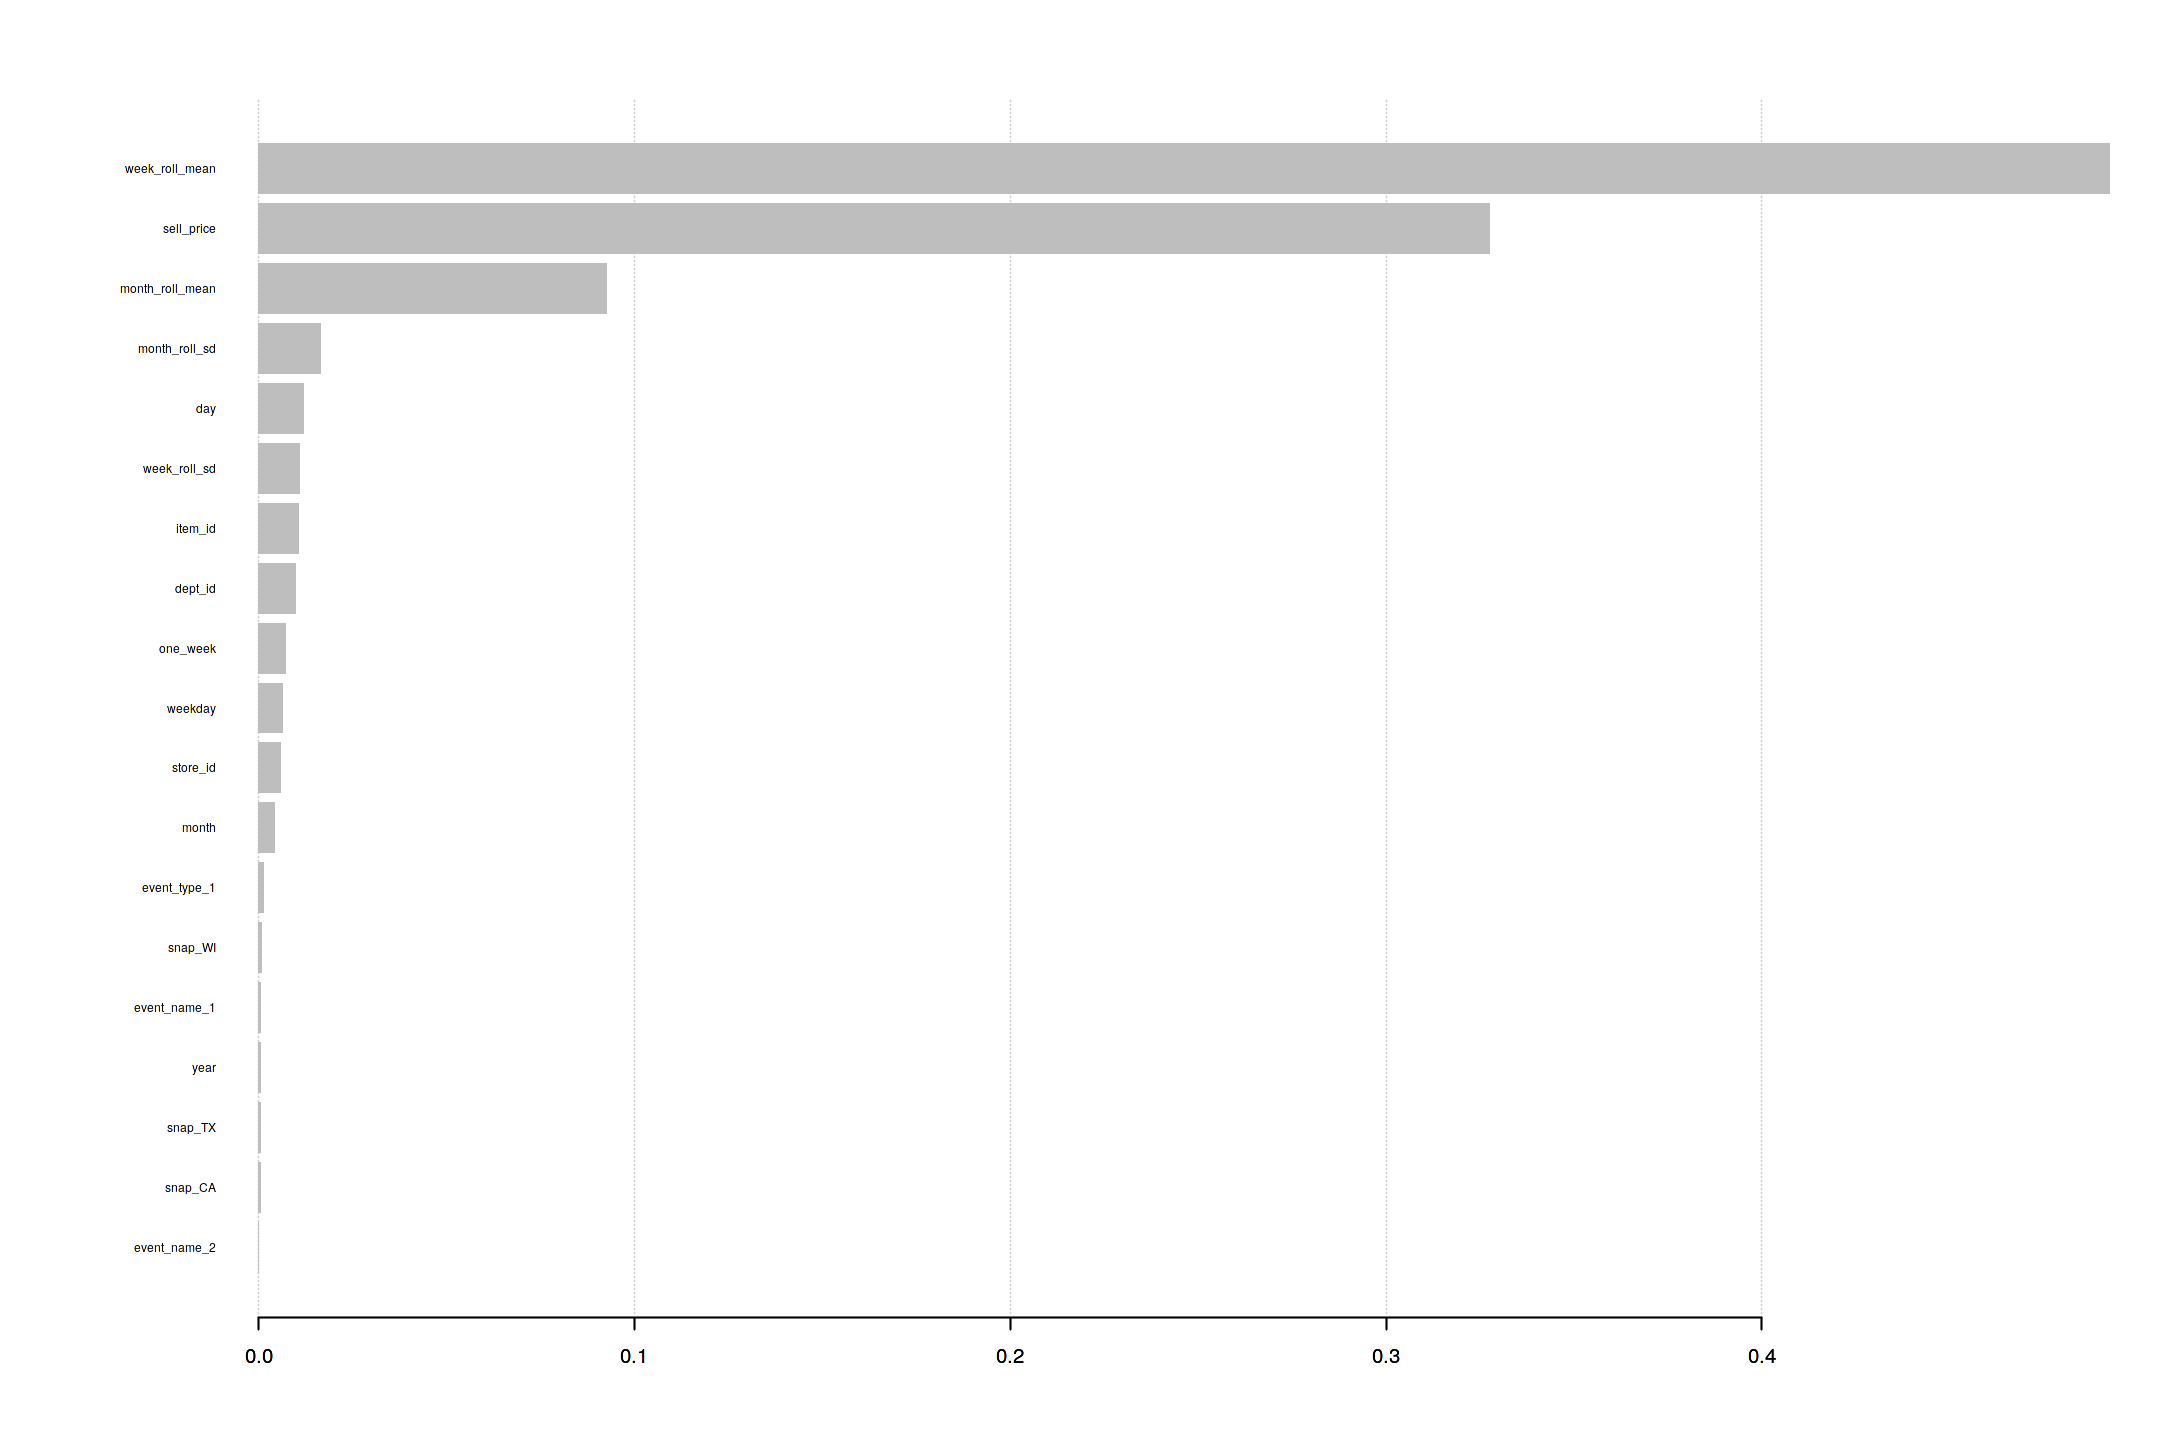

In [49]:
importance <- xgb.importance(feature_names = colnames(train_set_xgb), model = model_xgb)
g19<-xgb.plot.importance(importance_matrix = importance)
#ggsave('g19.png')
g19

In [50]:
test_pred = predict(model_xgb,test_set_xgb)
y_pred = predict(model_xgb,as.matrix(validation$Unit_Sales))

#validation[,'Unit_Sales'] = y_pred

In [51]:
accuracy_xg <- (1 - (sum((validation$Unit_Sales - y_pred))/sum(validation$Unit_Sales)))

sprintf("Accuracy for Xgboost is %f ", accuracy_xg )

[1] "Accuracy for Xgboost is 0.000000 "

In [52]:
SMAPE_ERR <- smape_cal(outsample=validation$Unit_Sales, forecasts=y_pred)
SMAPE<-mean(SMAPE_ERR,na.rm = T)
sprintf("The value of SMAPE for Xgboost is %f ", SMAPE )

[1] "The value of SMAPE for Xgboost is 2.000000 "

In [53]:
#predictions = validation[,c('id', 'date', 'Unit_Sales')]
#predictions = reshape2::dcast(predictions, id~date, value.var = 'Unit_Sales')
#colnames(predictions) = c('id',paste('F',1:28,sep=""))


In [54]:
#final = rbind(predictions,submission[(30491):(2*30490),])
#write.csv(final,'submission.csv',row.names=FALSE)

In [55]:
rm(train_set_xgb)
rm(test_set_xgb)
freeram()

# Catboost

In [56]:
train_data_cat<-train_data%>% 
  mutate_if(is.integer, as.numeric)
test_data_cat<-test_data%>% 
  mutate_if(is.integer, as.numeric)

In [57]:
train_cat <- catboost.load_pool(data = data.matrix(train_data[,features]), label = data.matrix(train_labels))
test_cat <- catboost.load_pool(data = data.matrix(test_data[,features]), label = data.matrix(test_labels))

In [58]:
params_cat <- list(iterations = 1500,
                metric_period = 100,
 #              tree_method='gpu_hist',task_type = "GPU",
               loss_function = "RMSE",
               eval_metric = "RMSE",
               random_strength = 0.5,
               depth = 7,
               early_stopping_rounds = 30,
               learning_rate = 0.18,
               l2_leaf_reg = 0.1,
               random_seed = 93)




In [59]:
#Cross validation module not supported yet

#catboost_cv<- catboost_cv(train_cat, test_cat, params = params_cat,
#                  , maximize = FALSE,  nrounds = 20,iterations = 500
#                  , nthreads = 10, nfold = 3)

#Number of rounds
#num_iterations = catboost_cv$best_iteration

In [60]:
freeram()

In [61]:
model_cat <- catboost.train(train_cat, test_cat, params = params_cat)

0:	learn: 3.7256565	test: 3.4313586	best: 3.4313586 (0)	total: 1.23s	remaining: 30m 46s
100:	learn: 2.5285609	test: 2.6707002	best: 2.6707002 (100)	total: 1m 57s	remaining: 27m 12s
200:	learn: 2.4614848	test: 2.7269131	best: 2.6707002 (100)	total: 3m 52s	remaining: 25m
300:	learn: 2.4116027	test: 2.7978249	best: 2.6707002 (100)	total: 5m 51s	remaining: 23m 19s
400:	learn: 2.3788613	test: 2.8604716	best: 2.6707002 (100)	total: 7m 46s	remaining: 21m 19s
500:	learn: 2.3537995	test: 2.8739311	best: 2.6707002 (100)	total: 9m 42s	remaining: 19m 21s
600:	learn: 2.3302059	test: 2.8865670	best: 2.6707002 (100)	total: 11m 40s	remaining: 17m 27s
700:	learn: 2.3090199	test: 2.9136880	best: 2.6707002 (100)	total: 13m 37s	remaining: 15m 32s
800:	learn: 2.2895025	test: 2.9161524	best: 2.6707002 (100)	total: 15m 34s	remaining: 13m 35s
900:	learn: 2.2718323	test: 2.9301780	best: 2.6707002 (100)	total: 17m 30s	remaining: 11m 38s
1000:	learn: 2.2532874	test: 2.9534291	best: 2.6707002 (100)	total: 19m 28s

In [62]:
test_pred_cat = catboost.predict(model_cat,test_cat)


In [63]:
valid_cat1<-catboost.load_pool(data = data.matrix(validation[,features]), label = data.matrix(validation$Unit_Sales))
#Predicting for validation set
y_pred_cat = catboost.predict(model_cat,valid_cat1)
#validation[,'Unit_Sales'] = y_pred


### SMAPE for Catboost

In [64]:
SMAPE_ERR <- smape_cal(outsample=validation$Unit_Sales, forecasts=y_pred_cat)
SMAPE<-mean(SMAPE_ERR,na.rm = T)
freeram()
sprintf("The value of SMAPE for catboost is %f ", SMAPE )

[1] "The value of SMAPE for catboost is 1.407073 "

In [65]:
accuracy_cat <- (1 - (sum((validation$Unit_Sales - y_pred_cat))/sum(validation$Unit_Sales)))
sprintf("Accuracy for catboost is %f ", accuracy_cat )

[1] "Accuracy for catboost is 0.919516 "

V1
<dbl>
2.82863657
0.22183044
0.10834529
1.62775766
0.18940664
9.72425382
3.93371247
0.93304972
0.08542721


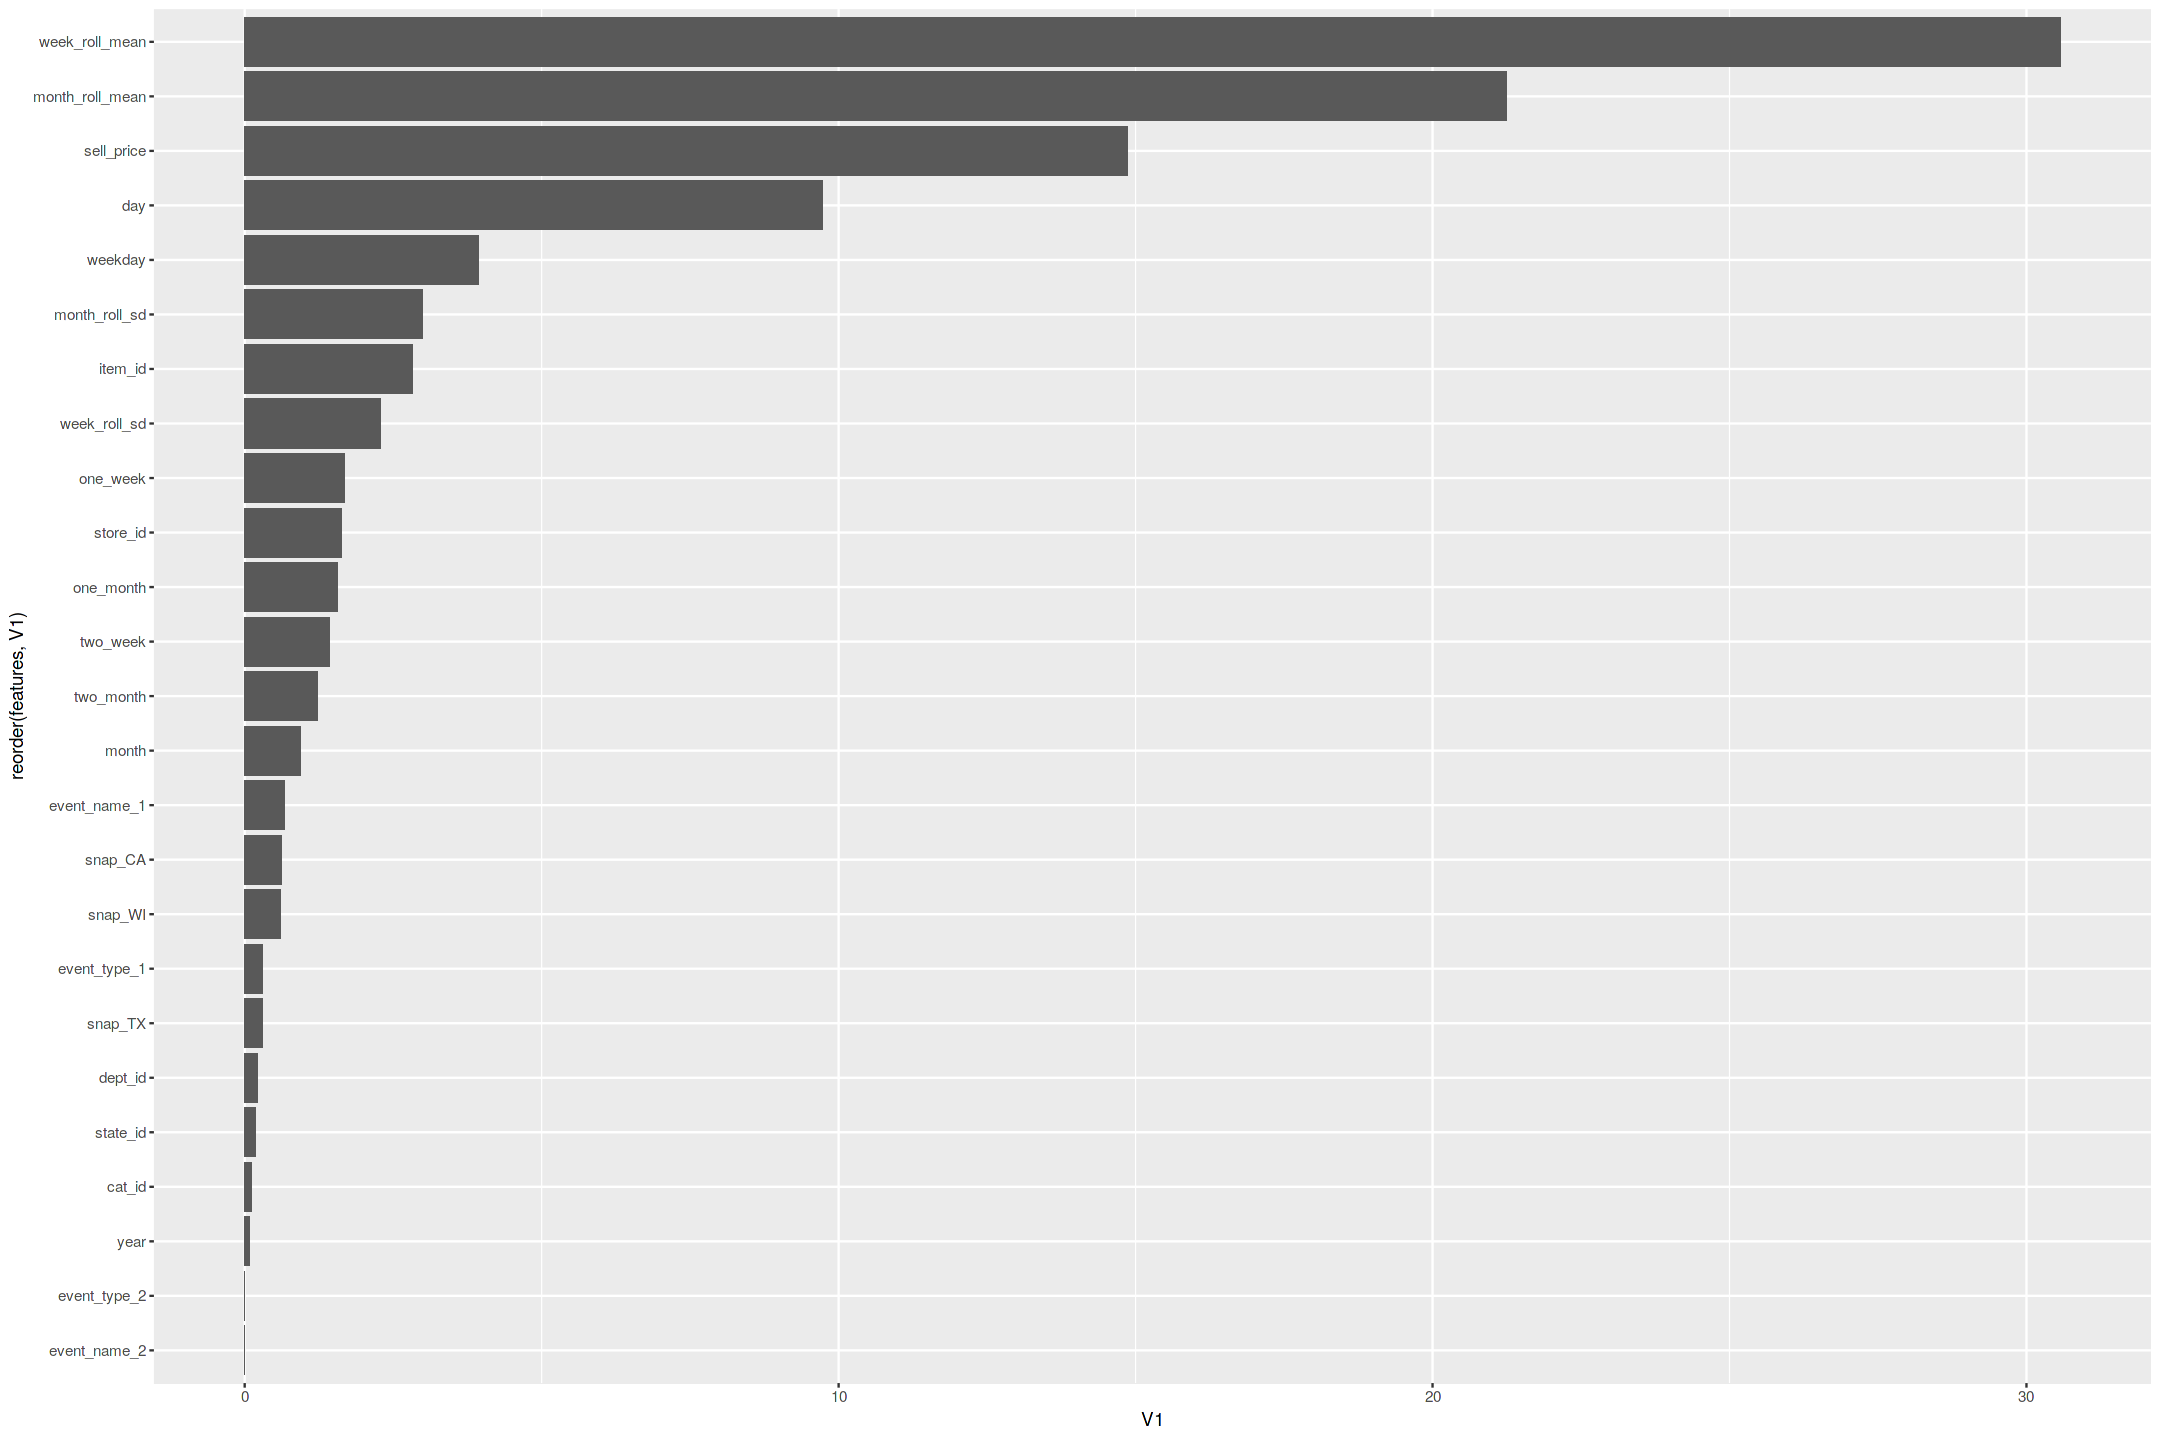

In [66]:
g20<-importance_cat <- catboost.get_feature_importance(model_cat, test_cat)%>% 
  as.data.frame() 
feature_cat=as.data.frame(features)
data_cat=data.frame(importance_cat,feature_cat)

ggplot(data_cat,aes(x = reorder(features, V1), y = V1)) +
geom_bar(stat = "identity") +
coord_flip()
g20
#ggsave('g20.png')

In [67]:
rm(train_data_cat)
rm(test_data_cat)
freeram()

# Light gbm

In [68]:
train_set_lgb <- lgb.Dataset(data=as.matrix(train_data[,features]), label = as.matrix(train_labels))
test_set_lgb <- lgb.Dataset(data=as.matrix(test_data[,features]), label =as.matrix(test_labels))
freeram()
valids=list(train=train_set_lgb,test = test_set_lgb)


In [69]:
p=list(objective = "tweedie",
           tweedie_variance_power=1.1,
           metric ="rmse",
          force_row_wise = TRUE,
                  num_leaves=90,
            learning_rate = 0.03,
            feature_fraction= 0.5,
            bagging_fraction= 0.5,
            max_bin=100,
            bagging_freq = 1,
            boost_from_average=FALSE,
          lambda_l1 = 0,
          lambda_l2 = 0,
          nthread = 4)

freeram()

In [70]:
lgb_cv <- lgb.cv(data = train_set_lgb
                  , param = p,valids=valids,
        num_boost_round=1500,
        nfold=3,
  
                 metrics='rmse',
        early_stopping_rounds=20,
        stratified=FALSE)



[1]:	valid's rmse:3.88125+0.0338889 
[2]:	valid's rmse:3.85671+0.0340235 
[3]:	valid's rmse:3.83274+0.0341706 
[4]:	valid's rmse:3.80647+0.0343512 
[5]:	valid's rmse:3.77954+0.0344978 
[6]:	valid's rmse:3.7507+0.034736 
[7]:	valid's rmse:3.72151+0.0348905 
[8]:	valid's rmse:3.69212+0.0351164 
[9]:	valid's rmse:3.66115+0.0353648 
[10]:	valid's rmse:3.63115+0.035624 
[11]:	valid's rmse:3.60006+0.0359258 
[12]:	valid's rmse:3.56851+0.0362834 
[13]:	valid's rmse:3.53729+0.0364117 
[14]:	valid's rmse:3.50719+0.036466 
[15]:	valid's rmse:3.48115+0.036767 
[16]:	valid's rmse:3.4509+0.0370044 
[17]:	valid's rmse:3.42117+0.0372073 
[18]:	valid's rmse:3.39127+0.0377447 
[19]:	valid's rmse:3.36302+0.037986 
[20]:	valid's rmse:3.33393+0.0387948 
[21]:	valid's rmse:3.30901+0.0389313 
[22]:	valid's rmse:3.28291+0.0391301 
[23]:	valid's rmse:3.25983+0.0391805 
[24]:	valid's rmse:3.23548+0.0396869 
[25]:	valid's rmse:3.21079+0.0394188 
[26]:	valid's rmse:3.18753+0.0398837 
[27]:	valid's rmse:3.16492+0

In [71]:
best_iterations = lgb_cv$best_iter
l_lgb <- lgb.train(data = train_set_lgb,
                    param = p,verbose= 1,valids=valids,
                               maximize = FALSE, evaluation = 'rmse', nrounds = best_iterations)

cat("Best score:", l_lgb$best_score, "at", l_lgb$best_iter, "iteration")

[1]:	train's rmse:3.88136	test's rmse:3.50882 
[2]:	train's rmse:3.85672	test's rmse:3.48333 
[3]:	train's rmse:3.83277	test's rmse:3.45735 
[4]:	train's rmse:3.80641	test's rmse:3.42969 
[5]:	train's rmse:3.7794	test's rmse:3.40154 
[6]:	train's rmse:3.75058	test's rmse:3.37438 
[7]:	train's rmse:3.7213	test's rmse:3.34488 
[8]:	train's rmse:3.69187	test's rmse:3.31526 
[9]:	train's rmse:3.66067	test's rmse:3.28651 
[10]:	train's rmse:3.63058	test's rmse:3.25564 
[11]:	train's rmse:3.5992	test's rmse:3.22447 
[12]:	train's rmse:3.56736	test's rmse:3.19398 
[13]:	train's rmse:3.53581	test's rmse:3.16448 
[14]:	train's rmse:3.50567	test's rmse:3.1348 
[15]:	train's rmse:3.47912	test's rmse:3.11156 
[16]:	train's rmse:3.44871	test's rmse:3.08443 
[17]:	train's rmse:3.41865	test's rmse:3.05586 
[18]:	train's rmse:3.38827	test's rmse:3.03013 
[19]:	train's rmse:3.36053	test's rmse:3.00497 
[20]:	train's rmse:3.33071	test's rmse:2.98027 
[21]:	train's rmse:3.30527	test's rmse:2.95764 
[22]:

In [72]:
#test_pred_lgb = predict(model,as.matrix(validation[,features]))
y_pred_lgb = predict(l_lgb,as.matrix(validation$Unit_Sales))


Feature,Gain,Cover,Frequency
<chr>,<dbl>,<dbl>,<dbl>
week_roll_mean,0.282840346,0.07023063,0.08263500
month_roll_mean,0.225423271,0.08602900,0.07903499
sell_price,0.179459135,0.20357313,0.10464094
week_roll_sd,0.110501486,0.06338069,0.06601030
month_roll_sd,0.097821829,0.06082696,0.05598437
day,0.014440664,0.08086403,0.11763556
item_id,0.014357038,0.08516959,0.12044643
one_month,0.013247549,0.01554530,0.01404682
one_week,0.012609915,0.07403302,0.06435684


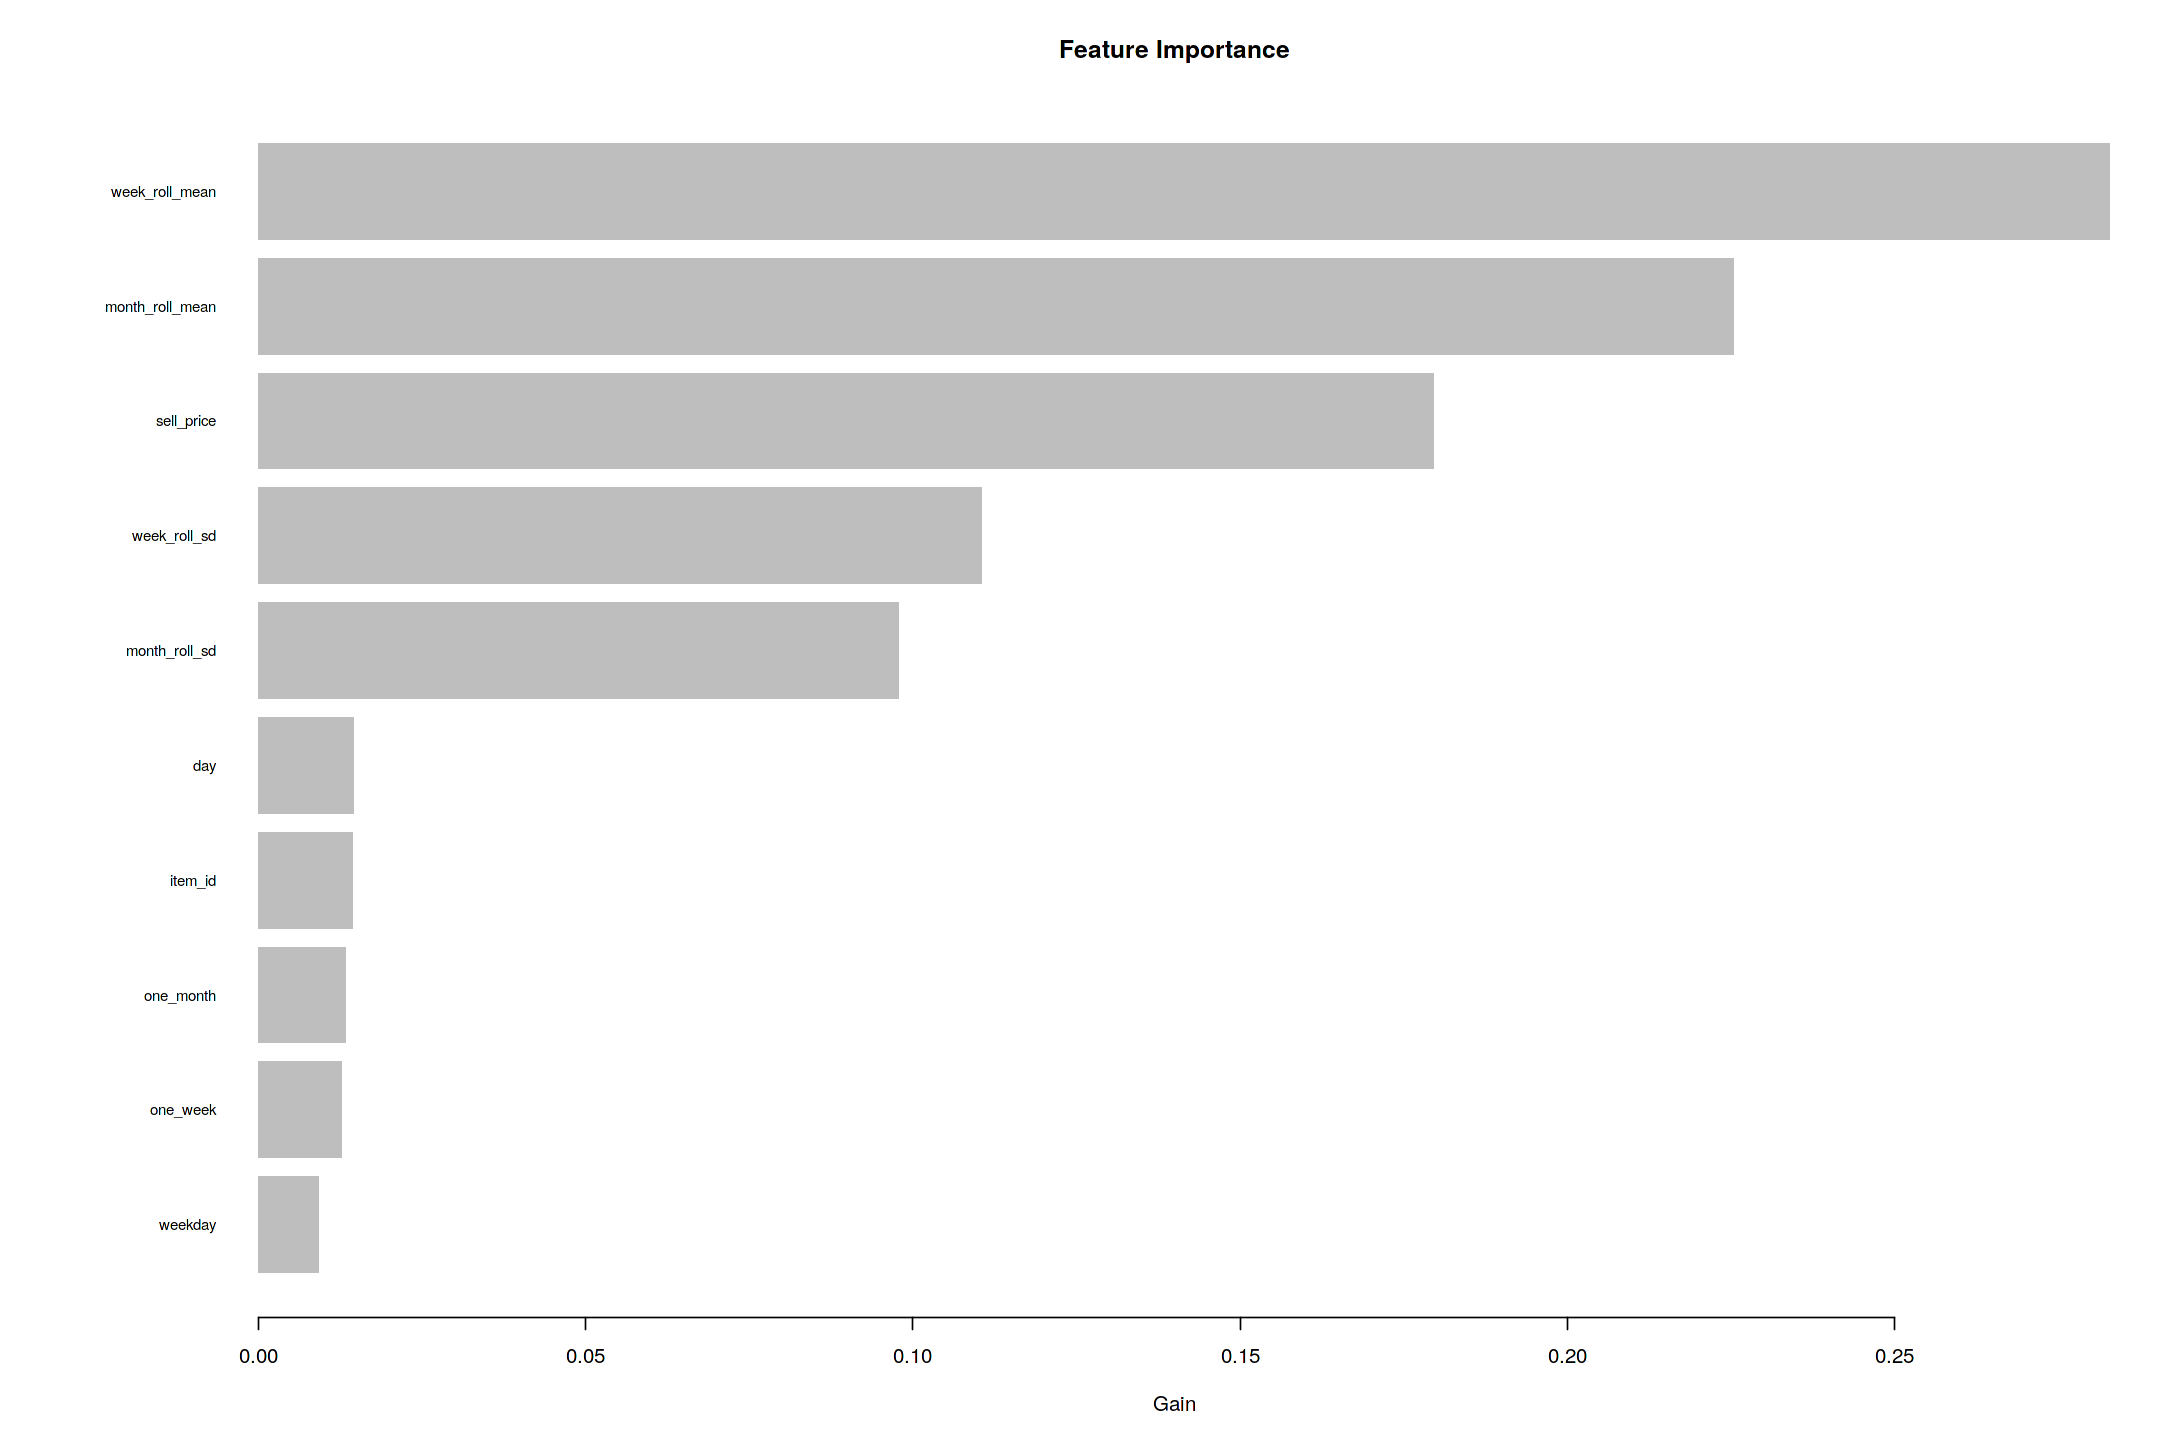

In [73]:
#test[,'Unit_Sales'] = y_pred
imp = lgb.importance(l_lgb)
g21<-lgb.plot.importance(imp, top_n = 10, measure = "Gain")
g21
#ggsave('g21.png')

### SMAPE for Lightgbm

In [74]:
SMAPE_ERR <- smape_cal(outsample=validation$Unit_Sales, forecasts=y_pred_lgb)
SMAPE<-mean(SMAPE_ERR,na.rm = T)
sprintf("The value of SMAPE for Lightlgm is %f ", SMAPE )

[1] "The value of SMAPE for Lightlgm is 2.000000 "

In [75]:
accuracy_lgb <- (1 - (sum((validation$Unit_Sales - y_pred_lgb))/sum(validation$Unit_Sales)))
sprintf("Accuracy for lightgbm is %f ", accuracy_lgb )

[1] "Accuracy for lightgbm is 0.000000 "

In [76]:
rm(train_set_lgb)
rm(test_set_lgb)
freeram()

# Prophet

In [77]:
#install.packages('prophet')
#library(prophet)

In [78]:
#stats=data.frame(y=log1p(data$Unit_Sales)
#                 ,ds=data$date)
#stats=aggregate(stats$y,by=list(stats$ds),FUN=sum)
#head(stats)
#colnames(stats)<- c("ds","y")

#model_prophet = prophet(stats)
#summary(model_prophet)
#future = make_future_dataframe(model_prophet, periods = 28)
#forecast = predict(model_prophet, future)

In [79]:
#add_changepoints_to_plot <- function(m, threshold = 0.01, cp_color = "red",
#                               cp_linetype = "dashed", trend = TRUE, ...) {
#  layers <- list()
#  if (trend) {
#    trend_layer <- ggplot2::geom_line(
#      ggplot2::aes_string("ds", "trend"), color = cp_color, ...)
#    layers <- append(layers, trend_layer)
#  }
#  signif_changepoints <- m$changepoints[abs(m$params$delta) >= threshold]
#  cp_layer <- ggplot2::geom_vline(
#    xintercept = as.integer(signif_changepoints), color = cp_color,
#    linetype = cp_linetype, ...)
#  layers <- append(layers, cp_layer)
#  return(layers)
#}
#g22<-plot(model_prophet, forecast)+ add_changepoints_to_plot(model_prophet)
#g22
#ggsave('g22.png')

In [80]:
#prophet_plot_components(model_prophet, forecast)

In [81]:
freeram()

In [82]:
#completeFun <- function(data, desiredCols) {
#  completeVec <- complete.cases(data[, desiredCols])
#  return(data[completeVec, ])
#}

In [83]:
#weekends<-dplyr::filter(data,(weekday=='Saturday'|weekday=='Sunday'))
#event1<-completeFun(data, c("event_name_1"))
#event2<-completeFun(data, c("event_name_2"))
#event3<-completeFun(data, c("event_type_1"))
#event4<-completeFun(data, c("event_type_2"))
freeram()

In [84]:

#weekend <- data_frame(holiday = 'weekends',

#ds =(weekends$date),
#  lower_window = 0,
#  upper_window = 0
#)
#event_day1<-data_frame(
#  holiday = 'event1',
#  ds =(event1$date),
#  lower_window = 0,
#  upper_window = 0)
#event_day2<-data_frame(
 # holiday = 'event2',
 # ds =(event2$date),
#  lower_window = 0,
#  upper_window = 0)
#event_day3<-data_frame(
#  holiday = 'event3',
#  ds =(event2$date),
#  lower_window = 0,
#  upper_window = 0)
#event_day4<-data_frame(
 # holiday = 'event4',
 # ds =(event2$date),
 # lower_window = 0,
#  upper_window = 0)
#holidays <- bind_rows(weekend, event_day1,event_day2,event_day3,event_day4)
#freeram()


In [85]:
#holiday_week <- function(ds) {
#  dates <- as.Date(ds)
#}
#stats$holiday_week <- holiday_week(stats$ds)


#model_prophet <- prophet()
#model_prophet <- add_regressor(model_prophet, 'holiday_week')
#model_prophet <- add_seasonality(model_prophet, name='daily', period=1, fourier.order=5)
#model_prophet <- prophet(stats, holidays = holidays,holidays.prior.scale = 0.5,
#                         interval.width = 0.95,changepoint.prior.scale = 0.006)
#future = make_future_dataframe(model_prophet, periods = 28, freq = 'days')
#forecast = predict(model_prophet, future)
#freeram()

In [86]:
#g23<-plot(model_prophet, forecast) + add_changepoints_to_plot(model_prophet)
#prophet_plot_components(model_prophet, forecast)
#g23
#ggsave('g23.png')

In [87]:
#freeram()
#predict_data=data.frame(date=forecast$ds,forecast=expm1(forecast$yhat))
#predict_data$yearmonth=as.Date(predict_data$date)

#colnames(predict_data)<-c("ds","forecast","yearmonth")

In [88]:
#str(stats)
#stats$ds=as.Date(stats$ds)
#predict_data$ds=as.Date(predict_data$ds)

#train_predict=merge(stats,predict_data,by="ds",all.x=T)
#SMAPE_ERR <- smape_cal(outsample=train_predict$y, forecasts=train_predict$forecast)
#SMAPE<-mean(SMAPE_ERR,na.rm = T)
#sprintf("The value of SMAPE for prophet is %f ", SMAPE)'''